# <h1><center> Homework 6 </center></h1>

In [740]:
import warnings
warnings.simplefilter('ignore')

from functools import partial

import pandas as pd
import numpy as np
import pandas_profiling as pp

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import rankdata
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
import xgbfir

%matplotlib inline
import matplotlib as plt
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
plt.rcParams['figure.figsize'] = 16, 10

In [2]:
train = pd.read_csv('../data/train_5.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/test_5.csv', sep='\t', index_col=0)

## Preprocess

In [3]:
# 9 == 2 in both test and train, 140 and 164 have constant value 0 in both train and test
redundant_columns = ['9', '140', '164'] 
# 11 has constant value 1 in test
use_only_ones = ['11']
# those features have constant value 0 in test
use_only_zeros = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']
# those features have constant value 0 inly in train
zero_train_features = ['152', '160']
#too much zeros
too_much_zeros_features = ['191', '182', '185', '181', '172', '170', '157', '136', '135']

In [4]:
#152 and 160 is useless
for feature in zero_train_features:
    print(f"Len of test where {feature} != 0 is {len(test[test[feature]==1])}")
    redundant_columns.append(feature)

Len of test where 152 != 0 is 1
Len of test where 160 != 0 is 1


In [5]:
def preprocess(train_df, test_df):
    _train = train_df.drop(redundant_columns, axis=1)
    _test = test_df.drop(redundant_columns, axis=1)
    for column in use_only_zeros:
        _train = _train[_train[column] == 0].drop(column, axis=1)
        _test.drop(column, axis=1, inplace=True)
    for column in use_only_ones:
        _train = _train[_train[column] == 1].drop(column, axis=1)
        _test.drop(column, axis=1, inplace=True)
    X_train = _train.drop('0', axis=1).reset_index(drop=True)
    y_train = _train['0'].reset_index(drop=True)
    X_test = _test.drop('0', axis=1).reset_index(drop=True)
    return X_train, y_train, X_test

In [6]:
X_train, y_train, X_test = preprocess(train, test)

In [7]:
skf = StratifiedKFold(n_splits=10)

## <h1><center> All in one methods </center></h1>

In [8]:
def calculate(model, parameters, X_train, y_train, cv_iterator):
    
    gs = GridSearchCV(
    estimator=model,
    param_grid=parameters, 
    cv=cv_iterator, 
    error_score=1,  
    scoring='roc_auc',  
    n_jobs=-1,
    verbose=1)

    gs.fit(X=X_train, y=y_train)

    best_score = gs.best_score_
    best_model = gs.best_estimator_
    
    return best_model, best_score


def get_submission(model, X_train, X_test, y_train, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    make_file(y_pred, filename)
    return y_pred


def make_file(y_pred, filename):
    submission = pd.Series (y_pred, name='_VAL_' )
    submission.to_csv(filename, index_label='_ID_', header =True )
    
    
def get_pred_cv(estimator, X_train, y_train=y_train, cv=skf):
    k=0
    pred_cv = []
    for train, val in cv.split(X_train, y_train):
        k+=1
        print(f"Iteration: {k}")
        estimator.fit(X_train.iloc[train], y_train[train])
        pred_cv.append([y_train[val], estimator.predict_proba(X_train.iloc[val])[:,1]])
    return pred_cv


def get_stacked(X_train, X_test, predictions, pred_cv, prefix, cv=skf, y_train=y_train):
    X_train_stacked = X_train.copy()
    X_test_stacked = X_test.copy()
    X_train_stacked[prefix + "_preds"] = 0
    X_test_stacked[prefix + "_preds"] = predictions
    for i, fold in enumerate(cv.split(X_train, y_train)):
        train_stacked, val = fold[0], fold[1]
        X_train_stacked.iloc[val, -1] = pred_cv[i][1]
    return X_train_stacked, X_test_stacked


def check_train_score(params, lgb_data, data, target, kf, num_rounds):
    roc_auc = []
    for train, val in kf.split(data,target):
        temp_lgb_train = lgb_data.subset(train)
        temp_lgb_val = lgb_data.subset(val)
        temp_model = lgb.train(params, temp_lgb_train, num_rounds, verbose_eval=num_rounds)
        roc_auc.append([roc_auc_score(target[train],temp_model.predict(data.loc[train])), roc_auc_score(target[val],temp_model.predict(data.loc[val]))])
    return np.mean(roc_auc, axis=0)


def train_score(model, X_train, y_train, cv):
    roc_auc = []
    for train, val in cv.split(X_train, y_train):
            temp_train = X_train.loc(train)
            temp_val = X_train.loc(val)
            model.fit(temp_train, y_train[train])
            roc_auc.append(roc_auc_score(y_train[train], model.predict_proba(temp_train)[:,1]))
    return np.mean(roc_auc)

# LightGBM

In [9]:
n_rounds = 10000

lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False) 

In [13]:
#lb 0.76498766

params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.03,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    'num_leaves': 100,
    'max_depth': 8,
    'min_data_in_leaf' : 15}

In [14]:
results_lgb = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(X_train, y_train), early_stopping_rounds=10, verbose_eval=1)

[1]	cv_agg's auc: 0.681974 + 0.0109657
[2]	cv_agg's auc: 0.703641 + 0.0107945
[3]	cv_agg's auc: 0.711273 + 0.0113576
[4]	cv_agg's auc: 0.713737 + 0.00924064
[5]	cv_agg's auc: 0.716425 + 0.00889638
[6]	cv_agg's auc: 0.717997 + 0.00897654
[7]	cv_agg's auc: 0.718742 + 0.00840089
[8]	cv_agg's auc: 0.718741 + 0.00842285
[9]	cv_agg's auc: 0.71998 + 0.00818063
[10]	cv_agg's auc: 0.720927 + 0.00854567
[11]	cv_agg's auc: 0.721193 + 0.00865912
[12]	cv_agg's auc: 0.721688 + 0.00874148
[13]	cv_agg's auc: 0.722322 + 0.00856241
[14]	cv_agg's auc: 0.722966 + 0.0084481
[15]	cv_agg's auc: 0.723717 + 0.00826193
[16]	cv_agg's auc: 0.724171 + 0.00805547
[17]	cv_agg's auc: 0.72505 + 0.00783447
[18]	cv_agg's auc: 0.725434 + 0.00781508
[19]	cv_agg's auc: 0.725796 + 0.00806043
[20]	cv_agg's auc: 0.726597 + 0.00846862
[21]	cv_agg's auc: 0.727221 + 0.00820088
[22]	cv_agg's auc: 0.727307 + 0.00824181
[23]	cv_agg's auc: 0.727664 + 0.00829509
[24]	cv_agg's auc: 0.728272 + 0.00789666
[25]	cv_agg's auc: 0.728869 + 0

[202]	cv_agg's auc: 0.747268 + 0.0115271
[203]	cv_agg's auc: 0.747364 + 0.0115796
[204]	cv_agg's auc: 0.747321 + 0.0116526
[205]	cv_agg's auc: 0.747376 + 0.0116568
[206]	cv_agg's auc: 0.747447 + 0.0115958
[207]	cv_agg's auc: 0.747466 + 0.0115732
[208]	cv_agg's auc: 0.747446 + 0.0115692
[209]	cv_agg's auc: 0.74744 + 0.0115524
[210]	cv_agg's auc: 0.747418 + 0.0115131
[211]	cv_agg's auc: 0.747337 + 0.0115329
[212]	cv_agg's auc: 0.747356 + 0.01152
[213]	cv_agg's auc: 0.747384 + 0.0115341
[214]	cv_agg's auc: 0.747436 + 0.0115248
[215]	cv_agg's auc: 0.747382 + 0.0115237
[216]	cv_agg's auc: 0.747435 + 0.0116365
[217]	cv_agg's auc: 0.747471 + 0.0116092
[218]	cv_agg's auc: 0.747451 + 0.0116053
[219]	cv_agg's auc: 0.747568 + 0.0115816
[220]	cv_agg's auc: 0.747628 + 0.0115688
[221]	cv_agg's auc: 0.747666 + 0.0115207
[222]	cv_agg's auc: 0.747693 + 0.0115189
[223]	cv_agg's auc: 0.747657 + 0.0115749
[224]	cv_agg's auc: 0.747682 + 0.0115361
[225]	cv_agg's auc: 0.747785 + 0.0114823
[226]	cv_agg's auc:

In [15]:
res_lgb = check_train_score(params_lgb, lgb_train, X_train, y_train, skf, len(results_lgb['auc-mean']))
print(f"Train score: {res_lgb[0]}, CV score: {res_lgb[1]}")

Train score: 0.9331809843963477, CV score: 0.7481659345419521


In [16]:
lgb_model = lgb.train(params_lgb, lgb_train, len(results_lgb['auc-mean']))

In [17]:
lgb_predictions = lgb_model.predict(X_test)
make_file(lgb_predictions, "hw6_submissions/lgb_predictions.csv")

In [144]:
lgb_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    lgb_train_temp = lgb.Dataset(X_train.iloc[train], y_train[train])
    temp_lgb_model = lgb.train(params_lgb,lgb_train_temp , len(results_lgb['auc-mean']))
    lgb_pred_cv.append([y_train[val], temp_lgb_model.predict(X_train.iloc[val])])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


Text(0.5,1,'Top 10 features')

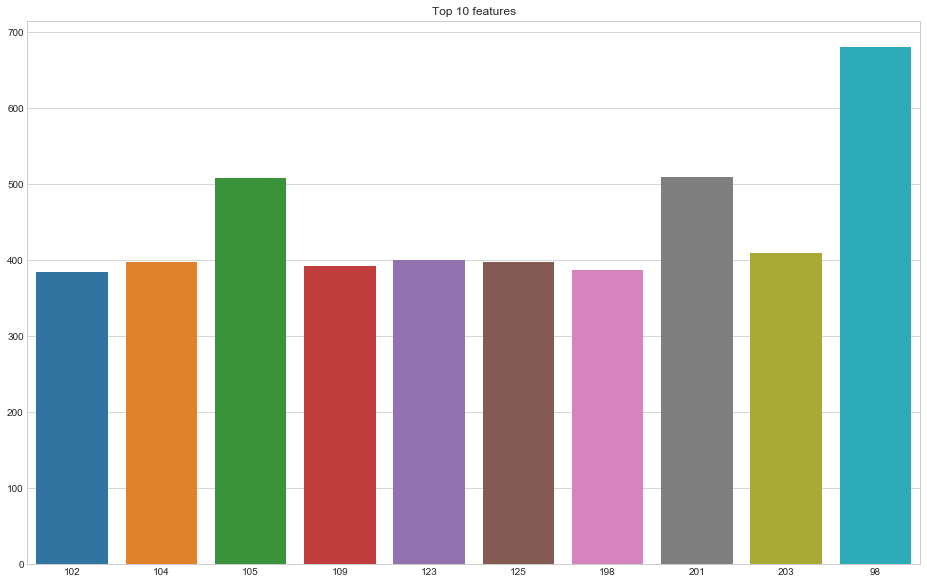

In [18]:
stl.use('seaborn-whitegrid')
top_lgb = sorted(zip(X_train.columns, lgb_model.feature_importance()), key=lambda x: x[1])[-10:]
fig = sns.barplot(x=[x[0] for x in top_lgb], y=[x[1] for x in top_lgb])
fig.set_title("Top 10 features")

# XGBoost

In [741]:
xgb_train = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
xgb_test = xgb.DMatrix(X_test, feature_names=X_train.columns)

In [767]:
#0.76480375

params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 42,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

In [768]:
results_xgb = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.710628+0.00313931	test-auc:0.678066+0.00462668
[1]	train-auc:0.73157+0.00597765	test-auc:0.69311+0.00339878
[2]	train-auc:0.742757+0.00452808	test-auc:0.70256+0.00425403
[3]	train-auc:0.747692+0.00360729	test-auc:0.706937+0.00449244
[4]	train-auc:0.749963+0.00332396	test-auc:0.710194+0.00389159
[5]	train-auc:0.753121+0.00585303	test-auc:0.710681+0.00275986
[6]	train-auc:0.754689+0.00464145	test-auc:0.71111+0.00288613
[7]	train-auc:0.75733+0.0051852	test-auc:0.712402+0.00245126
[8]	train-auc:0.75816+0.00420537	test-auc:0.71276+0.00255103
[9]	train-auc:0.759471+0.00358881	test-auc:0.713049+0.00334862
[10]	train-auc:0.759957+0.00424106	test-auc:0.713215+0.00329054
[11]	train-auc:0.761546+0.00442647	test-auc:0.7135+0.00274876
[12]	train-auc:0.761956+0.00391905	test-auc:0.71436+0.00363126
[13]	train-auc:0.762814+0.00429183	test-auc:0.714991+0.00323505
[14]	train-auc:0.763618+0.00484824	test-auc:0.715458+0.00317238
[15]	train-auc:0.764494+0.00505509	test-auc:0.71574+0.0028657

[129]	train-auc:0.810303+0.00287486	test-auc:0.726176+0.00432487
[130]	train-auc:0.810803+0.00286475	test-auc:0.726432+0.00435958
[131]	train-auc:0.811164+0.00303496	test-auc:0.726578+0.00423899
[132]	train-auc:0.811433+0.00309089	test-auc:0.726709+0.00424856
[133]	train-auc:0.811781+0.00326583	test-auc:0.726854+0.00426774
[134]	train-auc:0.812291+0.00317072	test-auc:0.726916+0.00418155
[135]	train-auc:0.812676+0.00303367	test-auc:0.726949+0.00423284
[136]	train-auc:0.812985+0.00302825	test-auc:0.727006+0.00428229
[137]	train-auc:0.813326+0.00309677	test-auc:0.727119+0.00424929
[138]	train-auc:0.813722+0.00294929	test-auc:0.727156+0.0043159
[139]	train-auc:0.814241+0.00273145	test-auc:0.727252+0.00429675
[140]	train-auc:0.814632+0.00265572	test-auc:0.727386+0.00426821
[141]	train-auc:0.815019+0.00260883	test-auc:0.727388+0.00425213
[142]	train-auc:0.815452+0.00273742	test-auc:0.727496+0.00432137
[143]	train-auc:0.815876+0.00285793	test-auc:0.727604+0.00426221
[144]	train-auc:0.81614+0.

[256]	train-auc:0.856648+0.00155498	test-auc:0.735696+0.00506157
[257]	train-auc:0.856897+0.00157921	test-auc:0.735752+0.00505016
[258]	train-auc:0.857205+0.0015699	test-auc:0.735817+0.00503957
[259]	train-auc:0.857473+0.00156293	test-auc:0.735827+0.00501053
[260]	train-auc:0.857801+0.00153011	test-auc:0.735875+0.00503257
[261]	train-auc:0.858068+0.00153007	test-auc:0.735896+0.00503837
[262]	train-auc:0.858349+0.00149877	test-auc:0.736021+0.00503188
[263]	train-auc:0.858651+0.00153907	test-auc:0.736097+0.00501675
[264]	train-auc:0.858988+0.00153025	test-auc:0.736138+0.0050269
[265]	train-auc:0.859379+0.0015472	test-auc:0.736191+0.00502729
[266]	train-auc:0.85965+0.00155087	test-auc:0.736258+0.00499748
[267]	train-auc:0.859901+0.001498	test-auc:0.736316+0.00500787
[268]	train-auc:0.860235+0.00157744	test-auc:0.736394+0.0049971
[269]	train-auc:0.860457+0.00159762	test-auc:0.736458+0.00501988
[270]	train-auc:0.860723+0.00158531	test-auc:0.736486+0.00501824
[271]	train-auc:0.861066+0.00152

[383]	train-auc:0.890485+0.00130742	test-auc:0.739506+0.00540897
[384]	train-auc:0.890709+0.0012655	test-auc:0.739528+0.00544782
[385]	train-auc:0.89094+0.00128825	test-auc:0.739515+0.00540726
[386]	train-auc:0.891224+0.00129583	test-auc:0.739564+0.00544535
[387]	train-auc:0.891444+0.00133602	test-auc:0.739612+0.0054375
[388]	train-auc:0.891684+0.00134434	test-auc:0.739586+0.00545347
[389]	train-auc:0.891884+0.00133909	test-auc:0.7396+0.00550453
[390]	train-auc:0.892163+0.00132087	test-auc:0.73959+0.00555078
[391]	train-auc:0.89237+0.00131195	test-auc:0.73963+0.0055133
[392]	train-auc:0.892546+0.00126009	test-auc:0.739642+0.0055279
[393]	train-auc:0.892786+0.00131663	test-auc:0.739637+0.00553777
[394]	train-auc:0.892984+0.00131599	test-auc:0.739613+0.00555615
[395]	train-auc:0.893186+0.00132348	test-auc:0.739637+0.0055982
[396]	train-auc:0.893374+0.00135713	test-auc:0.739644+0.0055735
[397]	train-auc:0.893598+0.00137726	test-auc:0.739686+0.00555122
[398]	train-auc:0.893765+0.00139603	t

[511]	train-auc:0.913924+0.00166233	test-auc:0.741399+0.00614911
[512]	train-auc:0.914083+0.00167353	test-auc:0.741404+0.00615
[513]	train-auc:0.91421+0.00173429	test-auc:0.741414+0.00612528
[514]	train-auc:0.914363+0.00170871	test-auc:0.741445+0.00616097
[515]	train-auc:0.914526+0.00171169	test-auc:0.741438+0.00614872
[516]	train-auc:0.914614+0.00173826	test-auc:0.741435+0.00616106
[517]	train-auc:0.914776+0.00174188	test-auc:0.74144+0.00619276
[518]	train-auc:0.914947+0.0017468	test-auc:0.741457+0.00621347
[519]	train-auc:0.915076+0.00177765	test-auc:0.741475+0.00623078
[520]	train-auc:0.915211+0.00174144	test-auc:0.741504+0.00626078
[521]	train-auc:0.915387+0.00171522	test-auc:0.741514+0.00628143
[522]	train-auc:0.91559+0.00167722	test-auc:0.741508+0.0062543
[523]	train-auc:0.915713+0.00166196	test-auc:0.741517+0.00627178
[524]	train-auc:0.915922+0.00159234	test-auc:0.741568+0.00629063
[525]	train-auc:0.916103+0.00163409	test-auc:0.741542+0.00625433
[526]	train-auc:0.916206+0.001621

In [769]:
xgb_model = xgb.train(params_xgb, xgb_train, len(results_xgb))

In [770]:
xgb_predictions = xgb_model.predict(xgb_test)
make_file(xgb_predictions, "hw6_submissions/xgb_predictions.csv")

In [27]:
xgbfir.saveXgbFI(xgb_model, feature_names=X_train.columns)

In [771]:
xgb_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    xgb_train_temp = xgb.DMatrix(X_train.iloc[train], y_train[train])
    temp_xgb_model = xgb.train(params_xgb,xgb_train_temp , len(results_xgb))
    xgb_pred_cv.append([y_train[val], temp_xgb_model.predict(xgb.DMatrix(X_train.iloc[val]))])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


# CatBoost

In [166]:
#nauchitsia tunit eto govno!!!!

ctb_train = ctb.Pool(X_train,y_train)

In [133]:
#0.75918378


params_ctb = {
    'eval_metric': 'AUC',
    'iterations': 10000,
    'learning_rate': 0.03,
    'random_seed': 42,
    'od_wait': 30,
    'od_type': 'Iter',
    'thread_count':4,
    
    
    #regularization
    'depth':  7
}

In [134]:
for train, val in skf.split(X_train,y_train):
    temp_ctb_train = ctb.Pool(X_train.loc[train], y_train.loc[train])
    temp_ctb_val = ctb.Pool(X_train.loc[val], y_train.loc[val])
    temp_model = ctb.train(temp_ctb_train, params_ctb, logging_level='Verbose', eval_set=temp_ctb_val)

0:	learn: 0.6502533	test: 0.6394628	best: 0.6394628 (0)	total: 155ms	remaining: 25m 53s
1:	learn: 0.6817448	test: 0.6720918	best: 0.6720918 (1)	total: 319ms	remaining: 26m 33s
2:	learn: 0.6832932	test: 0.6734212	best: 0.6734212 (2)	total: 495ms	remaining: 27m 31s
3:	learn: 0.6840041	test: 0.6748741	best: 0.6748741 (3)	total: 648ms	remaining: 26m 59s
4:	learn: 0.6846383	test: 0.6760099	best: 0.6760099 (4)	total: 818ms	remaining: 27m 16s
5:	learn: 0.6849135	test: 0.6747979	best: 0.6760099 (4)	total: 979ms	remaining: 27m 10s
6:	learn: 0.6857151	test: 0.6765797	best: 0.6765797 (6)	total: 1.14s	remaining: 27m 12s
7:	learn: 0.6870141	test: 0.6785499	best: 0.6785499 (7)	total: 1.32s	remaining: 27m 26s
8:	learn: 0.6919331	test: 0.6825997	best: 0.6825997 (8)	total: 1.49s	remaining: 27m 29s
9:	learn: 0.6946737	test: 0.6851096	best: 0.6851096 (9)	total: 1.65s	remaining: 27m 29s
10:	learn: 0.6954432	test: 0.6857120	best: 0.6857120 (10)	total: 1.81s	remaining: 27m 27s
11:	learn: 0.6960379	test: 0.6

92:	learn: 0.7333659	test: 0.7139764	best: 0.7139764 (92)	total: 21.2s	remaining: 37m 34s
93:	learn: 0.7335349	test: 0.7141650	best: 0.7141650 (93)	total: 21.5s	remaining: 37m 48s
94:	learn: 0.7337045	test: 0.7142383	best: 0.7142383 (94)	total: 21.9s	remaining: 38m 3s
95:	learn: 0.7339615	test: 0.7144825	best: 0.7144825 (95)	total: 22.2s	remaining: 38m 12s
96:	learn: 0.7341118	test: 0.7145298	best: 0.7145298 (96)	total: 22.4s	remaining: 38m 9s
97:	learn: 0.7346639	test: 0.7149894	best: 0.7149894 (97)	total: 22.6s	remaining: 38m 7s
98:	learn: 0.7348742	test: 0.7150108	best: 0.7150108 (98)	total: 22.9s	remaining: 38m 6s
99:	learn: 0.7352625	test: 0.7151714	best: 0.7151714 (99)	total: 23.1s	remaining: 38m 7s
100:	learn: 0.7356811	test: 0.7156191	best: 0.7156191 (100)	total: 23.4s	remaining: 38m 13s
101:	learn: 0.7359680	test: 0.7160675	best: 0.7160675 (101)	total: 23.6s	remaining: 38m 10s
102:	learn: 0.7361140	test: 0.7162022	best: 0.7162022 (102)	total: 23.8s	remaining: 38m 9s
103:	learn

183:	learn: 0.7552531	test: 0.7278577	best: 0.7278577 (183)	total: 41.7s	remaining: 37m 2s
184:	learn: 0.7553378	test: 0.7279561	best: 0.7279561 (184)	total: 41.9s	remaining: 37m 1s
185:	learn: 0.7554902	test: 0.7279502	best: 0.7279561 (184)	total: 42.1s	remaining: 37m 1s
186:	learn: 0.7556907	test: 0.7279768	best: 0.7279768 (186)	total: 42.3s	remaining: 37m 1s
187:	learn: 0.7559080	test: 0.7279606	best: 0.7279768 (186)	total: 42.5s	remaining: 36m 59s
188:	learn: 0.7561977	test: 0.7280716	best: 0.7280716 (188)	total: 42.7s	remaining: 36m 57s
189:	learn: 0.7563136	test: 0.7280272	best: 0.7280716 (188)	total: 43s	remaining: 37m
190:	learn: 0.7565107	test: 0.7282203	best: 0.7282203 (190)	total: 43.3s	remaining: 37m 2s
191:	learn: 0.7568054	test: 0.7283379	best: 0.7283379 (191)	total: 43.6s	remaining: 37m 5s
192:	learn: 0.7570055	test: 0.7281981	best: 0.7283379 (191)	total: 43.9s	remaining: 37m 9s
193:	learn: 0.7570987	test: 0.7281936	best: 0.7283379 (191)	total: 44.1s	remaining: 37m 8s
19

273:	learn: 0.7699643	test: 0.7310876	best: 0.7310876 (273)	total: 1m 4s	remaining: 38m 10s
274:	learn: 0.7702415	test: 0.7312312	best: 0.7312312 (274)	total: 1m 4s	remaining: 38m 13s
275:	learn: 0.7703911	test: 0.7313873	best: 0.7313873 (275)	total: 1m 5s	remaining: 38m 15s
276:	learn: 0.7705263	test: 0.7315198	best: 0.7315198 (276)	total: 1m 5s	remaining: 38m 13s
277:	learn: 0.7706644	test: 0.7315405	best: 0.7315405 (277)	total: 1m 5s	remaining: 38m 15s
278:	learn: 0.7707608	test: 0.7315279	best: 0.7315405 (277)	total: 1m 5s	remaining: 38m 14s
279:	learn: 0.7709091	test: 0.7315309	best: 0.7315405 (277)	total: 1m 6s	remaining: 38m 16s
280:	learn: 0.7711825	test: 0.7317388	best: 0.7317388 (280)	total: 1m 6s	remaining: 38m 18s
281:	learn: 0.7712685	test: 0.7317980	best: 0.7317980 (281)	total: 1m 6s	remaining: 38m 20s
282:	learn: 0.7714120	test: 0.7316796	best: 0.7317980 (281)	total: 1m 7s	remaining: 38m 22s
283:	learn: 0.7715467	test: 0.7317973	best: 0.7317980 (281)	total: 1m 7s	remaini

362:	learn: 0.7843910	test: 0.7338736	best: 0.7340904 (360)	total: 1m 29s	remaining: 39m 24s
363:	learn: 0.7845224	test: 0.7338780	best: 0.7340904 (360)	total: 1m 29s	remaining: 39m 25s
364:	learn: 0.7846865	test: 0.7339010	best: 0.7340904 (360)	total: 1m 29s	remaining: 39m 23s
365:	learn: 0.7848208	test: 0.7339091	best: 0.7340904 (360)	total: 1m 29s	remaining: 39m 22s
366:	learn: 0.7849641	test: 0.7338625	best: 0.7340904 (360)	total: 1m 29s	remaining: 39m 21s
367:	learn: 0.7851957	test: 0.7338262	best: 0.7340904 (360)	total: 1m 30s	remaining: 39m 22s
368:	learn: 0.7854647	test: 0.7338410	best: 0.7340904 (360)	total: 1m 30s	remaining: 39m 21s
369:	learn: 0.7856017	test: 0.7339461	best: 0.7340904 (360)	total: 1m 30s	remaining: 39m 20s
370:	learn: 0.7857681	test: 0.7341970	best: 0.7341970 (370)	total: 1m 30s	remaining: 39m 21s
371:	learn: 0.7859031	test: 0.7340423	best: 0.7341970 (370)	total: 1m 31s	remaining: 39m 22s
372:	learn: 0.7860788	test: 0.7339454	best: 0.7341970 (370)	total: 1m 

451:	learn: 0.7999209	test: 0.7365612	best: 0.7365878 (450)	total: 1m 52s	remaining: 39m 44s
452:	learn: 0.8000963	test: 0.7366292	best: 0.7366292 (452)	total: 1m 53s	remaining: 39m 44s
453:	learn: 0.8002265	test: 0.7365530	best: 0.7366292 (452)	total: 1m 53s	remaining: 39m 44s
454:	learn: 0.8002951	test: 0.7365508	best: 0.7366292 (452)	total: 1m 53s	remaining: 39m 44s
455:	learn: 0.8004668	test: 0.7365108	best: 0.7366292 (452)	total: 1m 53s	remaining: 39m 44s
456:	learn: 0.8006171	test: 0.7365508	best: 0.7366292 (452)	total: 1m 54s	remaining: 39m 44s
457:	learn: 0.8008228	test: 0.7365086	best: 0.7366292 (452)	total: 1m 54s	remaining: 39m 45s
458:	learn: 0.8010758	test: 0.7363621	best: 0.7366292 (452)	total: 1m 54s	remaining: 39m 45s
459:	learn: 0.8011766	test: 0.7364931	best: 0.7366292 (452)	total: 1m 55s	remaining: 39m 45s
460:	learn: 0.8012802	test: 0.7364901	best: 0.7366292 (452)	total: 1m 55s	remaining: 39m 45s
461:	learn: 0.8015140	test: 0.7365286	best: 0.7366292 (452)	total: 1m 

540:	learn: 0.8134606	test: 0.7385132	best: 0.7386545 (533)	total: 2m 15s	remaining: 39m 31s
541:	learn: 0.8135552	test: 0.7385620	best: 0.7386545 (533)	total: 2m 15s	remaining: 39m 32s
542:	learn: 0.8136761	test: 0.7385628	best: 0.7386545 (533)	total: 2m 16s	remaining: 39m 32s
543:	learn: 0.8138601	test: 0.7385369	best: 0.7386545 (533)	total: 2m 16s	remaining: 39m 33s
544:	learn: 0.8139785	test: 0.7385065	best: 0.7386545 (533)	total: 2m 16s	remaining: 39m 33s
545:	learn: 0.8140920	test: 0.7385213	best: 0.7386545 (533)	total: 2m 17s	remaining: 39m 34s
546:	learn: 0.8142501	test: 0.7384621	best: 0.7386545 (533)	total: 2m 17s	remaining: 39m 35s
547:	learn: 0.8143426	test: 0.7384658	best: 0.7386545 (533)	total: 2m 17s	remaining: 39m 36s
548:	learn: 0.8145221	test: 0.7385013	best: 0.7386545 (533)	total: 2m 18s	remaining: 39m 37s
549:	learn: 0.8145867	test: 0.7384865	best: 0.7386545 (533)	total: 2m 18s	remaining: 39m 38s
550:	learn: 0.8148032	test: 0.7384917	best: 0.7386545 (533)	total: 2m 

65:	learn: 0.7247192	test: 0.7054683	best: 0.7054683 (65)	total: 16.3s	remaining: 40m 46s
66:	learn: 0.7252311	test: 0.7059167	best: 0.7059167 (66)	total: 16.5s	remaining: 40m 47s
67:	learn: 0.7254025	test: 0.7061006	best: 0.7061006 (67)	total: 16.8s	remaining: 40m 48s
68:	learn: 0.7260166	test: 0.7063810	best: 0.7063810 (68)	total: 17s	remaining: 40m 47s
69:	learn: 0.7264171	test: 0.7068524	best: 0.7068524 (69)	total: 17.2s	remaining: 40m 44s
70:	learn: 0.7268324	test: 0.7073578	best: 0.7073578 (70)	total: 17.5s	remaining: 40m 41s
71:	learn: 0.7272474	test: 0.7076867	best: 0.7076867 (71)	total: 17.7s	remaining: 40m 38s
72:	learn: 0.7276252	test: 0.7076955	best: 0.7076955 (72)	total: 17.9s	remaining: 40m 36s
73:	learn: 0.7278228	test: 0.7077436	best: 0.7077436 (73)	total: 18.2s	remaining: 40m 37s
74:	learn: 0.7283451	test: 0.7082579	best: 0.7082579 (74)	total: 18.4s	remaining: 40m 38s
75:	learn: 0.7285171	test: 0.7085717	best: 0.7085717 (75)	total: 18.7s	remaining: 40m 39s
76:	learn: 0

156:	learn: 0.7517199	test: 0.7232418	best: 0.7232418 (156)	total: 40.5s	remaining: 42m 20s
157:	learn: 0.7519064	test: 0.7235659	best: 0.7235659 (157)	total: 40.7s	remaining: 42m 18s
158:	learn: 0.7521216	test: 0.7237465	best: 0.7237465 (158)	total: 41s	remaining: 42m 17s
159:	learn: 0.7523290	test: 0.7239107	best: 0.7239107 (159)	total: 41.3s	remaining: 42m 17s
160:	learn: 0.7525627	test: 0.7241409	best: 0.7241409 (160)	total: 41.5s	remaining: 42m 14s
161:	learn: 0.7528809	test: 0.7245138	best: 0.7245138 (161)	total: 41.7s	remaining: 42m 13s
162:	learn: 0.7530211	test: 0.7247114	best: 0.7247114 (162)	total: 42s	remaining: 42m 12s
163:	learn: 0.7533169	test: 0.7247195	best: 0.7247195 (163)	total: 42.2s	remaining: 42m 9s
164:	learn: 0.7534625	test: 0.7247928	best: 0.7247928 (164)	total: 42.4s	remaining: 42m 8s
165:	learn: 0.7536353	test: 0.7247639	best: 0.7247928 (164)	total: 42.7s	remaining: 42m 7s
166:	learn: 0.7538782	test: 0.7248549	best: 0.7248549 (166)	total: 43s	remaining: 42m 9

246:	learn: 0.7680605	test: 0.7304106	best: 0.7304106 (246)	total: 1m 3s	remaining: 41m 53s
247:	learn: 0.7681735	test: 0.7303788	best: 0.7304106 (246)	total: 1m 3s	remaining: 41m 53s
248:	learn: 0.7684414	test: 0.7303958	best: 0.7304106 (246)	total: 1m 4s	remaining: 41m 55s
249:	learn: 0.7685990	test: 0.7303107	best: 0.7304106 (246)	total: 1m 4s	remaining: 41m 58s
250:	learn: 0.7687555	test: 0.7303166	best: 0.7304106 (246)	total: 1m 4s	remaining: 42m
251:	learn: 0.7688803	test: 0.7304202	best: 0.7304202 (251)	total: 1m 5s	remaining: 42m 2s
252:	learn: 0.7689532	test: 0.7304246	best: 0.7304246 (252)	total: 1m 5s	remaining: 42m 2s
253:	learn: 0.7690412	test: 0.7303936	best: 0.7304246 (252)	total: 1m 5s	remaining: 42m 1s
254:	learn: 0.7692187	test: 0.7304779	best: 0.7304779 (254)	total: 1m 5s	remaining: 42m
255:	learn: 0.7694051	test: 0.7303921	best: 0.7304779 (254)	total: 1m 6s	remaining: 41m 59s
256:	learn: 0.7694777	test: 0.7304291	best: 0.7304779 (254)	total: 1m 6s	remaining: 42m 1s


336:	learn: 0.7824345	test: 0.7339920	best: 0.7340712 (332)	total: 1m 28s	remaining: 42m 9s
337:	learn: 0.7825499	test: 0.7339646	best: 0.7340712 (332)	total: 1m 28s	remaining: 42m 8s
338:	learn: 0.7828046	test: 0.7342066	best: 0.7342066 (338)	total: 1m 28s	remaining: 42m 7s
339:	learn: 0.7829350	test: 0.7343257	best: 0.7343257 (339)	total: 1m 28s	remaining: 42m 6s
340:	learn: 0.7830999	test: 0.7344108	best: 0.7344108 (340)	total: 1m 29s	remaining: 42m 5s
341:	learn: 0.7832381	test: 0.7344234	best: 0.7344234 (341)	total: 1m 29s	remaining: 42m 6s
342:	learn: 0.7834749	test: 0.7343479	best: 0.7344234 (341)	total: 1m 29s	remaining: 42m 7s
343:	learn: 0.7836887	test: 0.7343427	best: 0.7344234 (341)	total: 1m 30s	remaining: 42m 7s
344:	learn: 0.7838512	test: 0.7345795	best: 0.7345795 (344)	total: 1m 30s	remaining: 42m 7s
345:	learn: 0.7840108	test: 0.7346395	best: 0.7346395 (345)	total: 1m 30s	remaining: 42m 7s
346:	learn: 0.7841419	test: 0.7345055	best: 0.7346395 (345)	total: 1m 30s	remain

425:	learn: 0.7964045	test: 0.7362008	best: 0.7362008 (425)	total: 1m 53s	remaining: 42m 30s
426:	learn: 0.7964990	test: 0.7362356	best: 0.7362356 (426)	total: 1m 53s	remaining: 42m 29s
427:	learn: 0.7966220	test: 0.7361364	best: 0.7362356 (426)	total: 1m 53s	remaining: 42m 29s
428:	learn: 0.7968965	test: 0.7361845	best: 0.7362356 (426)	total: 1m 54s	remaining: 42m 28s
429:	learn: 0.7970725	test: 0.7361875	best: 0.7362356 (426)	total: 1m 54s	remaining: 42m 27s
430:	learn: 0.7972042	test: 0.7362541	best: 0.7362541 (430)	total: 1m 54s	remaining: 42m 27s
431:	learn: 0.7973086	test: 0.7362652	best: 0.7362652 (431)	total: 1m 55s	remaining: 42m 27s
432:	learn: 0.7974743	test: 0.7365582	best: 0.7365582 (432)	total: 1m 55s	remaining: 42m 26s
433:	learn: 0.7975854	test: 0.7365131	best: 0.7365582 (432)	total: 1m 55s	remaining: 42m 25s
434:	learn: 0.7978182	test: 0.7366337	best: 0.7366337 (434)	total: 1m 55s	remaining: 42m 24s
435:	learn: 0.7979804	test: 0.7367084	best: 0.7367084 (435)	total: 1m 

14:	learn: 0.6952464	test: 0.6790323	best: 0.6790323 (14)	total: 3.54s	remaining: 39m 13s
15:	learn: 0.6967110	test: 0.6794034	best: 0.6794034 (15)	total: 3.77s	remaining: 39m 11s
16:	learn: 0.6978612	test: 0.6801811	best: 0.6801811 (16)	total: 3.98s	remaining: 38m 59s
17:	learn: 0.6978686	test: 0.6802251	best: 0.6802251 (17)	total: 4.2s	remaining: 38m 47s
18:	learn: 0.6990302	test: 0.6822164	best: 0.6822164 (18)	total: 4.43s	remaining: 38m 46s
19:	learn: 0.6987377	test: 0.6817965	best: 0.6822164 (18)	total: 4.65s	remaining: 38m 40s
20:	learn: 0.6990708	test: 0.6814775	best: 0.6822164 (18)	total: 4.9s	remaining: 38m 48s
21:	learn: 0.6999547	test: 0.6821546	best: 0.6822164 (18)	total: 5.16s	remaining: 38m 59s
22:	learn: 0.7014556	test: 0.6841173	best: 0.6841173 (22)	total: 5.39s	remaining: 39m
23:	learn: 0.7014141	test: 0.6850053	best: 0.6850053 (23)	total: 5.64s	remaining: 39m 6s
24:	learn: 0.7022922	test: 0.6857227	best: 0.6857227 (24)	total: 5.91s	remaining: 39m 19s
25:	learn: 0.7032

106:	learn: 0.7403144	test: 0.7186877	best: 0.7186877 (106)	total: 26.3s	remaining: 40m 29s
107:	learn: 0.7404829	test: 0.7186152	best: 0.7186877 (106)	total: 26.5s	remaining: 40m 28s
108:	learn: 0.7409810	test: 0.7188742	best: 0.7188742 (108)	total: 26.8s	remaining: 40m 27s
109:	learn: 0.7412630	test: 0.7188372	best: 0.7188742 (108)	total: 27s	remaining: 40m 26s
110:	learn: 0.7413774	test: 0.7188623	best: 0.7188742 (108)	total: 27.2s	remaining: 40m 27s
111:	learn: 0.7416237	test: 0.7189119	best: 0.7189119 (111)	total: 27.5s	remaining: 40m 28s
112:	learn: 0.7418709	test: 0.7195290	best: 0.7195290 (112)	total: 27.8s	remaining: 40m 30s
113:	learn: 0.7420409	test: 0.7199434	best: 0.7199434 (113)	total: 28.1s	remaining: 40m 32s
114:	learn: 0.7423068	test: 0.7199464	best: 0.7199464 (114)	total: 28.4s	remaining: 40m 39s
115:	learn: 0.7426147	test: 0.7203885	best: 0.7203885 (115)	total: 28.7s	remaining: 40m 41s
116:	learn: 0.7428605	test: 0.7204840	best: 0.7204840 (116)	total: 28.9s	remaining

196:	learn: 0.7598419	test: 0.7307750	best: 0.7307750 (196)	total: 49.4s	remaining: 40m 56s
197:	learn: 0.7600207	test: 0.7309334	best: 0.7309334 (197)	total: 49.6s	remaining: 40m 54s
198:	learn: 0.7601704	test: 0.7310133	best: 0.7310133 (198)	total: 49.8s	remaining: 40m 53s
199:	learn: 0.7603454	test: 0.7309644	best: 0.7310133 (198)	total: 50.1s	remaining: 40m 52s
200:	learn: 0.7605687	test: 0.7311087	best: 0.7311087 (200)	total: 50.3s	remaining: 40m 52s
201:	learn: 0.7607981	test: 0.7311258	best: 0.7311258 (201)	total: 50.5s	remaining: 40m 51s
202:	learn: 0.7611840	test: 0.7311295	best: 0.7311295 (202)	total: 50.8s	remaining: 40m 50s
203:	learn: 0.7613468	test: 0.7312737	best: 0.7312737 (203)	total: 51s	remaining: 40m 48s
204:	learn: 0.7614589	test: 0.7312227	best: 0.7312737 (203)	total: 51.3s	remaining: 40m 49s
205:	learn: 0.7615903	test: 0.7312360	best: 0.7312737 (203)	total: 51.5s	remaining: 40m 49s
206:	learn: 0.7617529	test: 0.7312256	best: 0.7312737 (203)	total: 51.8s	remaining

286:	learn: 0.7745368	test: 0.7354179	best: 0.7354179 (286)	total: 1m 11s	remaining: 40m 36s
287:	learn: 0.7746123	test: 0.7354682	best: 0.7354682 (287)	total: 1m 12s	remaining: 40m 37s
288:	learn: 0.7746489	test: 0.7353950	best: 0.7354682 (287)	total: 1m 12s	remaining: 40m 38s
289:	learn: 0.7748435	test: 0.7352869	best: 0.7354682 (287)	total: 1m 12s	remaining: 40m 38s
290:	learn: 0.7750062	test: 0.7353905	best: 0.7354682 (287)	total: 1m 13s	remaining: 40m 36s
291:	learn: 0.7752204	test: 0.7355245	best: 0.7355245 (291)	total: 1m 13s	remaining: 40m 35s
292:	learn: 0.7755306	test: 0.7356103	best: 0.7356103 (292)	total: 1m 13s	remaining: 40m 35s
293:	learn: 0.7756861	test: 0.7357783	best: 0.7357783 (293)	total: 1m 13s	remaining: 40m 33s
294:	learn: 0.7760077	test: 0.7358722	best: 0.7358722 (294)	total: 1m 13s	remaining: 40m 33s
295:	learn: 0.7762246	test: 0.7360054	best: 0.7360054 (295)	total: 1m 14s	remaining: 40m 32s
296:	learn: 0.7763761	test: 0.7359307	best: 0.7360054 (295)	total: 1m 

375:	learn: 0.7901196	test: 0.7394374	best: 0.7396298 (373)	total: 1m 34s	remaining: 40m 14s
376:	learn: 0.7902380	test: 0.7395343	best: 0.7396298 (373)	total: 1m 34s	remaining: 40m 14s
377:	learn: 0.7903798	test: 0.7395047	best: 0.7396298 (373)	total: 1m 34s	remaining: 40m 14s
378:	learn: 0.7906621	test: 0.7396868	best: 0.7396868 (378)	total: 1m 35s	remaining: 40m 14s
379:	learn: 0.7908074	test: 0.7397637	best: 0.7397637 (379)	total: 1m 35s	remaining: 40m 15s
380:	learn: 0.7909580	test: 0.7397926	best: 0.7397926 (380)	total: 1m 35s	remaining: 40m 15s
381:	learn: 0.7911038	test: 0.7399213	best: 0.7399213 (381)	total: 1m 35s	remaining: 40m 16s
382:	learn: 0.7913118	test: 0.7397941	best: 0.7399213 (381)	total: 1m 36s	remaining: 40m 16s
383:	learn: 0.7914746	test: 0.7398666	best: 0.7399213 (381)	total: 1m 36s	remaining: 40m 15s
384:	learn: 0.7916024	test: 0.7398399	best: 0.7399213 (381)	total: 1m 36s	remaining: 40m 15s
385:	learn: 0.7918102	test: 0.7398133	best: 0.7399213 (381)	total: 1m 

464:	learn: 0.8044916	test: 0.7418179	best: 0.7418179 (464)	total: 1m 57s	remaining: 40m 10s
465:	learn: 0.8046968	test: 0.7418275	best: 0.7418275 (465)	total: 1m 57s	remaining: 40m 9s
466:	learn: 0.8048234	test: 0.7418334	best: 0.7418334 (466)	total: 1m 58s	remaining: 40m 9s
467:	learn: 0.8050018	test: 0.7416277	best: 0.7418334 (466)	total: 1m 58s	remaining: 40m 9s
468:	learn: 0.8052119	test: 0.7415759	best: 0.7418334 (466)	total: 1m 58s	remaining: 40m 9s
469:	learn: 0.8053612	test: 0.7414272	best: 0.7418334 (466)	total: 1m 58s	remaining: 40m 8s
470:	learn: 0.8056402	test: 0.7414072	best: 0.7418334 (466)	total: 1m 59s	remaining: 40m 8s
471:	learn: 0.8058299	test: 0.7415574	best: 0.7418334 (466)	total: 1m 59s	remaining: 40m 7s
472:	learn: 0.8059251	test: 0.7415063	best: 0.7418334 (466)	total: 1m 59s	remaining: 40m 7s
473:	learn: 0.8061202	test: 0.7415751	best: 0.7418334 (466)	total: 1m 59s	remaining: 40m 6s
474:	learn: 0.8063327	test: 0.7414368	best: 0.7418334 (466)	total: 1m 59s	remai

57:	learn: 0.7222134	test: 0.7261150	best: 0.7261150 (57)	total: 15.7s	remaining: 44m 46s
58:	learn: 0.7224166	test: 0.7263566	best: 0.7263566 (58)	total: 15.9s	remaining: 44m 36s
59:	learn: 0.7231457	test: 0.7263633	best: 0.7263633 (59)	total: 16.2s	remaining: 44m 39s
60:	learn: 0.7238682	test: 0.7264627	best: 0.7264627 (60)	total: 16.4s	remaining: 44m 34s
61:	learn: 0.7240378	test: 0.7265865	best: 0.7265865 (61)	total: 16.6s	remaining: 44m 27s
62:	learn: 0.7245046	test: 0.7266361	best: 0.7266361 (62)	total: 16.9s	remaining: 44m 31s
63:	learn: 0.7251200	test: 0.7273096	best: 0.7273096 (63)	total: 17.2s	remaining: 44m 26s
64:	learn: 0.7259821	test: 0.7278656	best: 0.7278656 (64)	total: 17.4s	remaining: 44m 21s
65:	learn: 0.7263767	test: 0.7281547	best: 0.7281547 (65)	total: 17.6s	remaining: 44m 14s
66:	learn: 0.7270289	test: 0.7288872	best: 0.7288872 (66)	total: 17.9s	remaining: 44m 13s
67:	learn: 0.7272483	test: 0.7291207	best: 0.7291207 (67)	total: 18.1s	remaining: 44m 8s
68:	learn: 

148:	learn: 0.7479405	test: 0.7370092	best: 0.7370092 (148)	total: 38.6s	remaining: 42m 30s
149:	learn: 0.7481745	test: 0.7371760	best: 0.7371760 (149)	total: 38.8s	remaining: 42m 30s
150:	learn: 0.7482481	test: 0.7372324	best: 0.7372324 (150)	total: 39.1s	remaining: 42m 31s
151:	learn: 0.7486070	test: 0.7376794	best: 0.7376794 (151)	total: 39.4s	remaining: 42m 30s
152:	learn: 0.7489495	test: 0.7379218	best: 0.7379218 (152)	total: 39.6s	remaining: 42m 30s
153:	learn: 0.7490457	test: 0.7379848	best: 0.7379848 (153)	total: 39.9s	remaining: 42m 31s
154:	learn: 0.7494278	test: 0.7379833	best: 0.7379848 (153)	total: 40.2s	remaining: 42m 30s
155:	learn: 0.7496411	test: 0.7380997	best: 0.7380997 (155)	total: 40.4s	remaining: 42m 30s
156:	learn: 0.7498457	test: 0.7382721	best: 0.7382721 (156)	total: 40.7s	remaining: 42m 29s
157:	learn: 0.7500298	test: 0.7383981	best: 0.7383981 (157)	total: 40.9s	remaining: 42m 29s
158:	learn: 0.7501140	test: 0.7385642	best: 0.7385642 (158)	total: 41.2s	remaini

238:	learn: 0.7644090	test: 0.7418868	best: 0.7418868 (238)	total: 1m	remaining: 41m 29s
239:	learn: 0.7645115	test: 0.7419573	best: 0.7419573 (239)	total: 1m 1s	remaining: 41m 28s
240:	learn: 0.7646745	test: 0.7419499	best: 0.7419573 (239)	total: 1m 1s	remaining: 41m 27s
241:	learn: 0.7647394	test: 0.7420766	best: 0.7420766 (241)	total: 1m 1s	remaining: 41m 27s
242:	learn: 0.7648661	test: 0.7421441	best: 0.7421441 (242)	total: 1m 1s	remaining: 41m 27s
243:	learn: 0.7649392	test: 0.7421812	best: 0.7421812 (243)	total: 1m 2s	remaining: 41m 28s
244:	learn: 0.7650964	test: 0.7422835	best: 0.7422835 (244)	total: 1m 2s	remaining: 41m 31s
245:	learn: 0.7652884	test: 0.7422686	best: 0.7422835 (244)	total: 1m 2s	remaining: 41m 30s
246:	learn: 0.7655081	test: 0.7422286	best: 0.7422835 (244)	total: 1m 3s	remaining: 41m 30s
247:	learn: 0.7655578	test: 0.7422508	best: 0.7422835 (244)	total: 1m 3s	remaining: 41m 29s
248:	learn: 0.7657047	test: 0.7423457	best: 0.7423457 (248)	total: 1m 3s	remaining:

328:	learn: 0.7781739	test: 0.7442888	best: 0.7444385 (317)	total: 1m 23s	remaining: 40m 59s
329:	learn: 0.7783509	test: 0.7444022	best: 0.7444385 (317)	total: 1m 23s	remaining: 40m 58s
330:	learn: 0.7784516	test: 0.7443236	best: 0.7444385 (317)	total: 1m 24s	remaining: 40m 57s
331:	learn: 0.7786505	test: 0.7443236	best: 0.7444385 (317)	total: 1m 24s	remaining: 40m 57s
332:	learn: 0.7788579	test: 0.7444652	best: 0.7444652 (332)	total: 1m 24s	remaining: 40m 56s
333:	learn: 0.7789731	test: 0.7443799	best: 0.7444652 (332)	total: 1m 24s	remaining: 40m 56s
334:	learn: 0.7791893	test: 0.7443473	best: 0.7444652 (332)	total: 1m 25s	remaining: 40m 56s
335:	learn: 0.7794795	test: 0.7442502	best: 0.7444652 (332)	total: 1m 25s	remaining: 40m 56s
336:	learn: 0.7796604	test: 0.7444148	best: 0.7444652 (332)	total: 1m 25s	remaining: 40m 55s
337:	learn: 0.7798907	test: 0.7445757	best: 0.7445757 (337)	total: 1m 25s	remaining: 40m 55s
338:	learn: 0.7802083	test: 0.7446965	best: 0.7446965 (338)	total: 1m 

417:	learn: 0.7937460	test: 0.7468886	best: 0.7468886 (417)	total: 1m 45s	remaining: 40m 19s
418:	learn: 0.7938418	test: 0.7469338	best: 0.7469338 (418)	total: 1m 45s	remaining: 40m 20s
419:	learn: 0.7939830	test: 0.7469457	best: 0.7469457 (419)	total: 1m 46s	remaining: 40m 20s
420:	learn: 0.7941141	test: 0.7469012	best: 0.7469457 (419)	total: 1m 46s	remaining: 40m 19s
421:	learn: 0.7942430	test: 0.7468256	best: 0.7469457 (419)	total: 1m 46s	remaining: 40m 18s
422:	learn: 0.7944693	test: 0.7468026	best: 0.7469457 (419)	total: 1m 46s	remaining: 40m 17s
423:	learn: 0.7946725	test: 0.7468360	best: 0.7469457 (419)	total: 1m 47s	remaining: 40m 16s
424:	learn: 0.7948873	test: 0.7469405	best: 0.7469457 (419)	total: 1m 47s	remaining: 40m 16s
425:	learn: 0.7950569	test: 0.7470443	best: 0.7470443 (425)	total: 1m 47s	remaining: 40m 15s
426:	learn: 0.7951459	test: 0.7469398	best: 0.7470443 (425)	total: 1m 47s	remaining: 40m 15s
427:	learn: 0.7952687	test: 0.7469257	best: 0.7470443 (425)	total: 1m 

18:	learn: 0.6999073	test: 0.6894670	best: 0.6894670 (18)	total: 4.36s	remaining: 38m 12s
19:	learn: 0.6987991	test: 0.6884217	best: 0.6894670 (18)	total: 4.61s	remaining: 38m 20s
20:	learn: 0.6990853	test: 0.6887039	best: 0.6894670 (18)	total: 4.87s	remaining: 38m 33s
21:	learn: 0.6991316	test: 0.6891270	best: 0.6894670 (18)	total: 5.16s	remaining: 39m 1s
22:	learn: 0.6986388	test: 0.6890124	best: 0.6894670 (18)	total: 5.5s	remaining: 39m 45s
23:	learn: 0.6990611	test: 0.6900206	best: 0.6900206 (23)	total: 5.76s	remaining: 39m 55s
24:	learn: 0.7004476	test: 0.6911472	best: 0.6911472 (24)	total: 5.97s	remaining: 39m 43s
25:	learn: 0.7005211	test: 0.6914675	best: 0.6914675 (25)	total: 6.21s	remaining: 39m 42s
26:	learn: 0.7015461	test: 0.6930023	best: 0.6930023 (26)	total: 6.43s	remaining: 39m 35s
27:	learn: 0.7034302	test: 0.6948798	best: 0.6948798 (27)	total: 6.66s	remaining: 39m 31s
28:	learn: 0.7044232	test: 0.6953455	best: 0.6953455 (28)	total: 6.89s	remaining: 39m 29s
29:	learn: 0

110:	learn: 0.7371050	test: 0.7279087	best: 0.7279161 (108)	total: 27.4s	remaining: 40m 38s
111:	learn: 0.7374954	test: 0.7285428	best: 0.7285428 (111)	total: 27.6s	remaining: 40m 36s
112:	learn: 0.7375854	test: 0.7285991	best: 0.7285991 (112)	total: 27.8s	remaining: 40m 36s
113:	learn: 0.7380031	test: 0.7289848	best: 0.7289848 (113)	total: 28.1s	remaining: 40m 35s
114:	learn: 0.7382664	test: 0.7293838	best: 0.7293838 (114)	total: 28.3s	remaining: 40m 34s
115:	learn: 0.7384960	test: 0.7295610	best: 0.7295610 (115)	total: 28.6s	remaining: 40m 33s
116:	learn: 0.7387199	test: 0.7296129	best: 0.7296129 (116)	total: 28.8s	remaining: 40m 32s
117:	learn: 0.7389408	test: 0.7298132	best: 0.7298132 (117)	total: 29.1s	remaining: 40m 35s
118:	learn: 0.7392952	test: 0.7300164	best: 0.7300164 (118)	total: 29.4s	remaining: 40m 40s
119:	learn: 0.7395177	test: 0.7300220	best: 0.7300220 (119)	total: 29.7s	remaining: 40m 44s
120:	learn: 0.7397562	test: 0.7303535	best: 0.7303535 (120)	total: 30s	remaining

200:	learn: 0.7567315	test: 0.7407674	best: 0.7407674 (200)	total: 49.8s	remaining: 40m 26s
201:	learn: 0.7568872	test: 0.7407630	best: 0.7407674 (200)	total: 50s	remaining: 40m 25s
202:	learn: 0.7570939	test: 0.7409692	best: 0.7409692 (202)	total: 50.2s	remaining: 40m 24s
203:	learn: 0.7572357	test: 0.7409603	best: 0.7409692 (202)	total: 50.5s	remaining: 40m 22s
204:	learn: 0.7573412	test: 0.7410344	best: 0.7410344 (204)	total: 50.7s	remaining: 40m 21s
205:	learn: 0.7574540	test: 0.7410708	best: 0.7410708 (205)	total: 50.9s	remaining: 40m 21s
206:	learn: 0.7575793	test: 0.7410359	best: 0.7410708 (205)	total: 51.1s	remaining: 40m 19s
207:	learn: 0.7577523	test: 0.7410648	best: 0.7410708 (205)	total: 51.4s	remaining: 40m 19s
208:	learn: 0.7579225	test: 0.7410900	best: 0.7410900 (208)	total: 51.6s	remaining: 40m 17s
209:	learn: 0.7580647	test: 0.7413133	best: 0.7413133 (209)	total: 51.8s	remaining: 40m 17s
210:	learn: 0.7582892	test: 0.7412873	best: 0.7413133 (209)	total: 52.1s	remaining

290:	learn: 0.7709396	test: 0.7495335	best: 0.7495691 (289)	total: 1m 11s	remaining: 39m 52s
291:	learn: 0.7711740	test: 0.7494631	best: 0.7495691 (289)	total: 1m 11s	remaining: 39m 52s
292:	learn: 0.7713783	test: 0.7495758	best: 0.7495758 (292)	total: 1m 12s	remaining: 39m 52s
293:	learn: 0.7715837	test: 0.7497375	best: 0.7497375 (293)	total: 1m 12s	remaining: 39m 52s
294:	learn: 0.7717946	test: 0.7497323	best: 0.7497375 (293)	total: 1m 12s	remaining: 39m 52s
295:	learn: 0.7719241	test: 0.7497004	best: 0.7497375 (293)	total: 1m 12s	remaining: 39m 52s
296:	learn: 0.7720802	test: 0.7497671	best: 0.7497671 (296)	total: 1m 13s	remaining: 39m 51s
297:	learn: 0.7722004	test: 0.7499266	best: 0.7499266 (297)	total: 1m 13s	remaining: 39m 52s
298:	learn: 0.7722247	test: 0.7499058	best: 0.7499266 (297)	total: 1m 13s	remaining: 39m 52s
299:	learn: 0.7723468	test: 0.7500082	best: 0.7500082 (299)	total: 1m 13s	remaining: 39m 52s
300:	learn: 0.7725944	test: 0.7501046	best: 0.7501046 (300)	total: 1m 

379:	learn: 0.7863307	test: 0.7545484	best: 0.7546560 (375)	total: 1m 35s	remaining: 40m 17s
380:	learn: 0.7865357	test: 0.7545173	best: 0.7546560 (375)	total: 1m 35s	remaining: 40m 18s
381:	learn: 0.7866774	test: 0.7545981	best: 0.7546560 (375)	total: 1m 36s	remaining: 40m 18s
382:	learn: 0.7868168	test: 0.7545469	best: 0.7546560 (375)	total: 1m 36s	remaining: 40m 16s
383:	learn: 0.7870834	test: 0.7547197	best: 0.7547197 (383)	total: 1m 36s	remaining: 40m 15s
384:	learn: 0.7872381	test: 0.7548836	best: 0.7548836 (384)	total: 1m 36s	remaining: 40m 14s
385:	learn: 0.7873369	test: 0.7548391	best: 0.7548836 (384)	total: 1m 36s	remaining: 40m 13s
386:	learn: 0.7875230	test: 0.7547895	best: 0.7548836 (384)	total: 1m 37s	remaining: 40m 13s
387:	learn: 0.7877607	test: 0.7549452	best: 0.7549452 (387)	total: 1m 37s	remaining: 40m 12s
388:	learn: 0.7879264	test: 0.7550446	best: 0.7550446 (388)	total: 1m 37s	remaining: 40m 11s
389:	learn: 0.7880540	test: 0.7551269	best: 0.7551269 (389)	total: 1m 

468:	learn: 0.8014622	test: 0.7562401	best: 0.7565760 (457)	total: 1m 58s	remaining: 40m 7s
469:	learn: 0.8016241	test: 0.7562801	best: 0.7565760 (457)	total: 1m 58s	remaining: 40m 9s
470:	learn: 0.8017983	test: 0.7562453	best: 0.7565760 (457)	total: 1m 59s	remaining: 40m 11s
471:	learn: 0.8019979	test: 0.7563565	best: 0.7565760 (457)	total: 1m 59s	remaining: 40m 12s
472:	learn: 0.8021422	test: 0.7563454	best: 0.7565760 (457)	total: 1m 59s	remaining: 40m 13s
473:	learn: 0.8023145	test: 0.7563380	best: 0.7565760 (457)	total: 2m	remaining: 40m 15s
474:	learn: 0.8025475	test: 0.7563825	best: 0.7565760 (457)	total: 2m	remaining: 40m 17s
475:	learn: 0.8026570	test: 0.7563647	best: 0.7565760 (457)	total: 2m	remaining: 40m 19s
476:	learn: 0.8028793	test: 0.7563491	best: 0.7565760 (457)	total: 2m 1s	remaining: 40m 23s
477:	learn: 0.8030301	test: 0.7565108	best: 0.7565760 (457)	total: 2m 1s	remaining: 40m 27s
478:	learn: 0.8031558	test: 0.7566584	best: 0.7566584 (478)	total: 2m 2s	remaining: 40

557:	learn: 0.8153673	test: 0.7585644	best: 0.7585644 (557)	total: 2m 22s	remaining: 40m 13s
558:	learn: 0.8155320	test: 0.7585354	best: 0.7585644 (557)	total: 2m 22s	remaining: 40m 14s
559:	learn: 0.8156109	test: 0.7585569	best: 0.7585644 (557)	total: 2m 23s	remaining: 40m 15s
560:	learn: 0.8156729	test: 0.7585503	best: 0.7585644 (557)	total: 2m 23s	remaining: 40m 16s
561:	learn: 0.8158044	test: 0.7586014	best: 0.7586014 (561)	total: 2m 24s	remaining: 40m 18s
562:	learn: 0.8159808	test: 0.7584679	best: 0.7586014 (561)	total: 2m 24s	remaining: 40m 21s
563:	learn: 0.8161875	test: 0.7584716	best: 0.7586014 (561)	total: 2m 24s	remaining: 40m 22s
564:	learn: 0.8163505	test: 0.7584872	best: 0.7586014 (561)	total: 2m 25s	remaining: 40m 23s
565:	learn: 0.8165481	test: 0.7583930	best: 0.7586014 (561)	total: 2m 25s	remaining: 40m 23s
566:	learn: 0.8166516	test: 0.7584175	best: 0.7586014 (561)	total: 2m 25s	remaining: 40m 24s
567:	learn: 0.8167717	test: 0.7583567	best: 0.7586014 (561)	total: 2m 

646:	learn: 0.8273552	test: 0.7598103	best: 0.7598236 (645)	total: 2m 45s	remaining: 39m 56s
647:	learn: 0.8274271	test: 0.7598667	best: 0.7598667 (647)	total: 2m 46s	remaining: 39m 56s
648:	learn: 0.8276424	test: 0.7598681	best: 0.7598681 (648)	total: 2m 46s	remaining: 39m 55s
649:	learn: 0.8278102	test: 0.7598333	best: 0.7598681 (648)	total: 2m 46s	remaining: 39m 55s
650:	learn: 0.8279543	test: 0.7599668	best: 0.7599668 (650)	total: 2m 46s	remaining: 39m 55s
651:	learn: 0.8280040	test: 0.7600268	best: 0.7600268 (651)	total: 2m 47s	remaining: 39m 54s
652:	learn: 0.8281939	test: 0.7600973	best: 0.7600973 (652)	total: 2m 47s	remaining: 39m 53s
653:	learn: 0.8283037	test: 0.7600142	best: 0.7600973 (652)	total: 2m 47s	remaining: 39m 54s
654:	learn: 0.8284156	test: 0.7600298	best: 0.7600973 (652)	total: 2m 47s	remaining: 39m 54s
655:	learn: 0.8286498	test: 0.7600795	best: 0.7600973 (652)	total: 2m 48s	remaining: 39m 53s
656:	learn: 0.8289166	test: 0.7601826	best: 0.7601826 (656)	total: 2m 

735:	learn: 0.8386514	test: 0.7624127	best: 0.7624201 (729)	total: 3m 8s	remaining: 39m 29s
736:	learn: 0.8387527	test: 0.7624134	best: 0.7624201 (729)	total: 3m 8s	remaining: 39m 29s
737:	learn: 0.8388668	test: 0.7624453	best: 0.7624453 (737)	total: 3m 8s	remaining: 39m 28s
738:	learn: 0.8390711	test: 0.7625758	best: 0.7625758 (738)	total: 3m 8s	remaining: 39m 27s
739:	learn: 0.8392479	test: 0.7626337	best: 0.7626337 (739)	total: 3m 9s	remaining: 39m 27s
740:	learn: 0.8393060	test: 0.7625328	best: 0.7626337 (739)	total: 3m 9s	remaining: 39m 26s
741:	learn: 0.8395110	test: 0.7625951	best: 0.7626337 (739)	total: 3m 9s	remaining: 39m 25s
742:	learn: 0.8395859	test: 0.7626908	best: 0.7626908 (742)	total: 3m 9s	remaining: 39m 25s
743:	learn: 0.8397793	test: 0.7627924	best: 0.7627924 (743)	total: 3m 10s	remaining: 39m 24s
744:	learn: 0.8398844	test: 0.7628124	best: 0.7628124 (744)	total: 3m 10s	remaining: 39m 24s
745:	learn: 0.8400110	test: 0.7629526	best: 0.7629526 (745)	total: 3m 10s	rema

824:	learn: 0.8488563	test: 0.7641132	best: 0.7641726 (820)	total: 3m 31s	remaining: 39m 8s
825:	learn: 0.8489844	test: 0.7640873	best: 0.7641726 (820)	total: 3m 31s	remaining: 39m 7s
826:	learn: 0.8491008	test: 0.7642519	best: 0.7642519 (826)	total: 3m 31s	remaining: 39m 7s
827:	learn: 0.8492030	test: 0.7642467	best: 0.7642519 (826)	total: 3m 31s	remaining: 39m 7s
828:	learn: 0.8492994	test: 0.7642638	best: 0.7642638 (828)	total: 3m 32s	remaining: 39m 8s
829:	learn: 0.8494163	test: 0.7641585	best: 0.7642638 (828)	total: 3m 32s	remaining: 39m 7s
830:	learn: 0.8495424	test: 0.7642274	best: 0.7642638 (828)	total: 3m 32s	remaining: 39m 7s
831:	learn: 0.8497044	test: 0.7642653	best: 0.7642653 (831)	total: 3m 33s	remaining: 39m 8s
832:	learn: 0.8497923	test: 0.7643231	best: 0.7643231 (832)	total: 3m 33s	remaining: 39m 7s
833:	learn: 0.8498649	test: 0.7643506	best: 0.7643506 (833)	total: 3m 33s	remaining: 39m 7s
834:	learn: 0.8499844	test: 0.7644062	best: 0.7644062 (834)	total: 3m 33s	remain

913:	learn: 0.8574063	test: 0.7655386	best: 0.7655824 (894)	total: 3m 54s	remaining: 38m 49s
914:	learn: 0.8575210	test: 0.7654497	best: 0.7655824 (894)	total: 3m 54s	remaining: 38m 49s
915:	learn: 0.8576296	test: 0.7654215	best: 0.7655824 (894)	total: 3m 55s	remaining: 38m 50s
916:	learn: 0.8577661	test: 0.7655579	best: 0.7655824 (894)	total: 3m 55s	remaining: 38m 50s
917:	learn: 0.8578800	test: 0.7655958	best: 0.7655958 (917)	total: 3m 55s	remaining: 38m 52s
918:	learn: 0.8579739	test: 0.7655987	best: 0.7655987 (918)	total: 3m 56s	remaining: 38m 52s
919:	learn: 0.8581043	test: 0.7654890	best: 0.7655987 (918)	total: 3m 56s	remaining: 38m 52s
920:	learn: 0.8581841	test: 0.7654281	best: 0.7655987 (918)	total: 3m 56s	remaining: 38m 52s
921:	learn: 0.8582539	test: 0.7654838	best: 0.7655987 (918)	total: 3m 56s	remaining: 38m 52s
922:	learn: 0.8583777	test: 0.7655386	best: 0.7655987 (918)	total: 3m 57s	remaining: 38m 52s
923:	learn: 0.8585558	test: 0.7654741	best: 0.7655987 (918)	total: 3m 

22:	learn: 0.7058770	test: 0.6872058	best: 0.6872058 (22)	total: 4.78s	remaining: 34m 35s
23:	learn: 0.7067061	test: 0.6877987	best: 0.6877987 (23)	total: 5.12s	remaining: 35m 28s
24:	learn: 0.7078981	test: 0.6890276	best: 0.6890276 (24)	total: 5.47s	remaining: 36m 24s
25:	learn: 0.7077717	test: 0.6888585	best: 0.6890276 (24)	total: 5.78s	remaining: 36m 58s
26:	learn: 0.7081117	test: 0.6890925	best: 0.6890925 (26)	total: 6.04s	remaining: 37m 12s
27:	learn: 0.7083860	test: 0.6893913	best: 0.6893913 (27)	total: 6.29s	remaining: 37m 18s
28:	learn: 0.7091007	test: 0.6904797	best: 0.6904797 (28)	total: 6.57s	remaining: 37m 39s
29:	learn: 0.7095351	test: 0.6905598	best: 0.6905598 (29)	total: 6.87s	remaining: 38m 3s
30:	learn: 0.7098132	test: 0.6912436	best: 0.6912436 (30)	total: 7.13s	remaining: 38m 13s
31:	learn: 0.7105087	test: 0.6914790	best: 0.6914790 (31)	total: 7.38s	remaining: 38m 20s
32:	learn: 0.7111219	test: 0.6921198	best: 0.6921198 (32)	total: 7.63s	remaining: 38m 24s
33:	learn: 

114:	learn: 0.7400275	test: 0.7137257	best: 0.7137821 (113)	total: 27.3s	remaining: 39m 7s
115:	learn: 0.7404990	test: 0.7142182	best: 0.7142182 (115)	total: 27.5s	remaining: 39m 6s
116:	learn: 0.7408100	test: 0.7146201	best: 0.7146201 (116)	total: 27.8s	remaining: 39m 4s
117:	learn: 0.7410512	test: 0.7147314	best: 0.7147314 (117)	total: 28s	remaining: 39m 4s
118:	learn: 0.7414729	test: 0.7150310	best: 0.7150310 (118)	total: 28.2s	remaining: 39m 3s
119:	learn: 0.7416368	test: 0.7152765	best: 0.7152765 (119)	total: 28.5s	remaining: 39m 3s
120:	learn: 0.7418768	test: 0.7154997	best: 0.7154997 (120)	total: 28.7s	remaining: 39m 3s
121:	learn: 0.7421198	test: 0.7156191	best: 0.7156191 (121)	total: 28.9s	remaining: 39m 2s
122:	learn: 0.7423636	test: 0.7153618	best: 0.7156191 (121)	total: 29.2s	remaining: 39m 2s
123:	learn: 0.7427159	test: 0.7153447	best: 0.7156191 (121)	total: 29.4s	remaining: 39m 2s
124:	learn: 0.7427973	test: 0.7155249	best: 0.7156191 (121)	total: 29.6s	remaining: 38m 57s


204:	learn: 0.7585541	test: 0.7225419	best: 0.7226168 (202)	total: 48.8s	remaining: 38m 50s
205:	learn: 0.7586707	test: 0.7225396	best: 0.7226168 (202)	total: 49.1s	remaining: 38m 52s
206:	learn: 0.7588614	test: 0.7226805	best: 0.7226805 (206)	total: 49.3s	remaining: 38m 54s
207:	learn: 0.7591046	test: 0.7228348	best: 0.7228348 (207)	total: 49.6s	remaining: 38m 55s
208:	learn: 0.7593646	test: 0.7229661	best: 0.7229661 (208)	total: 49.9s	remaining: 38m 58s
209:	learn: 0.7594125	test: 0.7231011	best: 0.7231011 (209)	total: 50.2s	remaining: 39m
210:	learn: 0.7595298	test: 0.7231767	best: 0.7231767 (210)	total: 50.5s	remaining: 39m 2s
211:	learn: 0.7596576	test: 0.7232954	best: 0.7232954 (211)	total: 50.8s	remaining: 39m 3s
212:	learn: 0.7598031	test: 0.7232449	best: 0.7232954 (211)	total: 51s	remaining: 39m 3s
213:	learn: 0.7599911	test: 0.7233717	best: 0.7233717 (213)	total: 51.2s	remaining: 39m 3s
214:	learn: 0.7601734	test: 0.7233970	best: 0.7233970 (214)	total: 51.5s	remaining: 39m 4s

295:	learn: 0.7734711	test: 0.7270977	best: 0.7272928 (287)	total: 1m 7s	remaining: 37m 1s
296:	learn: 0.7736320	test: 0.7270547	best: 0.7272928 (287)	total: 1m 7s	remaining: 37m
297:	learn: 0.7737730	test: 0.7270829	best: 0.7272928 (287)	total: 1m 8s	remaining: 36m 58s
298:	learn: 0.7738246	test: 0.7272060	best: 0.7272928 (287)	total: 1m 8s	remaining: 36m 58s
299:	learn: 0.7739804	test: 0.7273039	best: 0.7273039 (299)	total: 1m 8s	remaining: 36m 56s
300:	learn: 0.7740506	test: 0.7272779	best: 0.7273039 (299)	total: 1m 8s	remaining: 36m 55s
301:	learn: 0.7741770	test: 0.7272156	best: 0.7273039 (299)	total: 1m 8s	remaining: 36m 54s
302:	learn: 0.7743249	test: 0.7273543	best: 0.7273543 (302)	total: 1m 9s	remaining: 36m 53s
303:	learn: 0.7744702	test: 0.7273625	best: 0.7273625 (303)	total: 1m 9s	remaining: 36m 53s
304:	learn: 0.7747293	test: 0.7275731	best: 0.7275731 (304)	total: 1m 9s	remaining: 36m 51s
305:	learn: 0.7749262	test: 0.7277622	best: 0.7277622 (305)	total: 1m 9s	remaining: 3

384:	learn: 0.7890703	test: 0.7302585	best: 0.7302630 (381)	total: 1m 28s	remaining: 36m 40s
385:	learn: 0.7892766	test: 0.7302867	best: 0.7302867 (385)	total: 1m 28s	remaining: 36m 40s
386:	learn: 0.7894519	test: 0.7301606	best: 0.7302867 (385)	total: 1m 28s	remaining: 36m 40s
387:	learn: 0.7895860	test: 0.7302808	best: 0.7302867 (385)	total: 1m 28s	remaining: 36m 40s
388:	learn: 0.7898121	test: 0.7300939	best: 0.7302867 (385)	total: 1m 29s	remaining: 36m 40s
389:	learn: 0.7899497	test: 0.7302393	best: 0.7302867 (385)	total: 1m 29s	remaining: 36m 40s
390:	learn: 0.7901667	test: 0.7302318	best: 0.7302867 (385)	total: 1m 29s	remaining: 36m 40s
391:	learn: 0.7903272	test: 0.7303475	best: 0.7303475 (391)	total: 1m 29s	remaining: 36m 40s
392:	learn: 0.7905719	test: 0.7304425	best: 0.7304425 (392)	total: 1m 30s	remaining: 36m 40s
393:	learn: 0.7907031	test: 0.7304751	best: 0.7304751 (393)	total: 1m 30s	remaining: 36m 39s
394:	learn: 0.7908544	test: 0.7305218	best: 0.7305218 (394)	total: 1m 

473:	learn: 0.8042074	test: 0.7321727	best: 0.7322535 (467)	total: 1m 49s	remaining: 36m 40s
474:	learn: 0.8043603	test: 0.7321623	best: 0.7322535 (467)	total: 1m 49s	remaining: 36m 40s
475:	learn: 0.8045337	test: 0.7321986	best: 0.7322535 (467)	total: 1m 49s	remaining: 36m 40s
476:	learn: 0.8046004	test: 0.7321942	best: 0.7322535 (467)	total: 1m 50s	remaining: 36m 40s
477:	learn: 0.8047034	test: 0.7321808	best: 0.7322535 (467)	total: 1m 50s	remaining: 36m 40s
478:	learn: 0.8048745	test: 0.7320281	best: 0.7322535 (467)	total: 1m 50s	remaining: 36m 40s
479:	learn: 0.8049375	test: 0.7320859	best: 0.7322535 (467)	total: 1m 50s	remaining: 36m 40s
480:	learn: 0.8051492	test: 0.7321082	best: 0.7322535 (467)	total: 1m 51s	remaining: 36m 40s
481:	learn: 0.8052656	test: 0.7322164	best: 0.7322535 (467)	total: 1m 51s	remaining: 36m 40s
482:	learn: 0.8053961	test: 0.7321831	best: 0.7322535 (467)	total: 1m 51s	remaining: 36m 40s
483:	learn: 0.8056095	test: 0.7321660	best: 0.7322535 (467)	total: 1m 

562:	learn: 0.8170750	test: 0.7335892	best: 0.7337049 (541)	total: 2m 11s	remaining: 36m 46s
563:	learn: 0.8174485	test: 0.7335447	best: 0.7337049 (541)	total: 2m 11s	remaining: 36m 46s
564:	learn: 0.8176415	test: 0.7334579	best: 0.7337049 (541)	total: 2m 12s	remaining: 36m 46s
565:	learn: 0.8177664	test: 0.7333897	best: 0.7337049 (541)	total: 2m 12s	remaining: 36m 46s
566:	learn: 0.8178862	test: 0.7333296	best: 0.7337049 (541)	total: 2m 12s	remaining: 36m 45s
567:	learn: 0.8180210	test: 0.7333704	best: 0.7337049 (541)	total: 2m 12s	remaining: 36m 45s
568:	learn: 0.8181862	test: 0.7334030	best: 0.7337049 (541)	total: 2m 13s	remaining: 36m 45s
569:	learn: 0.8182975	test: 0.7333593	best: 0.7337049 (541)	total: 2m 13s	remaining: 36m 46s
570:	learn: 0.8184338	test: 0.7333890	best: 0.7337049 (541)	total: 2m 13s	remaining: 36m 46s
571:	learn: 0.8185536	test: 0.7332518	best: 0.7337049 (541)	total: 2m 13s	remaining: 36m 46s
572:	learn: 0.8186787	test: 0.7332510	best: 0.7337049 (541)	total: 2m 

80:	learn: 0.7307240	test: 0.6989610	best: 0.6989610 (80)	total: 20.8s	remaining: 42m 30s
81:	learn: 0.7312799	test: 0.6989988	best: 0.6989988 (81)	total: 21.1s	remaining: 42m 29s
82:	learn: 0.7316288	test: 0.6992161	best: 0.6992161 (82)	total: 21.3s	remaining: 42m 25s
83:	learn: 0.7319783	test: 0.6995461	best: 0.6995461 (83)	total: 21.6s	remaining: 42m 24s
84:	learn: 0.7322180	test: 0.6998828	best: 0.6998828 (84)	total: 21.8s	remaining: 42m 24s
85:	learn: 0.7324837	test: 0.6999162	best: 0.6999162 (85)	total: 22.1s	remaining: 42m 25s
86:	learn: 0.7327732	test: 0.6999696	best: 0.6999696 (86)	total: 22.4s	remaining: 42m 26s
87:	learn: 0.7330077	test: 0.7001943	best: 0.7001943 (87)	total: 22.6s	remaining: 42m 28s
88:	learn: 0.7333053	test: 0.7004361	best: 0.7004361 (88)	total: 22.9s	remaining: 42m 35s
89:	learn: 0.7335607	test: 0.7005785	best: 0.7005785 (89)	total: 23.2s	remaining: 42m 36s
90:	learn: 0.7337355	test: 0.7005807	best: 0.7005807 (90)	total: 23.5s	remaining: 42m 41s
91:	learn:

170:	learn: 0.7544418	test: 0.7092148	best: 0.7092148 (170)	total: 46.6s	remaining: 44m 40s
171:	learn: 0.7546545	test: 0.7092170	best: 0.7092170 (171)	total: 46.9s	remaining: 44m 42s
172:	learn: 0.7549905	test: 0.7094906	best: 0.7094906 (172)	total: 47.2s	remaining: 44m 42s
173:	learn: 0.7551609	test: 0.7095796	best: 0.7095796 (173)	total: 47.6s	remaining: 44m 45s
174:	learn: 0.7553131	test: 0.7095871	best: 0.7095871 (174)	total: 47.9s	remaining: 44m 46s
175:	learn: 0.7555769	test: 0.7096316	best: 0.7096316 (175)	total: 48.1s	remaining: 44m 46s
176:	learn: 0.7558143	test: 0.7095592	best: 0.7096316 (175)	total: 48.4s	remaining: 44m 45s
177:	learn: 0.7559782	test: 0.7096186	best: 0.7096316 (175)	total: 48.7s	remaining: 44m 46s
178:	learn: 0.7560779	test: 0.7098151	best: 0.7098151 (178)	total: 49s	remaining: 44m 45s
179:	learn: 0.7563849	test: 0.7100124	best: 0.7100124 (179)	total: 49.2s	remaining: 44m 43s
180:	learn: 0.7565698	test: 0.7102816	best: 0.7102816 (180)	total: 49.4s	remaining

260:	learn: 0.7703152	test: 0.7149798	best: 0.7149798 (260)	total: 1m 10s	remaining: 43m 58s
261:	learn: 0.7704194	test: 0.7150362	best: 0.7150362 (261)	total: 1m 10s	remaining: 43m 58s
262:	learn: 0.7705686	test: 0.7151133	best: 0.7151133 (262)	total: 1m 11s	remaining: 43m 57s
263:	learn: 0.7708351	test: 0.7151193	best: 0.7151193 (263)	total: 1m 11s	remaining: 43m 57s
264:	learn: 0.7709203	test: 0.7151534	best: 0.7151534 (264)	total: 1m 11s	remaining: 43m 56s
265:	learn: 0.7710939	test: 0.7153722	best: 0.7153722 (265)	total: 1m 12s	remaining: 43m 57s
266:	learn: 0.7711652	test: 0.7153395	best: 0.7153722 (265)	total: 1m 12s	remaining: 43m 58s
267:	learn: 0.7713914	test: 0.7153825	best: 0.7153825 (267)	total: 1m 12s	remaining: 43m 59s
268:	learn: 0.7715025	test: 0.7153173	best: 0.7153825 (267)	total: 1m 12s	remaining: 43m 58s
269:	learn: 0.7716460	test: 0.7153343	best: 0.7153825 (267)	total: 1m 13s	remaining: 43m 57s
270:	learn: 0.7718037	test: 0.7152691	best: 0.7153825 (267)	total: 1m 

349:	learn: 0.7842121	test: 0.7186431	best: 0.7187996 (343)	total: 1m 34s	remaining: 43m 15s
350:	learn: 0.7843608	test: 0.7186320	best: 0.7187996 (343)	total: 1m 34s	remaining: 43m 14s
351:	learn: 0.7846921	test: 0.7186594	best: 0.7187996 (343)	total: 1m 34s	remaining: 43m 13s
352:	learn: 0.7848612	test: 0.7186780	best: 0.7187996 (343)	total: 1m 34s	remaining: 43m 12s
353:	learn: 0.7851622	test: 0.7186743	best: 0.7187996 (343)	total: 1m 35s	remaining: 43m 10s
354:	learn: 0.7853510	test: 0.7186223	best: 0.7187996 (343)	total: 1m 35s	remaining: 43m 9s
355:	learn: 0.7855861	test: 0.7187210	best: 0.7187996 (343)	total: 1m 35s	remaining: 43m 9s
356:	learn: 0.7858487	test: 0.7187677	best: 0.7187996 (343)	total: 1m 35s	remaining: 43m 8s
357:	learn: 0.7859835	test: 0.7189398	best: 0.7189398 (357)	total: 1m 36s	remaining: 43m 9s
358:	learn: 0.7862273	test: 0.7189806	best: 0.7189806 (358)	total: 1m 36s	remaining: 43m 8s
359:	learn: 0.7863839	test: 0.7191192	best: 0.7191192 (359)	total: 1m 36s	r

438:	learn: 0.7988683	test: 0.7205676	best: 0.7205676 (438)	total: 1m 58s	remaining: 42m 55s
439:	learn: 0.7989898	test: 0.7207123	best: 0.7207123 (439)	total: 1m 58s	remaining: 42m 55s
440:	learn: 0.7991275	test: 0.7208050	best: 0.7208050 (440)	total: 1m 58s	remaining: 42m 55s
441:	learn: 0.7992347	test: 0.7207738	best: 0.7208050 (440)	total: 1m 59s	remaining: 42m 55s
442:	learn: 0.7993239	test: 0.7207434	best: 0.7208050 (440)	total: 1m 59s	remaining: 42m 55s
443:	learn: 0.7995059	test: 0.7208673	best: 0.7208673 (443)	total: 1m 59s	remaining: 42m 55s
444:	learn: 0.7996563	test: 0.7208843	best: 0.7208843 (444)	total: 1m 59s	remaining: 42m 54s
445:	learn: 0.7998204	test: 0.7207938	best: 0.7208843 (444)	total: 2m	remaining: 42m 54s
446:	learn: 0.7998952	test: 0.7208205	best: 0.7208843 (444)	total: 2m	remaining: 42m 53s
447:	learn: 0.8000233	test: 0.7208984	best: 0.7208984 (447)	total: 2m	remaining: 42m 53s
448:	learn: 0.8001240	test: 0.7208784	best: 0.7208984 (447)	total: 2m	remaining: 4

527:	learn: 0.8113589	test: 0.7237804	best: 0.7237997 (526)	total: 2m 21s	remaining: 42m 11s
528:	learn: 0.8115975	test: 0.7238353	best: 0.7238353 (528)	total: 2m 21s	remaining: 42m 12s
529:	learn: 0.8116979	test: 0.7238746	best: 0.7238746 (529)	total: 2m 21s	remaining: 42m 12s
530:	learn: 0.8118725	test: 0.7240118	best: 0.7240118 (530)	total: 2m 22s	remaining: 42m 12s
531:	learn: 0.8120074	test: 0.7241379	best: 0.7241379 (531)	total: 2m 22s	remaining: 42m 12s
532:	learn: 0.8121528	test: 0.7241304	best: 0.7241379 (531)	total: 2m 22s	remaining: 42m 11s
533:	learn: 0.8123130	test: 0.7241327	best: 0.7241379 (531)	total: 2m 22s	remaining: 42m 10s
534:	learn: 0.8125044	test: 0.7241512	best: 0.7241512 (534)	total: 2m 22s	remaining: 42m 9s
535:	learn: 0.8125740	test: 0.7241416	best: 0.7241512 (534)	total: 2m 23s	remaining: 42m 9s
536:	learn: 0.8127033	test: 0.7240681	best: 0.7241512 (534)	total: 2m 23s	remaining: 42m 8s
537:	learn: 0.8127913	test: 0.7241816	best: 0.7241816 (537)	total: 2m 23s

616:	learn: 0.8238619	test: 0.7260794	best: 0.7262382 (604)	total: 2m 44s	remaining: 41m 42s
617:	learn: 0.8239434	test: 0.7259882	best: 0.7262382 (604)	total: 2m 44s	remaining: 41m 42s
618:	learn: 0.8240191	test: 0.7259942	best: 0.7262382 (604)	total: 2m 45s	remaining: 41m 41s
619:	learn: 0.8240928	test: 0.7259333	best: 0.7262382 (604)	total: 2m 45s	remaining: 41m 40s
620:	learn: 0.8241871	test: 0.7259467	best: 0.7262382 (604)	total: 2m 45s	remaining: 41m 40s
621:	learn: 0.8243144	test: 0.7260490	best: 0.7262382 (604)	total: 2m 45s	remaining: 41m 40s
622:	learn: 0.8243906	test: 0.7260587	best: 0.7262382 (604)	total: 2m 46s	remaining: 41m 39s
623:	learn: 0.8245519	test: 0.7260676	best: 0.7262382 (604)	total: 2m 46s	remaining: 41m 39s
624:	learn: 0.8246780	test: 0.7260527	best: 0.7262382 (604)	total: 2m 46s	remaining: 41m 39s
625:	learn: 0.8247137	test: 0.7260149	best: 0.7262382 (604)	total: 2m 46s	remaining: 41m 39s
626:	learn: 0.8248473	test: 0.7260268	best: 0.7262382 (604)	total: 2m 

705:	learn: 0.8347283	test: 0.7288591	best: 0.7288591 (705)	total: 3m 8s	remaining: 41m 20s
706:	learn: 0.8348412	test: 0.7288687	best: 0.7288687 (706)	total: 3m 8s	remaining: 41m 20s
707:	learn: 0.8349652	test: 0.7289399	best: 0.7289399 (707)	total: 3m 8s	remaining: 41m 20s
708:	learn: 0.8350392	test: 0.7289110	best: 0.7289399 (707)	total: 3m 9s	remaining: 41m 20s
709:	learn: 0.8351348	test: 0.7289859	best: 0.7289859 (709)	total: 3m 9s	remaining: 41m 20s
710:	learn: 0.8352646	test: 0.7290363	best: 0.7290363 (710)	total: 3m 9s	remaining: 41m 20s
711:	learn: 0.8353676	test: 0.7288680	best: 0.7290363 (710)	total: 3m 10s	remaining: 41m 19s
712:	learn: 0.8355937	test: 0.7290460	best: 0.7290460 (712)	total: 3m 10s	remaining: 41m 19s
713:	learn: 0.8357675	test: 0.7290704	best: 0.7290704 (713)	total: 3m 10s	remaining: 41m 19s
714:	learn: 0.8359569	test: 0.7290786	best: 0.7290786 (714)	total: 3m 10s	remaining: 41m 18s
715:	learn: 0.8360927	test: 0.7290853	best: 0.7290853 (715)	total: 3m 11s	re

794:	learn: 0.8445260	test: 0.7306501	best: 0.7308096 (765)	total: 3m 31s	remaining: 40m 44s
795:	learn: 0.8446262	test: 0.7307399	best: 0.7308096 (765)	total: 3m 31s	remaining: 40m 43s
796:	learn: 0.8447369	test: 0.7307688	best: 0.7308096 (765)	total: 3m 31s	remaining: 40m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7308095641
bestIteration = 765

0:	learn: 0.6288440	test: 0.6370252	best: 0.6370252 (0)	total: 160ms	remaining: 26m 35s
1:	learn: 0.6537215	test: 0.6697945	best: 0.6697945 (1)	total: 335ms	remaining: 27m 55s
2:	learn: 0.6705090	test: 0.6738130	best: 0.6738130 (2)	total: 526ms	remaining: 29m 12s
3:	learn: 0.6759313	test: 0.6790271	best: 0.6790271 (3)	total: 688ms	remaining: 28m 38s
4:	learn: 0.6838601	test: 0.6846278	best: 0.6846278 (4)	total: 869ms	remaining: 28m 57s
5:	learn: 0.6870162	test: 0.6846297	best: 0.6846297 (5)	total: 1.08s	remaining: 30m 5s
6:	learn: 0.6864059	test: 0.6853806	best: 0.6853806 (6)	total: 1.3s	remaining: 31m
7:	learn: 0

88:	learn: 0.7312712	test: 0.7299241	best: 0.7299241 (88)	total: 23.2s	remaining: 43m 8s
89:	learn: 0.7316975	test: 0.7301206	best: 0.7301206 (89)	total: 23.5s	remaining: 43m 3s
90:	learn: 0.7318687	test: 0.7302593	best: 0.7302593 (90)	total: 23.7s	remaining: 42m 56s
91:	learn: 0.7321611	test: 0.7305952	best: 0.7305952 (91)	total: 23.9s	remaining: 42m 57s
92:	learn: 0.7324614	test: 0.7308096	best: 0.7308096 (92)	total: 24.2s	remaining: 43m 1s
93:	learn: 0.7326876	test: 0.7312445	best: 0.7312445 (93)	total: 24.5s	remaining: 43m 6s
94:	learn: 0.7331002	test: 0.7313469	best: 0.7313469 (94)	total: 24.8s	remaining: 43m 1s
95:	learn: 0.7333201	test: 0.7316932	best: 0.7316932 (95)	total: 25s	remaining: 42m 57s
96:	learn: 0.7336429	test: 0.7321330	best: 0.7321330 (96)	total: 25.2s	remaining: 42m 57s
97:	learn: 0.7338604	test: 0.7323051	best: 0.7323051 (97)	total: 25.5s	remaining: 42m 56s
98:	learn: 0.7340868	test: 0.7324920	best: 0.7324920 (98)	total: 25.7s	remaining: 42m 52s
99:	learn: 0.7344

179:	learn: 0.7537740	test: 0.7421065	best: 0.7421065 (179)	total: 51.9s	remaining: 47m 10s
180:	learn: 0.7539697	test: 0.7422911	best: 0.7422911 (180)	total: 52.2s	remaining: 47m 13s
181:	learn: 0.7542881	test: 0.7422229	best: 0.7422911 (180)	total: 52.6s	remaining: 47m 18s
182:	learn: 0.7544807	test: 0.7423275	best: 0.7423275 (182)	total: 53s	remaining: 47m 22s
183:	learn: 0.7546569	test: 0.7424572	best: 0.7424572 (183)	total: 53.2s	remaining: 47m 20s
184:	learn: 0.7549209	test: 0.7426545	best: 0.7426545 (184)	total: 53.5s	remaining: 47m 17s
185:	learn: 0.7550783	test: 0.7426849	best: 0.7426849 (185)	total: 53.7s	remaining: 47m 12s
186:	learn: 0.7551483	test: 0.7427643	best: 0.7427643 (186)	total: 53.9s	remaining: 47m 9s
187:	learn: 0.7554858	test: 0.7430009	best: 0.7430009 (187)	total: 54.2s	remaining: 47m 7s
188:	learn: 0.7557496	test: 0.7431136	best: 0.7431136 (188)	total: 54.4s	remaining: 47m 3s
189:	learn: 0.7559255	test: 0.7431314	best: 0.7431314 (189)	total: 54.6s	remaining: 4

269:	learn: 0.7692804	test: 0.7482549	best: 0.7482765 (267)	total: 1m 13s	remaining: 44m 2s
270:	learn: 0.7694689	test: 0.7484411	best: 0.7484411 (270)	total: 1m 13s	remaining: 44m
271:	learn: 0.7696715	test: 0.7485575	best: 0.7485575 (271)	total: 1m 13s	remaining: 43m 57s
272:	learn: 0.7698066	test: 0.7486458	best: 0.7486458 (272)	total: 1m 13s	remaining: 43m 54s
273:	learn: 0.7699052	test: 0.7486910	best: 0.7486910 (273)	total: 1m 14s	remaining: 43m 52s
274:	learn: 0.7701431	test: 0.7487822	best: 0.7487822 (274)	total: 1m 14s	remaining: 43m 49s
275:	learn: 0.7702011	test: 0.7486643	best: 0.7487822 (274)	total: 1m 14s	remaining: 43m 47s
276:	learn: 0.7703292	test: 0.7486643	best: 0.7487822 (274)	total: 1m 14s	remaining: 43m 46s
277:	learn: 0.7704576	test: 0.7488201	best: 0.7488201 (277)	total: 1m 15s	remaining: 43m 44s
278:	learn: 0.7705397	test: 0.7489454	best: 0.7489454 (278)	total: 1m 15s	remaining: 43m 41s
279:	learn: 0.7706460	test: 0.7489714	best: 0.7489714 (279)	total: 1m 15s	r

359:	learn: 0.7829651	test: 0.7507320	best: 0.7509975 (355)	total: 1m 32s	remaining: 41m 26s
360:	learn: 0.7830647	test: 0.7508047	best: 0.7509975 (355)	total: 1m 33s	remaining: 41m 25s
361:	learn: 0.7831942	test: 0.7508781	best: 0.7509975 (355)	total: 1m 33s	remaining: 41m 23s
362:	learn: 0.7833909	test: 0.7508566	best: 0.7509975 (355)	total: 1m 33s	remaining: 41m 22s
363:	learn: 0.7837130	test: 0.7507928	best: 0.7509975 (355)	total: 1m 33s	remaining: 41m 20s
364:	learn: 0.7838865	test: 0.7508929	best: 0.7509975 (355)	total: 1m 33s	remaining: 41m 19s
365:	learn: 0.7841313	test: 0.7508455	best: 0.7509975 (355)	total: 1m 34s	remaining: 41m 17s
366:	learn: 0.7842561	test: 0.7508966	best: 0.7509975 (355)	total: 1m 34s	remaining: 41m 16s
367:	learn: 0.7844546	test: 0.7509738	best: 0.7509975 (355)	total: 1m 34s	remaining: 41m 15s
368:	learn: 0.7845863	test: 0.7508951	best: 0.7509975 (355)	total: 1m 34s	remaining: 41m 14s
369:	learn: 0.7847772	test: 0.7508054	best: 0.7509975 (355)	total: 1m 

62:	learn: 0.7231697	test: 0.7192965	best: 0.7192965 (62)	total: 13.1s	remaining: 34m 19s
63:	learn: 0.7237052	test: 0.7196176	best: 0.7196176 (63)	total: 13.3s	remaining: 34m 23s
64:	learn: 0.7239189	test: 0.7197585	best: 0.7197585 (64)	total: 13.5s	remaining: 34m 25s
65:	learn: 0.7241622	test: 0.7201249	best: 0.7201249 (65)	total: 13.7s	remaining: 34m 25s
66:	learn: 0.7246693	test: 0.7203496	best: 0.7203496 (66)	total: 13.9s	remaining: 34m 23s
67:	learn: 0.7250361	test: 0.7206129	best: 0.7206129 (67)	total: 14.1s	remaining: 34m 23s
68:	learn: 0.7252475	test: 0.7207872	best: 0.7207872 (68)	total: 14.3s	remaining: 34m 21s
69:	learn: 0.7253068	test: 0.7208450	best: 0.7208450 (69)	total: 14.5s	remaining: 34m 21s
70:	learn: 0.7261555	test: 0.7211713	best: 0.7211713 (70)	total: 14.7s	remaining: 34m 17s
71:	learn: 0.7265036	test: 0.7214376	best: 0.7214376 (71)	total: 14.9s	remaining: 34m 15s
72:	learn: 0.7266551	test: 0.7216260	best: 0.7216260 (72)	total: 15.1s	remaining: 34m 13s
73:	learn:

153:	learn: 0.7498766	test: 0.7351896	best: 0.7351896 (153)	total: 35.2s	remaining: 37m 32s
154:	learn: 0.7501108	test: 0.7352964	best: 0.7352964 (154)	total: 35.4s	remaining: 37m 31s
155:	learn: 0.7502251	test: 0.7353383	best: 0.7353383 (155)	total: 35.7s	remaining: 37m 30s
156:	learn: 0.7503867	test: 0.7352427	best: 0.7353383 (155)	total: 35.9s	remaining: 37m 28s
157:	learn: 0.7505743	test: 0.7350840	best: 0.7353383 (155)	total: 36.1s	remaining: 37m 27s
158:	learn: 0.7508746	test: 0.7351796	best: 0.7353383 (155)	total: 36.3s	remaining: 37m 26s
159:	learn: 0.7511330	test: 0.7352568	best: 0.7353383 (155)	total: 36.5s	remaining: 37m 27s
160:	learn: 0.7513135	test: 0.7352746	best: 0.7353383 (155)	total: 36.7s	remaining: 37m 25s
161:	learn: 0.7515477	test: 0.7353643	best: 0.7353643 (161)	total: 36.9s	remaining: 37m 23s
162:	learn: 0.7517697	test: 0.7356202	best: 0.7356202 (162)	total: 37.2s	remaining: 37m 24s
163:	learn: 0.7520094	test: 0.7356676	best: 0.7356676 (163)	total: 37.4s	remaini

244:	learn: 0.7671519	test: 0.7430413	best: 0.7430413 (244)	total: 54.5s	remaining: 36m 10s
245:	learn: 0.7674360	test: 0.7430235	best: 0.7430413 (244)	total: 54.7s	remaining: 36m 9s
246:	learn: 0.7675517	test: 0.7428499	best: 0.7430413 (244)	total: 54.9s	remaining: 36m 7s
247:	learn: 0.7677827	test: 0.7428863	best: 0.7430413 (244)	total: 55.1s	remaining: 36m 6s
248:	learn: 0.7679092	test: 0.7429345	best: 0.7430413 (244)	total: 55.3s	remaining: 36m 6s
249:	learn: 0.7681172	test: 0.7429300	best: 0.7430413 (244)	total: 55.5s	remaining: 36m 5s
250:	learn: 0.7682993	test: 0.7428366	best: 0.7430413 (244)	total: 55.8s	remaining: 36m 5s
251:	learn: 0.7684352	test: 0.7429211	best: 0.7430413 (244)	total: 56s	remaining: 36m 6s
252:	learn: 0.7685735	test: 0.7430843	best: 0.7430843 (252)	total: 56.2s	remaining: 36m 5s
253:	learn: 0.7687866	test: 0.7429908	best: 0.7430843 (252)	total: 56.4s	remaining: 36m 3s
254:	learn: 0.7689583	test: 0.7431525	best: 0.7431525 (254)	total: 56.6s	remaining: 36m 2s


334:	learn: 0.7816063	test: 0.7455168	best: 0.7455851 (332)	total: 1m 14s	remaining: 35m 42s
335:	learn: 0.7817297	test: 0.7455532	best: 0.7455851 (332)	total: 1m 14s	remaining: 35m 43s
336:	learn: 0.7818485	test: 0.7454301	best: 0.7455851 (332)	total: 1m 14s	remaining: 35m 44s
337:	learn: 0.7819954	test: 0.7453389	best: 0.7455851 (332)	total: 1m 15s	remaining: 35m 45s
338:	learn: 0.7821370	test: 0.7453707	best: 0.7455851 (332)	total: 1m 15s	remaining: 35m 46s
339:	learn: 0.7822798	test: 0.7453411	best: 0.7455851 (332)	total: 1m 15s	remaining: 35m 45s
340:	learn: 0.7824350	test: 0.7453478	best: 0.7455851 (332)	total: 1m 15s	remaining: 35m 47s
341:	learn: 0.7825774	test: 0.7454961	best: 0.7455851 (332)	total: 1m 16s	remaining: 35m 48s
342:	learn: 0.7827035	test: 0.7455984	best: 0.7455984 (342)	total: 1m 16s	remaining: 35m 48s
343:	learn: 0.7828423	test: 0.7457082	best: 0.7457082 (343)	total: 1m 16s	remaining: 35m 48s
344:	learn: 0.7830585	test: 0.7457230	best: 0.7457230 (344)	total: 1m 

424:	learn: 0.7979559	test: 0.7478092	best: 0.7480080 (412)	total: 1m 34s	remaining: 35m 40s
425:	learn: 0.7981062	test: 0.7478678	best: 0.7480080 (412)	total: 1m 35s	remaining: 35m 39s
426:	learn: 0.7982930	test: 0.7478819	best: 0.7480080 (412)	total: 1m 35s	remaining: 35m 38s
427:	learn: 0.7985392	test: 0.7478011	best: 0.7480080 (412)	total: 1m 35s	remaining: 35m 39s
428:	learn: 0.7986621	test: 0.7478930	best: 0.7480080 (412)	total: 1m 35s	remaining: 35m 38s
429:	learn: 0.7988465	test: 0.7478619	best: 0.7480080 (412)	total: 1m 36s	remaining: 35m 40s
430:	learn: 0.7989304	test: 0.7478775	best: 0.7480080 (412)	total: 1m 36s	remaining: 35m 41s
431:	learn: 0.7991110	test: 0.7478849	best: 0.7480080 (412)	total: 1m 36s	remaining: 35m 41s
432:	learn: 0.7993392	test: 0.7479813	best: 0.7480080 (412)	total: 1m 36s	remaining: 35m 40s
433:	learn: 0.7994845	test: 0.7479464	best: 0.7480080 (412)	total: 1m 37s	remaining: 35m 40s
434:	learn: 0.7996416	test: 0.7480584	best: 0.7480584 (434)	total: 1m 

513:	learn: 0.8113937	test: 0.7494579	best: 0.7494579 (513)	total: 1m 56s	remaining: 35m 56s
514:	learn: 0.8114976	test: 0.7495580	best: 0.7495580 (514)	total: 1m 57s	remaining: 35m 59s
515:	learn: 0.8116836	test: 0.7496084	best: 0.7496084 (515)	total: 1m 57s	remaining: 36m
516:	learn: 0.8119125	test: 0.7496262	best: 0.7496262 (516)	total: 1m 57s	remaining: 36m
517:	learn: 0.8120530	test: 0.7495610	best: 0.7496262 (516)	total: 1m 58s	remaining: 36m
518:	learn: 0.8121556	test: 0.7496477	best: 0.7496477 (518)	total: 1m 58s	remaining: 36m 1s
519:	learn: 0.8122965	test: 0.7496433	best: 0.7496477 (518)	total: 1m 58s	remaining: 36m 1s
520:	learn: 0.8124002	test: 0.7495862	best: 0.7496477 (518)	total: 1m 58s	remaining: 36m 1s
521:	learn: 0.8124655	test: 0.7496411	best: 0.7496477 (518)	total: 1m 59s	remaining: 36m 2s
522:	learn: 0.8125661	test: 0.7495283	best: 0.7496477 (518)	total: 1m 59s	remaining: 36m 2s
523:	learn: 0.8127376	test: 0.7494749	best: 0.7496477 (518)	total: 1m 59s	remaining: 36

602:	learn: 0.8235440	test: 0.7509612	best: 0.7509612 (602)	total: 2m 20s	remaining: 36m 34s
603:	learn: 0.8236853	test: 0.7509715	best: 0.7509715 (603)	total: 2m 21s	remaining: 36m 35s
604:	learn: 0.8237907	test: 0.7509270	best: 0.7509715 (603)	total: 2m 21s	remaining: 36m 37s
605:	learn: 0.8238592	test: 0.7509782	best: 0.7509782 (605)	total: 2m 21s	remaining: 36m 38s
606:	learn: 0.8239286	test: 0.7508796	best: 0.7509782 (605)	total: 2m 22s	remaining: 36m 41s
607:	learn: 0.8240567	test: 0.7507750	best: 0.7509782 (605)	total: 2m 22s	remaining: 36m 42s
608:	learn: 0.8242469	test: 0.7506764	best: 0.7509782 (605)	total: 2m 22s	remaining: 36m 44s
609:	learn: 0.8243653	test: 0.7506230	best: 0.7509782 (605)	total: 2m 23s	remaining: 36m 45s
610:	learn: 0.8244818	test: 0.7506215	best: 0.7509782 (605)	total: 2m 23s	remaining: 36m 46s
611:	learn: 0.8245744	test: 0.7506029	best: 0.7509782 (605)	total: 2m 23s	remaining: 36m 47s
612:	learn: 0.8246577	test: 0.7506497	best: 0.7509782 (605)	total: 2m 

55:	learn: 0.7193052	test: 0.7134065	best: 0.7134065 (55)	total: 14.5s	remaining: 42m 57s
56:	learn: 0.7197749	test: 0.7135870	best: 0.7135870 (56)	total: 14.8s	remaining: 43m 1s
57:	learn: 0.7202269	test: 0.7139875	best: 0.7139875 (57)	total: 15.1s	remaining: 43m 9s
58:	learn: 0.7208467	test: 0.7146157	best: 0.7146157 (58)	total: 15.4s	remaining: 43m 8s
59:	learn: 0.7213226	test: 0.7149917	best: 0.7149917 (59)	total: 15.6s	remaining: 43m 10s
60:	learn: 0.7218047	test: 0.7158357	best: 0.7158357 (60)	total: 15.9s	remaining: 43m 9s
61:	learn: 0.7221709	test: 0.7160611	best: 0.7160611 (61)	total: 16.2s	remaining: 43m 11s
62:	learn: 0.7226934	test: 0.7164865	best: 0.7164865 (62)	total: 16.4s	remaining: 43m 13s
63:	learn: 0.7229792	test: 0.7165955	best: 0.7165955 (63)	total: 16.8s	remaining: 43m 21s
64:	learn: 0.7232615	test: 0.7166036	best: 0.7166036 (64)	total: 17s	remaining: 43m 20s
65:	learn: 0.7238137	test: 0.7171880	best: 0.7171880 (65)	total: 17.3s	remaining: 43m 26s
66:	learn: 0.724

146:	learn: 0.7456363	test: 0.7296007	best: 0.7296830 (145)	total: 35.9s	remaining: 40m 4s
147:	learn: 0.7457324	test: 0.7295896	best: 0.7296830 (145)	total: 36.1s	remaining: 40m 2s
148:	learn: 0.7459100	test: 0.7296148	best: 0.7296830 (145)	total: 36.3s	remaining: 39m 59s
149:	learn: 0.7461124	test: 0.7298781	best: 0.7298781 (149)	total: 36.5s	remaining: 39m 55s
150:	learn: 0.7462975	test: 0.7299537	best: 0.7299537 (150)	total: 36.7s	remaining: 39m 51s
151:	learn: 0.7465202	test: 0.7300768	best: 0.7300768 (151)	total: 36.9s	remaining: 39m 50s
152:	learn: 0.7467029	test: 0.7302274	best: 0.7302274 (152)	total: 37.2s	remaining: 39m 51s
153:	learn: 0.7469554	test: 0.7304929	best: 0.7304929 (153)	total: 37.4s	remaining: 39m 48s
154:	learn: 0.7472933	test: 0.7306153	best: 0.7306153 (154)	total: 37.6s	remaining: 39m 45s
155:	learn: 0.7474992	test: 0.7306353	best: 0.7306353 (155)	total: 37.8s	remaining: 39m 43s
156:	learn: 0.7476000	test: 0.7306850	best: 0.7306850 (156)	total: 38s	remaining: 

236:	learn: 0.7626373	test: 0.7385144	best: 0.7386026 (235)	total: 55.2s	remaining: 37m 54s
237:	learn: 0.7627562	test: 0.7386063	best: 0.7386063 (237)	total: 55.4s	remaining: 37m 52s
238:	learn: 0.7630260	test: 0.7386115	best: 0.7386115 (238)	total: 55.6s	remaining: 37m 50s
239:	learn: 0.7631841	test: 0.7388622	best: 0.7388622 (239)	total: 55.8s	remaining: 37m 47s
240:	learn: 0.7633644	test: 0.7390417	best: 0.7390417 (240)	total: 56s	remaining: 37m 46s
241:	learn: 0.7634653	test: 0.7390595	best: 0.7390595 (241)	total: 56.2s	remaining: 37m 44s
242:	learn: 0.7635149	test: 0.7390899	best: 0.7390899 (242)	total: 56.4s	remaining: 37m 43s
243:	learn: 0.7637607	test: 0.7393620	best: 0.7393620 (243)	total: 56.6s	remaining: 37m 41s
244:	learn: 0.7639814	test: 0.7393665	best: 0.7393665 (244)	total: 56.7s	remaining: 37m 39s
245:	learn: 0.7641293	test: 0.7395690	best: 0.7395690 (245)	total: 56.9s	remaining: 37m 37s
246:	learn: 0.7643484	test: 0.7396187	best: 0.7396187 (246)	total: 57.1s	remaining

327:	learn: 0.7772146	test: 0.7432897	best: 0.7436724 (322)	total: 1m 14s	remaining: 36m 36s
328:	learn: 0.7775147	test: 0.7433943	best: 0.7436724 (322)	total: 1m 14s	remaining: 36m 34s
329:	learn: 0.7776591	test: 0.7435411	best: 0.7436724 (322)	total: 1m 14s	remaining: 36m 33s
330:	learn: 0.7778443	test: 0.7439031	best: 0.7439031 (330)	total: 1m 15s	remaining: 36m 32s
331:	learn: 0.7779615	test: 0.7438000	best: 0.7439031 (330)	total: 1m 15s	remaining: 36m 31s
332:	learn: 0.7780925	test: 0.7437792	best: 0.7439031 (330)	total: 1m 15s	remaining: 36m 30s
333:	learn: 0.7781972	test: 0.7438281	best: 0.7439031 (330)	total: 1m 15s	remaining: 36m 29s
334:	learn: 0.7784699	test: 0.7438786	best: 0.7439031 (330)	total: 1m 15s	remaining: 36m 28s
335:	learn: 0.7785815	test: 0.7442168	best: 0.7442168 (335)	total: 1m 16s	remaining: 36m 26s
336:	learn: 0.7788844	test: 0.7444170	best: 0.7444170 (336)	total: 1m 16s	remaining: 36m 25s
337:	learn: 0.7790114	test: 0.7444808	best: 0.7444808 (337)	total: 1m 

417:	learn: 0.7930388	test: 0.7472649	best: 0.7473212 (415)	total: 1m 31s	remaining: 35m 7s
418:	learn: 0.7932080	test: 0.7472322	best: 0.7473212 (415)	total: 1m 32s	remaining: 35m 7s
419:	learn: 0.7933281	test: 0.7473553	best: 0.7473553 (419)	total: 1m 32s	remaining: 35m 6s
420:	learn: 0.7935447	test: 0.7472641	best: 0.7473553 (419)	total: 1m 32s	remaining: 35m 5s
421:	learn: 0.7937279	test: 0.7473175	best: 0.7473553 (419)	total: 1m 32s	remaining: 35m 4s
422:	learn: 0.7938653	test: 0.7472382	best: 0.7473553 (419)	total: 1m 32s	remaining: 35m 3s
423:	learn: 0.7939765	test: 0.7472552	best: 0.7473553 (419)	total: 1m 33s	remaining: 35m 2s
424:	learn: 0.7941206	test: 0.7470884	best: 0.7473553 (419)	total: 1m 33s	remaining: 35m 2s
425:	learn: 0.7943364	test: 0.7472352	best: 0.7473553 (419)	total: 1m 33s	remaining: 35m
426:	learn: 0.7945356	test: 0.7472041	best: 0.7473553 (419)	total: 1m 33s	remaining: 35m
427:	learn: 0.7946962	test: 0.7472856	best: 0.7473553 (419)	total: 1m 33s	remaining: 3

506:	learn: 0.8066867	test: 0.7492146	best: 0.7493192 (504)	total: 1m 49s	remaining: 34m 3s
507:	learn: 0.8068611	test: 0.7492250	best: 0.7493192 (504)	total: 1m 49s	remaining: 34m 2s
508:	learn: 0.8070646	test: 0.7492762	best: 0.7493192 (504)	total: 1m 49s	remaining: 34m 2s
509:	learn: 0.8073558	test: 0.7493526	best: 0.7493526 (509)	total: 1m 49s	remaining: 34m 2s
510:	learn: 0.8075390	test: 0.7492962	best: 0.7493526 (509)	total: 1m 49s	remaining: 34m 2s
511:	learn: 0.8077105	test: 0.7494460	best: 0.7494460 (511)	total: 1m 50s	remaining: 34m 1s
512:	learn: 0.8078412	test: 0.7494594	best: 0.7494594 (512)	total: 1m 50s	remaining: 34m 1s
513:	learn: 0.8079663	test: 0.7495966	best: 0.7495966 (513)	total: 1m 50s	remaining: 34m 1s
514:	learn: 0.8080366	test: 0.7495891	best: 0.7495966 (513)	total: 1m 50s	remaining: 34m 1s
515:	learn: 0.8082558	test: 0.7495877	best: 0.7495966 (513)	total: 1m 51s	remaining: 34m
516:	learn: 0.8084323	test: 0.7495276	best: 0.7495966 (513)	total: 1m 51s	remaining

597:	learn: 0.8204084	test: 0.7506690	best: 0.7511013 (572)	total: 2m 7s	remaining: 33m 16s
598:	learn: 0.8206233	test: 0.7507609	best: 0.7511013 (572)	total: 2m 7s	remaining: 33m 16s
599:	learn: 0.8207027	test: 0.7508106	best: 0.7511013 (572)	total: 2m 7s	remaining: 33m 15s
600:	learn: 0.8208209	test: 0.7508440	best: 0.7511013 (572)	total: 2m 7s	remaining: 33m 15s
601:	learn: 0.8209996	test: 0.7508128	best: 0.7511013 (572)	total: 2m 7s	remaining: 33m 14s
602:	learn: 0.8210539	test: 0.7508848	best: 0.7511013 (572)	total: 2m 7s	remaining: 33m 14s
603:	learn: 0.8211140	test: 0.7509055	best: 0.7511013 (572)	total: 2m 8s	remaining: 33m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7511013216
bestIteration = 572



In [384]:
cv_score_ctb = sum([0.7387, 0.7381, 0.7418, 0.7472,0.7661, 0.7308, 0.7337,0.751, 0.751, 0.7511])/10
print(f"CV score for catboost: {cv_score_ctb}")

CV score for catboost: 0.74495


In [136]:
ctb_model = ctb.train(ctb_train, params_ctb, logging_level='Verbose',num_boost_round=949)

0:	learn: 0.6500441	total: 168ms	remaining: 2m 39s
1:	learn: 0.6687010	total: 331ms	remaining: 2m 36s
2:	learn: 0.6814064	total: 504ms	remaining: 2m 38s
3:	learn: 0.6822767	total: 667ms	remaining: 2m 37s
4:	learn: 0.6821067	total: 831ms	remaining: 2m 36s
5:	learn: 0.6869833	total: 998ms	remaining: 2m 36s
6:	learn: 0.6906898	total: 1.18s	remaining: 2m 38s
7:	learn: 0.6926698	total: 1.34s	remaining: 2m 37s
8:	learn: 0.6923476	total: 1.51s	remaining: 2m 37s
9:	learn: 0.6915360	total: 1.67s	remaining: 2m 37s
10:	learn: 0.6922275	total: 1.85s	remaining: 2m 37s
11:	learn: 0.6943130	total: 2s	remaining: 2m 36s
12:	learn: 0.6947550	total: 2.18s	remaining: 2m 37s
13:	learn: 0.6951324	total: 2.34s	remaining: 2m 36s
14:	learn: 0.6969106	total: 2.52s	remaining: 2m 36s
15:	learn: 0.6993202	total: 2.67s	remaining: 2m 35s
16:	learn: 0.6995063	total: 2.85s	remaining: 2m 36s
17:	learn: 0.7007232	total: 3.01s	remaining: 2m 35s
18:	learn: 0.7003589	total: 3.18s	remaining: 2m 35s
19:	learn: 0.7006253	tota

158:	learn: 0.7491708	total: 34.3s	remaining: 2m 50s
159:	learn: 0.7493376	total: 34.6s	remaining: 2m 50s
160:	learn: 0.7496098	total: 34.8s	remaining: 2m 50s
161:	learn: 0.7496598	total: 35.2s	remaining: 2m 50s
162:	learn: 0.7497911	total: 35.4s	remaining: 2m 50s
163:	learn: 0.7499993	total: 35.6s	remaining: 2m 50s
164:	learn: 0.7502845	total: 35.9s	remaining: 2m 50s
165:	learn: 0.7504683	total: 36.1s	remaining: 2m 50s
166:	learn: 0.7506303	total: 36.4s	remaining: 2m 50s
167:	learn: 0.7508477	total: 36.6s	remaining: 2m 50s
168:	learn: 0.7509689	total: 36.9s	remaining: 2m 50s
169:	learn: 0.7511115	total: 37.1s	remaining: 2m 50s
170:	learn: 0.7512498	total: 37.3s	remaining: 2m 49s
171:	learn: 0.7515142	total: 37.5s	remaining: 2m 49s
172:	learn: 0.7517250	total: 37.8s	remaining: 2m 49s
173:	learn: 0.7518672	total: 38s	remaining: 2m 49s
174:	learn: 0.7520304	total: 38.2s	remaining: 2m 48s
175:	learn: 0.7521960	total: 38.4s	remaining: 2m 48s
176:	learn: 0.7524061	total: 38.6s	remaining: 2m

315:	learn: 0.7744517	total: 1m 8s	remaining: 2m 18s
316:	learn: 0.7746579	total: 1m 9s	remaining: 2m 17s
317:	learn: 0.7748218	total: 1m 9s	remaining: 2m 17s
318:	learn: 0.7749559	total: 1m 9s	remaining: 2m 17s
319:	learn: 0.7750853	total: 1m 9s	remaining: 2m 17s
320:	learn: 0.7752280	total: 1m 10s	remaining: 2m 17s
321:	learn: 0.7753540	total: 1m 10s	remaining: 2m 16s
322:	learn: 0.7754850	total: 1m 10s	remaining: 2m 16s
323:	learn: 0.7756675	total: 1m 10s	remaining: 2m 16s
324:	learn: 0.7757642	total: 1m 11s	remaining: 2m 16s
325:	learn: 0.7759431	total: 1m 11s	remaining: 2m 16s
326:	learn: 0.7759976	total: 1m 11s	remaining: 2m 15s
327:	learn: 0.7761565	total: 1m 11s	remaining: 2m 15s
328:	learn: 0.7763128	total: 1m 12s	remaining: 2m 15s
329:	learn: 0.7764878	total: 1m 12s	remaining: 2m 15s
330:	learn: 0.7766115	total: 1m 12s	remaining: 2m 15s
331:	learn: 0.7767536	total: 1m 12s	remaining: 2m 15s
332:	learn: 0.7769684	total: 1m 13s	remaining: 2m 15s
333:	learn: 0.7772344	total: 1m 1

468:	learn: 0.7986636	total: 1m 43s	remaining: 1m 45s
469:	learn: 0.7987459	total: 1m 43s	remaining: 1m 45s
470:	learn: 0.7988726	total: 1m 43s	remaining: 1m 44s
471:	learn: 0.7991391	total: 1m 43s	remaining: 1m 44s
472:	learn: 0.7992670	total: 1m 43s	remaining: 1m 44s
473:	learn: 0.7995583	total: 1m 44s	remaining: 1m 44s
474:	learn: 0.7997483	total: 1m 44s	remaining: 1m 44s
475:	learn: 0.7998676	total: 1m 44s	remaining: 1m 43s
476:	learn: 0.7999649	total: 1m 44s	remaining: 1m 43s
477:	learn: 0.8000865	total: 1m 44s	remaining: 1m 43s
478:	learn: 0.8003089	total: 1m 45s	remaining: 1m 43s
479:	learn: 0.8005422	total: 1m 45s	remaining: 1m 42s
480:	learn: 0.8007050	total: 1m 45s	remaining: 1m 42s
481:	learn: 0.8008013	total: 1m 45s	remaining: 1m 42s
482:	learn: 0.8009566	total: 1m 45s	remaining: 1m 42s
483:	learn: 0.8011694	total: 1m 46s	remaining: 1m 41s
484:	learn: 0.8013173	total: 1m 46s	remaining: 1m 41s
485:	learn: 0.8015107	total: 1m 46s	remaining: 1m 41s
486:	learn: 0.8016602	total:

622:	learn: 0.8190116	total: 2m 15s	remaining: 1m 10s
623:	learn: 0.8190702	total: 2m 15s	remaining: 1m 10s
624:	learn: 0.8192188	total: 2m 15s	remaining: 1m 10s
625:	learn: 0.8193255	total: 2m 16s	remaining: 1m 10s
626:	learn: 0.8194352	total: 2m 16s	remaining: 1m 9s
627:	learn: 0.8195777	total: 2m 16s	remaining: 1m 9s
628:	learn: 0.8197032	total: 2m 16s	remaining: 1m 9s
629:	learn: 0.8198395	total: 2m 16s	remaining: 1m 9s
630:	learn: 0.8199486	total: 2m 17s	remaining: 1m 9s
631:	learn: 0.8200527	total: 2m 17s	remaining: 1m 8s
632:	learn: 0.8201642	total: 2m 17s	remaining: 1m 8s
633:	learn: 0.8202596	total: 2m 17s	remaining: 1m 8s
634:	learn: 0.8203807	total: 2m 17s	remaining: 1m 8s
635:	learn: 0.8205414	total: 2m 18s	remaining: 1m 7s
636:	learn: 0.8206074	total: 2m 18s	remaining: 1m 7s
637:	learn: 0.8207395	total: 2m 18s	remaining: 1m 7s
638:	learn: 0.8208876	total: 2m 18s	remaining: 1m 7s
639:	learn: 0.8210322	total: 2m 18s	remaining: 1m 7s
640:	learn: 0.8211753	total: 2m 19s	remain

779:	learn: 0.8362946	total: 2m 48s	remaining: 36.4s
780:	learn: 0.8364308	total: 2m 48s	remaining: 36.2s
781:	learn: 0.8365562	total: 2m 48s	remaining: 36s
782:	learn: 0.8366470	total: 2m 48s	remaining: 35.8s
783:	learn: 0.8367028	total: 2m 48s	remaining: 35.6s
784:	learn: 0.8367748	total: 2m 49s	remaining: 35.3s
785:	learn: 0.8368869	total: 2m 49s	remaining: 35.1s
786:	learn: 0.8369795	total: 2m 49s	remaining: 34.9s
787:	learn: 0.8370423	total: 2m 49s	remaining: 34.7s
788:	learn: 0.8372326	total: 2m 50s	remaining: 34.5s
789:	learn: 0.8373693	total: 2m 50s	remaining: 34.3s
790:	learn: 0.8374077	total: 2m 50s	remaining: 34s
791:	learn: 0.8375240	total: 2m 50s	remaining: 33.8s
792:	learn: 0.8376198	total: 2m 50s	remaining: 33.6s
793:	learn: 0.8377750	total: 2m 51s	remaining: 33.4s
794:	learn: 0.8378944	total: 2m 51s	remaining: 33.2s
795:	learn: 0.8379727	total: 2m 51s	remaining: 33s
796:	learn: 0.8380571	total: 2m 51s	remaining: 32.7s
797:	learn: 0.8381357	total: 2m 51s	remaining: 32.5s

936:	learn: 0.8524890	total: 3m 23s	remaining: 2.61s
937:	learn: 0.8525146	total: 3m 24s	remaining: 2.39s
938:	learn: 0.8526320	total: 3m 24s	remaining: 2.17s
939:	learn: 0.8527256	total: 3m 24s	remaining: 1.96s
940:	learn: 0.8527768	total: 3m 24s	remaining: 1.74s
941:	learn: 0.8528917	total: 3m 25s	remaining: 1.52s
942:	learn: 0.8529182	total: 3m 25s	remaining: 1.31s
943:	learn: 0.8529567	total: 3m 25s	remaining: 1.09s
944:	learn: 0.8530892	total: 3m 25s	remaining: 871ms
945:	learn: 0.8531570	total: 3m 25s	remaining: 653ms
946:	learn: 0.8532478	total: 3m 26s	remaining: 435ms
947:	learn: 0.8533244	total: 3m 26s	remaining: 218ms
948:	learn: 0.8534439	total: 3m 26s	remaining: 0us


In [735]:
ctb_predictions = ctb_model.predict(X_test)
make_file(ctb_predictions, "hw6_submissions/ctb_predictions.csv")

In [150]:
ctb_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    ctb_train_temp = ctb.Pool(X_train.iloc[train], y_train[train])
    temp_ctb_model = ctb.train(ctb_train_temp ,params_ctb,num_boost_round=949)
    ctb_pred_cv.append([y_train[val], temp_ctb_model.predict(X_train.iloc[val])])

Iteration: 1
0:	learn: 0.6502533	total: 228ms	remaining: 3m 36s
1:	learn: 0.6817448	total: 375ms	remaining: 2m 57s
2:	learn: 0.6832932	total: 539ms	remaining: 2m 50s
3:	learn: 0.6840041	total: 685ms	remaining: 2m 41s
4:	learn: 0.6846383	total: 854ms	remaining: 2m 41s
5:	learn: 0.6849135	total: 1.01s	remaining: 2m 39s
6:	learn: 0.6857151	total: 1.17s	remaining: 2m 37s
7:	learn: 0.6870141	total: 1.32s	remaining: 2m 35s
8:	learn: 0.6919331	total: 1.48s	remaining: 2m 34s
9:	learn: 0.6946737	total: 1.64s	remaining: 2m 34s
10:	learn: 0.6954432	total: 1.8s	remaining: 2m 33s
11:	learn: 0.6960379	total: 1.96s	remaining: 2m 32s
12:	learn: 0.6959876	total: 2.11s	remaining: 2m 32s
13:	learn: 0.6952779	total: 2.27s	remaining: 2m 31s
14:	learn: 0.6969836	total: 2.44s	remaining: 2m 32s
15:	learn: 0.6975634	total: 2.6s	remaining: 2m 31s
16:	learn: 0.6984612	total: 2.76s	remaining: 2m 31s
17:	learn: 0.6990440	total: 2.91s	remaining: 2m 30s
18:	learn: 0.7002574	total: 3.08s	remaining: 2m 30s
19:	learn: 

158:	learn: 0.7502849	total: 27.4s	remaining: 2m 16s
159:	learn: 0.7507088	total: 27.7s	remaining: 2m 16s
160:	learn: 0.7509747	total: 27.9s	remaining: 2m 16s
161:	learn: 0.7511915	total: 28.1s	remaining: 2m 16s
162:	learn: 0.7513503	total: 28.2s	remaining: 2m 16s
163:	learn: 0.7515073	total: 28.5s	remaining: 2m 16s
164:	learn: 0.7517127	total: 28.7s	remaining: 2m 16s
165:	learn: 0.7517736	total: 28.9s	remaining: 2m 16s
166:	learn: 0.7520025	total: 29.1s	remaining: 2m 16s
167:	learn: 0.7521921	total: 29.3s	remaining: 2m 16s
168:	learn: 0.7524515	total: 29.5s	remaining: 2m 15s
169:	learn: 0.7526896	total: 29.6s	remaining: 2m 15s
170:	learn: 0.7528735	total: 29.8s	remaining: 2m 15s
171:	learn: 0.7530415	total: 30s	remaining: 2m 15s
172:	learn: 0.7532646	total: 30.2s	remaining: 2m 15s
173:	learn: 0.7534092	total: 30.5s	remaining: 2m 15s
174:	learn: 0.7535910	total: 30.7s	remaining: 2m 15s
175:	learn: 0.7538751	total: 30.9s	remaining: 2m 15s
176:	learn: 0.7539411	total: 31.1s	remaining: 2m

315:	learn: 0.7767531	total: 58.5s	remaining: 1m 57s
316:	learn: 0.7769539	total: 58.6s	remaining: 1m 56s
317:	learn: 0.7771256	total: 58.8s	remaining: 1m 56s
318:	learn: 0.7773662	total: 59s	remaining: 1m 56s
319:	learn: 0.7774948	total: 59.2s	remaining: 1m 56s
320:	learn: 0.7776595	total: 59.4s	remaining: 1m 56s
321:	learn: 0.7778303	total: 59.6s	remaining: 1m 56s
322:	learn: 0.7781213	total: 59.8s	remaining: 1m 55s
323:	learn: 0.7783577	total: 60s	remaining: 1m 55s
324:	learn: 0.7785103	total: 1m	remaining: 1m 55s
325:	learn: 0.7785695	total: 1m	remaining: 1m 55s
326:	learn: 0.7786931	total: 1m	remaining: 1m 55s
327:	learn: 0.7787320	total: 1m	remaining: 1m 55s
328:	learn: 0.7788615	total: 1m	remaining: 1m 54s
329:	learn: 0.7790384	total: 1m 1s	remaining: 1m 54s
330:	learn: 0.7791052	total: 1m 1s	remaining: 1m 54s
331:	learn: 0.7792179	total: 1m 1s	remaining: 1m 54s
332:	learn: 0.7794078	total: 1m 1s	remaining: 1m 54s
333:	learn: 0.7795431	total: 1m 1s	remaining: 1m 54s
334:	learn: 

470:	learn: 0.8027936	total: 1m 29s	remaining: 1m 30s
471:	learn: 0.8029367	total: 1m 29s	remaining: 1m 30s
472:	learn: 0.8030599	total: 1m 29s	remaining: 1m 30s
473:	learn: 0.8033260	total: 1m 29s	remaining: 1m 29s
474:	learn: 0.8033913	total: 1m 29s	remaining: 1m 29s
475:	learn: 0.8035668	total: 1m 30s	remaining: 1m 29s
476:	learn: 0.8037607	total: 1m 30s	remaining: 1m 29s
477:	learn: 0.8038547	total: 1m 30s	remaining: 1m 29s
478:	learn: 0.8040382	total: 1m 30s	remaining: 1m 28s
479:	learn: 0.8041567	total: 1m 30s	remaining: 1m 28s
480:	learn: 0.8043065	total: 1m 31s	remaining: 1m 28s
481:	learn: 0.8044482	total: 1m 31s	remaining: 1m 28s
482:	learn: 0.8046057	total: 1m 31s	remaining: 1m 28s
483:	learn: 0.8047473	total: 1m 31s	remaining: 1m 28s
484:	learn: 0.8049225	total: 1m 31s	remaining: 1m 27s
485:	learn: 0.8050579	total: 1m 32s	remaining: 1m 27s
486:	learn: 0.8051982	total: 1m 32s	remaining: 1m 27s
487:	learn: 0.8052565	total: 1m 32s	remaining: 1m 27s
488:	learn: 0.8053549	total:

623:	learn: 0.8238598	total: 1m 58s	remaining: 1m 1s
624:	learn: 0.8239882	total: 1m 58s	remaining: 1m 1s
625:	learn: 0.8241200	total: 1m 59s	remaining: 1m 1s
626:	learn: 0.8243564	total: 1m 59s	remaining: 1m 1s
627:	learn: 0.8244989	total: 1m 59s	remaining: 1m 1s
628:	learn: 0.8246269	total: 1m 59s	remaining: 1m
629:	learn: 0.8247378	total: 1m 59s	remaining: 1m
630:	learn: 0.8248733	total: 2m	remaining: 1m
631:	learn: 0.8249555	total: 2m	remaining: 1m
632:	learn: 0.8250720	total: 2m	remaining: 1m
633:	learn: 0.8253045	total: 2m	remaining: 60s
634:	learn: 0.8254911	total: 2m	remaining: 59.8s
635:	learn: 0.8256490	total: 2m 1s	remaining: 59.6s
636:	learn: 0.8258537	total: 2m 1s	remaining: 59.4s
637:	learn: 0.8259679	total: 2m 1s	remaining: 59.2s
638:	learn: 0.8260537	total: 2m 1s	remaining: 59s
639:	learn: 0.8261677	total: 2m 1s	remaining: 58.9s
640:	learn: 0.8263120	total: 2m 2s	remaining: 58.7s
641:	learn: 0.8264929	total: 2m 2s	remaining: 58.6s
642:	learn: 0.8266871	total: 2m 2s	rema

781:	learn: 0.8426171	total: 2m 36s	remaining: 33.5s
782:	learn: 0.8427072	total: 2m 36s	remaining: 33.3s
783:	learn: 0.8427730	total: 2m 37s	remaining: 33.1s
784:	learn: 0.8428722	total: 2m 37s	remaining: 32.9s
785:	learn: 0.8429497	total: 2m 37s	remaining: 32.7s
786:	learn: 0.8430274	total: 2m 37s	remaining: 32.5s
787:	learn: 0.8431420	total: 2m 37s	remaining: 32.3s
788:	learn: 0.8432989	total: 2m 38s	remaining: 32s
789:	learn: 0.8434375	total: 2m 38s	remaining: 31.8s
790:	learn: 0.8435429	total: 2m 38s	remaining: 31.6s
791:	learn: 0.8437527	total: 2m 38s	remaining: 31.4s
792:	learn: 0.8438130	total: 2m 38s	remaining: 31.2s
793:	learn: 0.8438925	total: 2m 39s	remaining: 31s
794:	learn: 0.8439785	total: 2m 39s	remaining: 30.8s
795:	learn: 0.8441038	total: 2m 39s	remaining: 30.6s
796:	learn: 0.8441899	total: 2m 39s	remaining: 30.4s
797:	learn: 0.8442182	total: 2m 39s	remaining: 30.2s
798:	learn: 0.8443777	total: 2m 39s	remaining: 30s
799:	learn: 0.8444838	total: 2m 40s	remaining: 29.8s

938:	learn: 0.8587953	total: 3m 7s	remaining: 1.99s
939:	learn: 0.8589258	total: 3m 7s	remaining: 1.79s
940:	learn: 0.8590157	total: 3m 7s	remaining: 1.59s
941:	learn: 0.8591371	total: 3m 7s	remaining: 1.39s
942:	learn: 0.8592392	total: 3m 7s	remaining: 1.19s
943:	learn: 0.8592919	total: 3m 7s	remaining: 996ms
944:	learn: 0.8594008	total: 3m 8s	remaining: 796ms
945:	learn: 0.8594917	total: 3m 8s	remaining: 597ms
946:	learn: 0.8595624	total: 3m 8s	remaining: 398ms
947:	learn: 0.8596367	total: 3m 8s	remaining: 199ms
948:	learn: 0.8597072	total: 3m 8s	remaining: 0us
Iteration: 2
0:	learn: 0.6518425	total: 153ms	remaining: 2m 24s
1:	learn: 0.6869709	total: 309ms	remaining: 2m 26s
2:	learn: 0.6861860	total: 494ms	remaining: 2m 35s
3:	learn: 0.6875808	total: 667ms	remaining: 2m 37s
4:	learn: 0.6877339	total: 862ms	remaining: 2m 42s
5:	learn: 0.6897090	total: 1.05s	remaining: 2m 44s
6:	learn: 0.6908955	total: 1.23s	remaining: 2m 46s
7:	learn: 0.6927589	total: 1.41s	remaining: 2m 46s
8:	learn:

147:	learn: 0.7496655	total: 28.6s	remaining: 2m 35s
148:	learn: 0.7499547	total: 28.8s	remaining: 2m 34s
149:	learn: 0.7503025	total: 29s	remaining: 2m 34s
150:	learn: 0.7504899	total: 29.2s	remaining: 2m 34s
151:	learn: 0.7507780	total: 29.4s	remaining: 2m 34s
152:	learn: 0.7509972	total: 29.6s	remaining: 2m 34s
153:	learn: 0.7512837	total: 29.8s	remaining: 2m 33s
154:	learn: 0.7514592	total: 30s	remaining: 2m 33s
155:	learn: 0.7515529	total: 30.2s	remaining: 2m 33s
156:	learn: 0.7517199	total: 30.4s	remaining: 2m 33s
157:	learn: 0.7519064	total: 30.6s	remaining: 2m 33s
158:	learn: 0.7521216	total: 30.8s	remaining: 2m 32s
159:	learn: 0.7523290	total: 31s	remaining: 2m 32s
160:	learn: 0.7525627	total: 31.2s	remaining: 2m 32s
161:	learn: 0.7528809	total: 31.4s	remaining: 2m 32s
162:	learn: 0.7530211	total: 31.5s	remaining: 2m 32s
163:	learn: 0.7533169	total: 31.7s	remaining: 2m 31s
164:	learn: 0.7534625	total: 31.9s	remaining: 2m 31s
165:	learn: 0.7536353	total: 32.1s	remaining: 2m 31s

303:	learn: 0.7766178	total: 59.3s	remaining: 2m 5s
304:	learn: 0.7767827	total: 59.5s	remaining: 2m 5s
305:	learn: 0.7770122	total: 59.7s	remaining: 2m 5s
306:	learn: 0.7771445	total: 59.9s	remaining: 2m 5s
307:	learn: 0.7772725	total: 1m	remaining: 2m 5s
308:	learn: 0.7773959	total: 1m	remaining: 2m 4s
309:	learn: 0.7775421	total: 1m	remaining: 2m 4s
310:	learn: 0.7777247	total: 1m	remaining: 2m 4s
311:	learn: 0.7779476	total: 1m	remaining: 2m 4s
312:	learn: 0.7781845	total: 1m 1s	remaining: 2m 4s
313:	learn: 0.7783030	total: 1m 1s	remaining: 2m 3s
314:	learn: 0.7785233	total: 1m 1s	remaining: 2m 3s
315:	learn: 0.7786777	total: 1m 1s	remaining: 2m 3s
316:	learn: 0.7787870	total: 1m 1s	remaining: 2m 3s
317:	learn: 0.7789868	total: 1m 2s	remaining: 2m 3s
318:	learn: 0.7792049	total: 1m 2s	remaining: 2m 2s
319:	learn: 0.7793319	total: 1m 2s	remaining: 2m 2s
320:	learn: 0.7795897	total: 1m 2s	remaining: 2m 2s
321:	learn: 0.7797883	total: 1m 2s	remaining: 2m 2s
322:	learn: 0.7799153	total

457:	learn: 0.8019910	total: 1m 29s	remaining: 1m 35s
458:	learn: 0.8022078	total: 1m 29s	remaining: 1m 35s
459:	learn: 0.8023005	total: 1m 29s	remaining: 1m 35s
460:	learn: 0.8023776	total: 1m 30s	remaining: 1m 35s
461:	learn: 0.8025175	total: 1m 30s	remaining: 1m 35s
462:	learn: 0.8027101	total: 1m 30s	remaining: 1m 34s
463:	learn: 0.8028994	total: 1m 30s	remaining: 1m 34s
464:	learn: 0.8030036	total: 1m 30s	remaining: 1m 34s
465:	learn: 0.8030800	total: 1m 31s	remaining: 1m 34s
466:	learn: 0.8032572	total: 1m 31s	remaining: 1m 34s
467:	learn: 0.8033372	total: 1m 31s	remaining: 1m 33s
468:	learn: 0.8034784	total: 1m 31s	remaining: 1m 33s
469:	learn: 0.8036147	total: 1m 31s	remaining: 1m 33s
470:	learn: 0.8037529	total: 1m 32s	remaining: 1m 33s
471:	learn: 0.8038999	total: 1m 32s	remaining: 1m 33s
472:	learn: 0.8039796	total: 1m 32s	remaining: 1m 32s
473:	learn: 0.8041661	total: 1m 32s	remaining: 1m 32s
474:	learn: 0.8042486	total: 1m 32s	remaining: 1m 32s
475:	learn: 0.8043684	total:

610:	learn: 0.8235300	total: 2m 2s	remaining: 1m 7s
611:	learn: 0.8236074	total: 2m 2s	remaining: 1m 7s
612:	learn: 0.8236930	total: 2m 3s	remaining: 1m 7s
613:	learn: 0.8238775	total: 2m 3s	remaining: 1m 7s
614:	learn: 0.8240683	total: 2m 3s	remaining: 1m 7s
615:	learn: 0.8241774	total: 2m 3s	remaining: 1m 6s
616:	learn: 0.8243296	total: 2m 3s	remaining: 1m 6s
617:	learn: 0.8244177	total: 2m 3s	remaining: 1m 6s
618:	learn: 0.8245680	total: 2m 4s	remaining: 1m 6s
619:	learn: 0.8247288	total: 2m 4s	remaining: 1m 6s
620:	learn: 0.8248974	total: 2m 4s	remaining: 1m 5s
621:	learn: 0.8250035	total: 2m 4s	remaining: 1m 5s
622:	learn: 0.8251051	total: 2m 4s	remaining: 1m 5s
623:	learn: 0.8252042	total: 2m 5s	remaining: 1m 5s
624:	learn: 0.8253522	total: 2m 5s	remaining: 1m 4s
625:	learn: 0.8254069	total: 2m 5s	remaining: 1m 4s
626:	learn: 0.8255920	total: 2m 5s	remaining: 1m 4s
627:	learn: 0.8256845	total: 2m 5s	remaining: 1m 4s
628:	learn: 0.8257912	total: 2m 6s	remaining: 1m 4s
629:	learn: 

768:	learn: 0.8425320	total: 2m 33s	remaining: 35.8s
769:	learn: 0.8426781	total: 2m 33s	remaining: 35.6s
770:	learn: 0.8427995	total: 2m 33s	remaining: 35.4s
771:	learn: 0.8429514	total: 2m 33s	remaining: 35.2s
772:	learn: 0.8430251	total: 2m 33s	remaining: 35s
773:	learn: 0.8431880	total: 2m 34s	remaining: 34.8s
774:	learn: 0.8432223	total: 2m 34s	remaining: 34.6s
775:	learn: 0.8433395	total: 2m 34s	remaining: 34.4s
776:	learn: 0.8434228	total: 2m 34s	remaining: 34.2s
777:	learn: 0.8434972	total: 2m 34s	remaining: 34s
778:	learn: 0.8436233	total: 2m 34s	remaining: 33.8s
779:	learn: 0.8437120	total: 2m 35s	remaining: 33.6s
780:	learn: 0.8437887	total: 2m 35s	remaining: 33.4s
781:	learn: 0.8438740	total: 2m 35s	remaining: 33.2s
782:	learn: 0.8440294	total: 2m 35s	remaining: 33s
783:	learn: 0.8441241	total: 2m 35s	remaining: 32.8s
784:	learn: 0.8442340	total: 2m 36s	remaining: 32.6s
785:	learn: 0.8443041	total: 2m 36s	remaining: 32.4s
786:	learn: 0.8444400	total: 2m 36s	remaining: 32.2s

924:	learn: 0.8577328	total: 3m 2s	remaining: 4.75s
925:	learn: 0.8578294	total: 3m 3s	remaining: 4.55s
926:	learn: 0.8578952	total: 3m 3s	remaining: 4.35s
927:	learn: 0.8579815	total: 3m 3s	remaining: 4.15s
928:	learn: 0.8580612	total: 3m 3s	remaining: 3.96s
929:	learn: 0.8581141	total: 3m 3s	remaining: 3.76s
930:	learn: 0.8582172	total: 3m 4s	remaining: 3.56s
931:	learn: 0.8583297	total: 3m 4s	remaining: 3.36s
932:	learn: 0.8583515	total: 3m 4s	remaining: 3.16s
933:	learn: 0.8583943	total: 3m 4s	remaining: 2.96s
934:	learn: 0.8585023	total: 3m 4s	remaining: 2.77s
935:	learn: 0.8585493	total: 3m 5s	remaining: 2.57s
936:	learn: 0.8586378	total: 3m 5s	remaining: 2.37s
937:	learn: 0.8587338	total: 3m 5s	remaining: 2.17s
938:	learn: 0.8588501	total: 3m 5s	remaining: 1.98s
939:	learn: 0.8589112	total: 3m 5s	remaining: 1.78s
940:	learn: 0.8590277	total: 3m 6s	remaining: 1.58s
941:	learn: 0.8590979	total: 3m 6s	remaining: 1.38s
942:	learn: 0.8591750	total: 3m 6s	remaining: 1.19s
943:	learn: 

135:	learn: 0.7473267	total: 27.2s	remaining: 2m 42s
136:	learn: 0.7475660	total: 27.4s	remaining: 2m 42s
137:	learn: 0.7477726	total: 27.6s	remaining: 2m 42s
138:	learn: 0.7480568	total: 27.8s	remaining: 2m 41s
139:	learn: 0.7481979	total: 28s	remaining: 2m 41s
140:	learn: 0.7486355	total: 28.2s	remaining: 2m 41s
141:	learn: 0.7489653	total: 28.4s	remaining: 2m 41s
142:	learn: 0.7491719	total: 28.6s	remaining: 2m 41s
143:	learn: 0.7492379	total: 28.8s	remaining: 2m 40s
144:	learn: 0.7494111	total: 29s	remaining: 2m 40s
145:	learn: 0.7495665	total: 29.2s	remaining: 2m 40s
146:	learn: 0.7497839	total: 29.4s	remaining: 2m 40s
147:	learn: 0.7500118	total: 29.6s	remaining: 2m 40s
148:	learn: 0.7502450	total: 29.8s	remaining: 2m 39s
149:	learn: 0.7505625	total: 29.9s	remaining: 2m 39s
150:	learn: 0.7508770	total: 30.1s	remaining: 2m 39s
151:	learn: 0.7511868	total: 30.3s	remaining: 2m 39s
152:	learn: 0.7514037	total: 30.5s	remaining: 2m 38s
153:	learn: 0.7518411	total: 30.7s	remaining: 2m 3

292:	learn: 0.7755306	total: 58.2s	remaining: 2m 10s
293:	learn: 0.7756861	total: 58.3s	remaining: 2m 9s
294:	learn: 0.7760077	total: 58.5s	remaining: 2m 9s
295:	learn: 0.7762246	total: 58.7s	remaining: 2m 9s
296:	learn: 0.7763761	total: 58.9s	remaining: 2m 9s
297:	learn: 0.7766881	total: 59.1s	remaining: 2m 9s
298:	learn: 0.7768590	total: 59.3s	remaining: 2m 8s
299:	learn: 0.7770122	total: 59.5s	remaining: 2m 8s
300:	learn: 0.7771873	total: 59.7s	remaining: 2m 8s
301:	learn: 0.7772655	total: 59.9s	remaining: 2m 8s
302:	learn: 0.7774409	total: 1m	remaining: 2m 8s
303:	learn: 0.7775307	total: 1m	remaining: 2m 7s
304:	learn: 0.7777872	total: 1m	remaining: 2m 7s
305:	learn: 0.7778838	total: 1m	remaining: 2m 7s
306:	learn: 0.7780830	total: 1m	remaining: 2m 7s
307:	learn: 0.7781808	total: 1m 1s	remaining: 2m 6s
308:	learn: 0.7784260	total: 1m 1s	remaining: 2m 6s
309:	learn: 0.7786088	total: 1m 1s	remaining: 2m 6s
310:	learn: 0.7787260	total: 1m 1s	remaining: 2m 6s
311:	learn: 0.7788334	tota

448:	learn: 0.8018607	total: 1m 28s	remaining: 1m 38s
449:	learn: 0.8020620	total: 1m 28s	remaining: 1m 38s
450:	learn: 0.8022281	total: 1m 28s	remaining: 1m 37s
451:	learn: 0.8023714	total: 1m 28s	remaining: 1m 37s
452:	learn: 0.8025017	total: 1m 29s	remaining: 1m 37s
453:	learn: 0.8026827	total: 1m 29s	remaining: 1m 37s
454:	learn: 0.8029005	total: 1m 29s	remaining: 1m 37s
455:	learn: 0.8030024	total: 1m 29s	remaining: 1m 36s
456:	learn: 0.8031434	total: 1m 29s	remaining: 1m 36s
457:	learn: 0.8033567	total: 1m 30s	remaining: 1m 36s
458:	learn: 0.8034909	total: 1m 30s	remaining: 1m 36s
459:	learn: 0.8036198	total: 1m 30s	remaining: 1m 36s
460:	learn: 0.8037908	total: 1m 30s	remaining: 1m 35s
461:	learn: 0.8040507	total: 1m 30s	remaining: 1m 35s
462:	learn: 0.8042550	total: 1m 31s	remaining: 1m 35s
463:	learn: 0.8044434	total: 1m 31s	remaining: 1m 35s
464:	learn: 0.8044916	total: 1m 31s	remaining: 1m 35s
465:	learn: 0.8046968	total: 1m 31s	remaining: 1m 34s
466:	learn: 0.8048234	total:

600:	learn: 0.8237590	total: 1m 57s	remaining: 1m 8s
601:	learn: 0.8239387	total: 1m 57s	remaining: 1m 7s
602:	learn: 0.8241066	total: 1m 58s	remaining: 1m 7s
603:	learn: 0.8241656	total: 1m 58s	remaining: 1m 7s
604:	learn: 0.8242623	total: 1m 58s	remaining: 1m 7s
605:	learn: 0.8244129	total: 1m 58s	remaining: 1m 7s
606:	learn: 0.8245274	total: 1m 58s	remaining: 1m 6s
607:	learn: 0.8246352	total: 1m 58s	remaining: 1m 6s
608:	learn: 0.8247947	total: 1m 59s	remaining: 1m 6s
609:	learn: 0.8249317	total: 1m 59s	remaining: 1m 6s
610:	learn: 0.8251420	total: 1m 59s	remaining: 1m 6s
611:	learn: 0.8252946	total: 2m	remaining: 1m 6s
612:	learn: 0.8254112	total: 2m	remaining: 1m 5s
613:	learn: 0.8255180	total: 2m	remaining: 1m 5s
614:	learn: 0.8256424	total: 2m	remaining: 1m 5s
615:	learn: 0.8257607	total: 2m 1s	remaining: 1m 5s
616:	learn: 0.8258706	total: 2m 1s	remaining: 1m 5s
617:	learn: 0.8260158	total: 2m 1s	remaining: 1m 5s
618:	learn: 0.8260881	total: 2m 2s	remaining: 1m 5s
619:	learn: 0

758:	learn: 0.8427078	total: 2m 30s	remaining: 37.7s
759:	learn: 0.8427975	total: 2m 30s	remaining: 37.5s
760:	learn: 0.8429904	total: 2m 30s	remaining: 37.3s
761:	learn: 0.8430648	total: 2m 31s	remaining: 37.1s
762:	learn: 0.8432167	total: 2m 31s	remaining: 36.9s
763:	learn: 0.8432660	total: 2m 31s	remaining: 36.7s
764:	learn: 0.8434051	total: 2m 31s	remaining: 36.5s
765:	learn: 0.8435167	total: 2m 31s	remaining: 36.3s
766:	learn: 0.8437002	total: 2m 32s	remaining: 36.1s
767:	learn: 0.8438645	total: 2m 32s	remaining: 35.9s
768:	learn: 0.8439564	total: 2m 32s	remaining: 35.7s
769:	learn: 0.8440514	total: 2m 32s	remaining: 35.5s
770:	learn: 0.8441673	total: 2m 32s	remaining: 35.3s
771:	learn: 0.8443366	total: 2m 33s	remaining: 35.1s
772:	learn: 0.8444749	total: 2m 33s	remaining: 34.9s
773:	learn: 0.8446086	total: 2m 33s	remaining: 34.7s
774:	learn: 0.8447051	total: 2m 33s	remaining: 34.5s
775:	learn: 0.8448132	total: 2m 33s	remaining: 34.3s
776:	learn: 0.8449485	total: 2m 34s	remaining:

915:	learn: 0.8587785	total: 3m	remaining: 6.52s
916:	learn: 0.8589356	total: 3m 1s	remaining: 6.32s
917:	learn: 0.8591364	total: 3m 1s	remaining: 6.12s
918:	learn: 0.8592825	total: 3m 1s	remaining: 5.92s
919:	learn: 0.8594134	total: 3m 1s	remaining: 5.73s
920:	learn: 0.8594977	total: 3m 1s	remaining: 5.53s
921:	learn: 0.8596142	total: 3m 2s	remaining: 5.33s
922:	learn: 0.8596681	total: 3m 2s	remaining: 5.13s
923:	learn: 0.8597933	total: 3m 2s	remaining: 4.94s
924:	learn: 0.8599501	total: 3m 2s	remaining: 4.74s
925:	learn: 0.8600217	total: 3m 2s	remaining: 4.54s
926:	learn: 0.8600571	total: 3m 3s	remaining: 4.34s
927:	learn: 0.8601612	total: 3m 3s	remaining: 4.15s
928:	learn: 0.8602288	total: 3m 3s	remaining: 3.95s
929:	learn: 0.8603317	total: 3m 3s	remaining: 3.75s
930:	learn: 0.8604074	total: 3m 3s	remaining: 3.55s
931:	learn: 0.8604925	total: 3m 4s	remaining: 3.36s
932:	learn: 0.8606161	total: 3m 4s	remaining: 3.16s
933:	learn: 0.8606675	total: 3m 4s	remaining: 2.96s
934:	learn: 0.8

124:	learn: 0.7430324	total: 24s	remaining: 2m 38s
125:	learn: 0.7431854	total: 24.2s	remaining: 2m 37s
126:	learn: 0.7434826	total: 24.4s	remaining: 2m 37s
127:	learn: 0.7436969	total: 24.6s	remaining: 2m 37s
128:	learn: 0.7439941	total: 24.8s	remaining: 2m 37s
129:	learn: 0.7441606	total: 25s	remaining: 2m 37s
130:	learn: 0.7443466	total: 25.2s	remaining: 2m 37s
131:	learn: 0.7445593	total: 25.4s	remaining: 2m 37s
132:	learn: 0.7450438	total: 25.6s	remaining: 2m 36s
133:	learn: 0.7452818	total: 25.8s	remaining: 2m 36s
134:	learn: 0.7453112	total: 26s	remaining: 2m 36s
135:	learn: 0.7453911	total: 26.2s	remaining: 2m 36s
136:	learn: 0.7455493	total: 26.4s	remaining: 2m 36s
137:	learn: 0.7457249	total: 26.6s	remaining: 2m 36s
138:	learn: 0.7458068	total: 26.8s	remaining: 2m 36s
139:	learn: 0.7459851	total: 27s	remaining: 2m 35s
140:	learn: 0.7461101	total: 27.2s	remaining: 2m 35s
141:	learn: 0.7463405	total: 27.4s	remaining: 2m 35s
142:	learn: 0.7465673	total: 27.6s	remaining: 2m 35s
1

281:	learn: 0.7708433	total: 54.9s	remaining: 2m 9s
282:	learn: 0.7709738	total: 55.1s	remaining: 2m 9s
283:	learn: 0.7711181	total: 55.3s	remaining: 2m 9s
284:	learn: 0.7711767	total: 55.5s	remaining: 2m 9s
285:	learn: 0.7713542	total: 55.7s	remaining: 2m 9s
286:	learn: 0.7715314	total: 55.9s	remaining: 2m 8s
287:	learn: 0.7717508	total: 56.1s	remaining: 2m 8s
288:	learn: 0.7719247	total: 56.2s	remaining: 2m 8s
289:	learn: 0.7719856	total: 56.4s	remaining: 2m 8s
290:	learn: 0.7721537	total: 56.6s	remaining: 2m 7s
291:	learn: 0.7722635	total: 56.7s	remaining: 2m 7s
292:	learn: 0.7723977	total: 57s	remaining: 2m 7s
293:	learn: 0.7725563	total: 57.2s	remaining: 2m 7s
294:	learn: 0.7726633	total: 57.3s	remaining: 2m 7s
295:	learn: 0.7729743	total: 57.5s	remaining: 2m 6s
296:	learn: 0.7731928	total: 57.7s	remaining: 2m 6s
297:	learn: 0.7733080	total: 57.9s	remaining: 2m 6s
298:	learn: 0.7735201	total: 58.1s	remaining: 2m 6s
299:	learn: 0.7735382	total: 58.3s	remaining: 2m 6s
300:	learn: 0.

436:	learn: 0.7969031	total: 1m 25s	remaining: 1m 39s
437:	learn: 0.7970574	total: 1m 25s	remaining: 1m 39s
438:	learn: 0.7971768	total: 1m 25s	remaining: 1m 39s
439:	learn: 0.7972760	total: 1m 25s	remaining: 1m 39s
440:	learn: 0.7975157	total: 1m 25s	remaining: 1m 38s
441:	learn: 0.7976908	total: 1m 26s	remaining: 1m 38s
442:	learn: 0.7978352	total: 1m 26s	remaining: 1m 38s
443:	learn: 0.7979860	total: 1m 26s	remaining: 1m 38s
444:	learn: 0.7982603	total: 1m 26s	remaining: 1m 38s
445:	learn: 0.7984064	total: 1m 26s	remaining: 1m 37s
446:	learn: 0.7985347	total: 1m 27s	remaining: 1m 37s
447:	learn: 0.7986227	total: 1m 27s	remaining: 1m 37s
448:	learn: 0.7987300	total: 1m 27s	remaining: 1m 37s
449:	learn: 0.7989120	total: 1m 27s	remaining: 1m 37s
450:	learn: 0.7990115	total: 1m 27s	remaining: 1m 36s
451:	learn: 0.7992379	total: 1m 28s	remaining: 1m 36s
452:	learn: 0.7993035	total: 1m 28s	remaining: 1m 36s
453:	learn: 0.7994460	total: 1m 28s	remaining: 1m 36s
454:	learn: 0.7995795	total:

588:	learn: 0.8188585	total: 1m 54s	remaining: 1m 10s
589:	learn: 0.8189383	total: 1m 54s	remaining: 1m 9s
590:	learn: 0.8191098	total: 1m 55s	remaining: 1m 9s
591:	learn: 0.8192533	total: 1m 55s	remaining: 1m 9s
592:	learn: 0.8193306	total: 1m 55s	remaining: 1m 9s
593:	learn: 0.8195215	total: 1m 55s	remaining: 1m 9s
594:	learn: 0.8197535	total: 1m 55s	remaining: 1m 8s
595:	learn: 0.8198691	total: 1m 56s	remaining: 1m 8s
596:	learn: 0.8200348	total: 1m 56s	remaining: 1m 8s
597:	learn: 0.8201682	total: 1m 56s	remaining: 1m 8s
598:	learn: 0.8202812	total: 1m 56s	remaining: 1m 8s
599:	learn: 0.8204522	total: 1m 56s	remaining: 1m 7s
600:	learn: 0.8205332	total: 1m 56s	remaining: 1m 7s
601:	learn: 0.8207434	total: 1m 57s	remaining: 1m 7s
602:	learn: 0.8209551	total: 1m 57s	remaining: 1m 7s
603:	learn: 0.8210696	total: 1m 57s	remaining: 1m 7s
604:	learn: 0.8211521	total: 1m 57s	remaining: 1m 6s
605:	learn: 0.8213750	total: 1m 57s	remaining: 1m 6s
606:	learn: 0.8215412	total: 1m 58s	remaining

745:	learn: 0.8377401	total: 2m 27s	remaining: 40.1s
746:	learn: 0.8378561	total: 2m 27s	remaining: 39.9s
747:	learn: 0.8379521	total: 2m 27s	remaining: 39.7s
748:	learn: 0.8380712	total: 2m 28s	remaining: 39.5s
749:	learn: 0.8381517	total: 2m 28s	remaining: 39.3s
750:	learn: 0.8382912	total: 2m 28s	remaining: 39.1s
751:	learn: 0.8384015	total: 2m 28s	remaining: 38.9s
752:	learn: 0.8385737	total: 2m 28s	remaining: 38.7s
753:	learn: 0.8387268	total: 2m 29s	remaining: 38.5s
754:	learn: 0.8387968	total: 2m 29s	remaining: 38.3s
755:	learn: 0.8389145	total: 2m 29s	remaining: 38.2s
756:	learn: 0.8390211	total: 2m 29s	remaining: 38s
757:	learn: 0.8391101	total: 2m 29s	remaining: 37.8s
758:	learn: 0.8392304	total: 2m 30s	remaining: 37.6s
759:	learn: 0.8393264	total: 2m 30s	remaining: 37.4s
760:	learn: 0.8393956	total: 2m 30s	remaining: 37.2s
761:	learn: 0.8395200	total: 2m 30s	remaining: 37s
762:	learn: 0.8396039	total: 2m 30s	remaining: 36.8s
763:	learn: 0.8397395	total: 2m 31s	remaining: 36.

901:	learn: 0.8536815	total: 2m 57s	remaining: 9.27s
902:	learn: 0.8538072	total: 2m 58s	remaining: 9.08s
903:	learn: 0.8538780	total: 2m 58s	remaining: 8.88s
904:	learn: 0.8539433	total: 2m 58s	remaining: 8.68s
905:	learn: 0.8540174	total: 2m 58s	remaining: 8.48s
906:	learn: 0.8540935	total: 2m 58s	remaining: 8.29s
907:	learn: 0.8541827	total: 2m 59s	remaining: 8.09s
908:	learn: 0.8542458	total: 2m 59s	remaining: 7.89s
909:	learn: 0.8543045	total: 2m 59s	remaining: 7.7s
910:	learn: 0.8543972	total: 2m 59s	remaining: 7.5s
911:	learn: 0.8545282	total: 2m 59s	remaining: 7.3s
912:	learn: 0.8546621	total: 3m	remaining: 7.1s
913:	learn: 0.8547742	total: 3m	remaining: 6.91s
914:	learn: 0.8548854	total: 3m	remaining: 6.71s
915:	learn: 0.8549872	total: 3m	remaining: 6.51s
916:	learn: 0.8551193	total: 3m	remaining: 6.31s
917:	learn: 0.8551983	total: 3m 1s	remaining: 6.12s
918:	learn: 0.8552531	total: 3m 1s	remaining: 5.92s
919:	learn: 0.8553158	total: 3m 1s	remaining: 5.72s
920:	learn: 0.855426

110:	learn: 0.7371050	total: 21.3s	remaining: 2m 41s
111:	learn: 0.7374954	total: 21.5s	remaining: 2m 40s
112:	learn: 0.7375854	total: 21.7s	remaining: 2m 40s
113:	learn: 0.7380031	total: 21.9s	remaining: 2m 40s
114:	learn: 0.7382664	total: 22.1s	remaining: 2m 40s
115:	learn: 0.7384960	total: 22.3s	remaining: 2m 40s
116:	learn: 0.7387199	total: 22.5s	remaining: 2m 39s
117:	learn: 0.7389408	total: 22.7s	remaining: 2m 39s
118:	learn: 0.7392952	total: 22.9s	remaining: 2m 39s
119:	learn: 0.7395177	total: 23.1s	remaining: 2m 39s
120:	learn: 0.7397562	total: 23.3s	remaining: 2m 39s
121:	learn: 0.7400502	total: 23.5s	remaining: 2m 39s
122:	learn: 0.7404135	total: 23.7s	remaining: 2m 38s
123:	learn: 0.7406439	total: 23.9s	remaining: 2m 38s
124:	learn: 0.7408216	total: 24.1s	remaining: 2m 38s
125:	learn: 0.7411321	total: 24.2s	remaining: 2m 38s
126:	learn: 0.7416827	total: 24.4s	remaining: 2m 38s
127:	learn: 0.7418925	total: 24.6s	remaining: 2m 37s
128:	learn: 0.7421311	total: 24.8s	remaining: 

266:	learn: 0.7674531	total: 51.7s	remaining: 2m 12s
267:	learn: 0.7676108	total: 51.9s	remaining: 2m 11s
268:	learn: 0.7677933	total: 52s	remaining: 2m 11s
269:	learn: 0.7680174	total: 52.2s	remaining: 2m 11s
270:	learn: 0.7681574	total: 52.4s	remaining: 2m 11s
271:	learn: 0.7683249	total: 52.6s	remaining: 2m 10s
272:	learn: 0.7684288	total: 52.8s	remaining: 2m 10s
273:	learn: 0.7684835	total: 53s	remaining: 2m 10s
274:	learn: 0.7686747	total: 53.2s	remaining: 2m 10s
275:	learn: 0.7688508	total: 53.4s	remaining: 2m 10s
276:	learn: 0.7689736	total: 53.6s	remaining: 2m 9s
277:	learn: 0.7691829	total: 53.8s	remaining: 2m 9s
278:	learn: 0.7693264	total: 54s	remaining: 2m 9s
279:	learn: 0.7694183	total: 54.2s	remaining: 2m 9s
280:	learn: 0.7695020	total: 54.3s	remaining: 2m 9s
281:	learn: 0.7696753	total: 54.5s	remaining: 2m 8s
282:	learn: 0.7698189	total: 54.7s	remaining: 2m 8s
283:	learn: 0.7699768	total: 54.9s	remaining: 2m 8s
284:	learn: 0.7700742	total: 55.1s	remaining: 2m 8s
285:	lea

422:	learn: 0.7937786	total: 1m 21s	remaining: 1m 41s
423:	learn: 0.7938991	total: 1m 21s	remaining: 1m 41s
424:	learn: 0.7940103	total: 1m 22s	remaining: 1m 41s
425:	learn: 0.7941871	total: 1m 22s	remaining: 1m 41s
426:	learn: 0.7943438	total: 1m 22s	remaining: 1m 40s
427:	learn: 0.7944464	total: 1m 22s	remaining: 1m 40s
428:	learn: 0.7946516	total: 1m 22s	remaining: 1m 40s
429:	learn: 0.7947585	total: 1m 23s	remaining: 1m 40s
430:	learn: 0.7949678	total: 1m 23s	remaining: 1m 40s
431:	learn: 0.7950882	total: 1m 23s	remaining: 1m 39s
432:	learn: 0.7951767	total: 1m 23s	remaining: 1m 39s
433:	learn: 0.7953825	total: 1m 23s	remaining: 1m 39s
434:	learn: 0.7954773	total: 1m 24s	remaining: 1m 39s
435:	learn: 0.7956684	total: 1m 24s	remaining: 1m 39s
436:	learn: 0.7958350	total: 1m 24s	remaining: 1m 38s
437:	learn: 0.7959745	total: 1m 24s	remaining: 1m 38s
438:	learn: 0.7961580	total: 1m 24s	remaining: 1m 38s
439:	learn: 0.7963000	total: 1m 25s	remaining: 1m 38s
440:	learn: 0.7965775	total:

575:	learn: 0.8177974	total: 1m 51s	remaining: 1m 12s
576:	learn: 0.8179055	total: 1m 51s	remaining: 1m 12s
577:	learn: 0.8180556	total: 1m 51s	remaining: 1m 11s
578:	learn: 0.8181596	total: 1m 52s	remaining: 1m 11s
579:	learn: 0.8183215	total: 1m 52s	remaining: 1m 11s
580:	learn: 0.8185129	total: 1m 52s	remaining: 1m 11s
581:	learn: 0.8186129	total: 1m 52s	remaining: 1m 11s
582:	learn: 0.8187307	total: 1m 52s	remaining: 1m 10s
583:	learn: 0.8188969	total: 1m 53s	remaining: 1m 10s
584:	learn: 0.8190052	total: 1m 53s	remaining: 1m 10s
585:	learn: 0.8191595	total: 1m 53s	remaining: 1m 10s
586:	learn: 0.8193374	total: 1m 53s	remaining: 1m 10s
587:	learn: 0.8194138	total: 1m 53s	remaining: 1m 9s
588:	learn: 0.8195452	total: 1m 54s	remaining: 1m 9s
589:	learn: 0.8197895	total: 1m 54s	remaining: 1m 9s
590:	learn: 0.8200188	total: 1m 54s	remaining: 1m 9s
591:	learn: 0.8201176	total: 1m 54s	remaining: 1m 9s
592:	learn: 0.8202276	total: 1m 54s	remaining: 1m 8s
593:	learn: 0.8203473	total: 1m 54

732:	learn: 0.8382835	total: 2m 21s	remaining: 41.8s
733:	learn: 0.8383812	total: 2m 22s	remaining: 41.6s
734:	learn: 0.8385095	total: 2m 22s	remaining: 41.4s
735:	learn: 0.8386514	total: 2m 22s	remaining: 41.2s
736:	learn: 0.8387527	total: 2m 22s	remaining: 41s
737:	learn: 0.8388668	total: 2m 22s	remaining: 40.8s
738:	learn: 0.8390711	total: 2m 23s	remaining: 40.6s
739:	learn: 0.8392479	total: 2m 23s	remaining: 40.4s
740:	learn: 0.8393060	total: 2m 23s	remaining: 40.2s
741:	learn: 0.8395110	total: 2m 23s	remaining: 40s
742:	learn: 0.8395859	total: 2m 23s	remaining: 39.9s
743:	learn: 0.8397793	total: 2m 23s	remaining: 39.7s
744:	learn: 0.8398844	total: 2m 24s	remaining: 39.5s
745:	learn: 0.8400110	total: 2m 24s	remaining: 39.3s
746:	learn: 0.8401692	total: 2m 24s	remaining: 39.1s
747:	learn: 0.8402268	total: 2m 24s	remaining: 38.9s
748:	learn: 0.8403482	total: 2m 24s	remaining: 38.7s
749:	learn: 0.8404631	total: 2m 25s	remaining: 38.5s
750:	learn: 0.8406598	total: 2m 25s	remaining: 38.

889:	learn: 0.8552666	total: 2m 51s	remaining: 11.4s
890:	learn: 0.8553289	total: 2m 52s	remaining: 11.2s
891:	learn: 0.8554168	total: 2m 52s	remaining: 11s
892:	learn: 0.8554817	total: 2m 52s	remaining: 10.8s
893:	learn: 0.8555280	total: 2m 52s	remaining: 10.6s
894:	learn: 0.8555882	total: 2m 52s	remaining: 10.4s
895:	learn: 0.8556711	total: 2m 53s	remaining: 10.2s
896:	learn: 0.8557866	total: 2m 53s	remaining: 10s
897:	learn: 0.8559126	total: 2m 53s	remaining: 9.86s
898:	learn: 0.8560079	total: 2m 53s	remaining: 9.66s
899:	learn: 0.8560897	total: 2m 53s	remaining: 9.47s
900:	learn: 0.8561822	total: 2m 54s	remaining: 9.28s
901:	learn: 0.8562653	total: 2m 54s	remaining: 9.08s
902:	learn: 0.8563346	total: 2m 54s	remaining: 8.89s
903:	learn: 0.8564208	total: 2m 54s	remaining: 8.7s
904:	learn: 0.8564840	total: 2m 54s	remaining: 8.5s
905:	learn: 0.8565740	total: 2m 55s	remaining: 8.31s
906:	learn: 0.8567214	total: 2m 55s	remaining: 8.12s
907:	learn: 0.8568262	total: 2m 55s	remaining: 7.92s

98:	learn: 0.7359204	total: 18.9s	remaining: 2m 42s
99:	learn: 0.7364162	total: 19.1s	remaining: 2m 42s
100:	learn: 0.7369138	total: 19.3s	remaining: 2m 42s
101:	learn: 0.7371683	total: 19.5s	remaining: 2m 41s
102:	learn: 0.7373652	total: 19.7s	remaining: 2m 41s
103:	learn: 0.7376723	total: 19.9s	remaining: 2m 41s
104:	learn: 0.7379288	total: 20.1s	remaining: 2m 41s
105:	learn: 0.7381809	total: 20.3s	remaining: 2m 41s
106:	learn: 0.7383852	total: 20.5s	remaining: 2m 41s
107:	learn: 0.7386393	total: 20.7s	remaining: 2m 41s
108:	learn: 0.7387391	total: 20.9s	remaining: 2m 41s
109:	learn: 0.7388839	total: 21.1s	remaining: 2m 41s
110:	learn: 0.7389826	total: 21.3s	remaining: 2m 40s
111:	learn: 0.7392162	total: 21.5s	remaining: 2m 40s
112:	learn: 0.7394307	total: 21.7s	remaining: 2m 40s
113:	learn: 0.7398784	total: 21.9s	remaining: 2m 40s
114:	learn: 0.7400275	total: 22.1s	remaining: 2m 40s
115:	learn: 0.7404990	total: 22.3s	remaining: 2m 40s
116:	learn: 0.7408100	total: 22.5s	remaining: 2m

254:	learn: 0.7667918	total: 50s	remaining: 2m 16s
255:	learn: 0.7669268	total: 50.2s	remaining: 2m 15s
256:	learn: 0.7670486	total: 50.4s	remaining: 2m 15s
257:	learn: 0.7671886	total: 50.6s	remaining: 2m 15s
258:	learn: 0.7673027	total: 50.8s	remaining: 2m 15s
259:	learn: 0.7674013	total: 51s	remaining: 2m 15s
260:	learn: 0.7675885	total: 51.2s	remaining: 2m 14s
261:	learn: 0.7679225	total: 51.4s	remaining: 2m 14s
262:	learn: 0.7680432	total: 51.6s	remaining: 2m 14s
263:	learn: 0.7682159	total: 51.8s	remaining: 2m 14s
264:	learn: 0.7684004	total: 51.9s	remaining: 2m 14s
265:	learn: 0.7685987	total: 52.1s	remaining: 2m 13s
266:	learn: 0.7687194	total: 52.3s	remaining: 2m 13s
267:	learn: 0.7688584	total: 52.5s	remaining: 2m 13s
268:	learn: 0.7689779	total: 52.7s	remaining: 2m 13s
269:	learn: 0.7691505	total: 52.9s	remaining: 2m 13s
270:	learn: 0.7693672	total: 53.1s	remaining: 2m 12s
271:	learn: 0.7694992	total: 53.3s	remaining: 2m 12s
272:	learn: 0.7696873	total: 53.5s	remaining: 2m 1

411:	learn: 0.7940624	total: 1m 23s	remaining: 1m 48s
412:	learn: 0.7941960	total: 1m 23s	remaining: 1m 47s
413:	learn: 0.7943283	total: 1m 23s	remaining: 1m 47s
414:	learn: 0.7947226	total: 1m 23s	remaining: 1m 47s
415:	learn: 0.7948411	total: 1m 23s	remaining: 1m 47s
416:	learn: 0.7949843	total: 1m 23s	remaining: 1m 47s
417:	learn: 0.7951167	total: 1m 24s	remaining: 1m 46s
418:	learn: 0.7952427	total: 1m 24s	remaining: 1m 46s
419:	learn: 0.7953676	total: 1m 24s	remaining: 1m 46s
420:	learn: 0.7956201	total: 1m 24s	remaining: 1m 46s
421:	learn: 0.7958247	total: 1m 24s	remaining: 1m 46s
422:	learn: 0.7960012	total: 1m 25s	remaining: 1m 45s
423:	learn: 0.7960623	total: 1m 25s	remaining: 1m 45s
424:	learn: 0.7962313	total: 1m 25s	remaining: 1m 45s
425:	learn: 0.7963226	total: 1m 25s	remaining: 1m 45s
426:	learn: 0.7965156	total: 1m 25s	remaining: 1m 44s
427:	learn: 0.7966293	total: 1m 26s	remaining: 1m 44s
428:	learn: 0.7967984	total: 1m 26s	remaining: 1m 44s
429:	learn: 0.7970639	total:

564:	learn: 0.8176415	total: 1m 52s	remaining: 1m 16s
565:	learn: 0.8177664	total: 1m 52s	remaining: 1m 16s
566:	learn: 0.8178862	total: 1m 52s	remaining: 1m 16s
567:	learn: 0.8180210	total: 1m 53s	remaining: 1m 15s
568:	learn: 0.8181862	total: 1m 53s	remaining: 1m 15s
569:	learn: 0.8182975	total: 1m 53s	remaining: 1m 15s
570:	learn: 0.8184338	total: 1m 53s	remaining: 1m 15s
571:	learn: 0.8185536	total: 1m 53s	remaining: 1m 15s
572:	learn: 0.8186787	total: 1m 54s	remaining: 1m 14s
573:	learn: 0.8188657	total: 1m 54s	remaining: 1m 14s
574:	learn: 0.8189773	total: 1m 54s	remaining: 1m 14s
575:	learn: 0.8192059	total: 1m 54s	remaining: 1m 14s
576:	learn: 0.8193738	total: 1m 54s	remaining: 1m 13s
577:	learn: 0.8195394	total: 1m 54s	remaining: 1m 13s
578:	learn: 0.8196339	total: 1m 55s	remaining: 1m 13s
579:	learn: 0.8196727	total: 1m 55s	remaining: 1m 13s
580:	learn: 0.8198000	total: 1m 55s	remaining: 1m 13s
581:	learn: 0.8199080	total: 1m 55s	remaining: 1m 12s
582:	learn: 0.8200375	total:

721:	learn: 0.8375445	total: 2m 28s	remaining: 46.7s
722:	learn: 0.8377161	total: 2m 28s	remaining: 46.5s
723:	learn: 0.8377873	total: 2m 28s	remaining: 46.3s
724:	learn: 0.8378949	total: 2m 29s	remaining: 46.1s
725:	learn: 0.8381039	total: 2m 29s	remaining: 45.8s
726:	learn: 0.8382544	total: 2m 29s	remaining: 45.6s
727:	learn: 0.8383172	total: 2m 29s	remaining: 45.4s
728:	learn: 0.8384591	total: 2m 29s	remaining: 45.2s
729:	learn: 0.8385613	total: 2m 30s	remaining: 45s
730:	learn: 0.8386389	total: 2m 30s	remaining: 44.8s
731:	learn: 0.8387826	total: 2m 30s	remaining: 44.6s
732:	learn: 0.8388880	total: 2m 30s	remaining: 44.4s
733:	learn: 0.8390213	total: 2m 30s	remaining: 44.2s
734:	learn: 0.8391138	total: 2m 31s	remaining: 44s
735:	learn: 0.8392956	total: 2m 31s	remaining: 43.8s
736:	learn: 0.8393776	total: 2m 31s	remaining: 43.5s
737:	learn: 0.8394911	total: 2m 31s	remaining: 43.3s
738:	learn: 0.8396203	total: 2m 31s	remaining: 43.1s
739:	learn: 0.8397416	total: 2m 31s	remaining: 42.

878:	learn: 0.8535496	total: 2m 59s	remaining: 14.3s
879:	learn: 0.8536913	total: 2m 59s	remaining: 14.1s
880:	learn: 0.8537808	total: 2m 59s	remaining: 13.8s
881:	learn: 0.8538997	total: 2m 59s	remaining: 13.6s
882:	learn: 0.8540002	total: 2m 59s	remaining: 13.4s
883:	learn: 0.8541704	total: 2m 59s	remaining: 13.2s
884:	learn: 0.8542248	total: 3m	remaining: 13s
885:	learn: 0.8543424	total: 3m	remaining: 12.8s
886:	learn: 0.8544432	total: 3m	remaining: 12.6s
887:	learn: 0.8545776	total: 3m	remaining: 12.4s
888:	learn: 0.8546715	total: 3m	remaining: 12.2s
889:	learn: 0.8547193	total: 3m 1s	remaining: 12s
890:	learn: 0.8547834	total: 3m 1s	remaining: 11.8s
891:	learn: 0.8549019	total: 3m 1s	remaining: 11.6s
892:	learn: 0.8549787	total: 3m 1s	remaining: 11.4s
893:	learn: 0.8550790	total: 3m 1s	remaining: 11.2s
894:	learn: 0.8551861	total: 3m 2s	remaining: 11s
895:	learn: 0.8552632	total: 3m 2s	remaining: 10.8s
896:	learn: 0.8553837	total: 3m 2s	remaining: 10.6s
897:	learn: 0.8555153	total

87:	learn: 0.7330077	total: 16.8s	remaining: 2m 44s
88:	learn: 0.7333053	total: 17s	remaining: 2m 44s
89:	learn: 0.7335607	total: 17.2s	remaining: 2m 44s
90:	learn: 0.7337355	total: 17.4s	remaining: 2m 44s
91:	learn: 0.7341425	total: 17.6s	remaining: 2m 43s
92:	learn: 0.7344827	total: 17.8s	remaining: 2m 43s
93:	learn: 0.7348140	total: 18s	remaining: 2m 43s
94:	learn: 0.7350332	total: 18.2s	remaining: 2m 43s
95:	learn: 0.7353161	total: 18.4s	remaining: 2m 43s
96:	learn: 0.7356302	total: 18.5s	remaining: 2m 42s
97:	learn: 0.7359618	total: 18.7s	remaining: 2m 42s
98:	learn: 0.7363103	total: 18.9s	remaining: 2m 42s
99:	learn: 0.7367901	total: 19.1s	remaining: 2m 42s
100:	learn: 0.7372032	total: 19.3s	remaining: 2m 42s
101:	learn: 0.7376888	total: 19.5s	remaining: 2m 41s
102:	learn: 0.7378978	total: 19.7s	remaining: 2m 41s
103:	learn: 0.7382862	total: 19.9s	remaining: 2m 41s
104:	learn: 0.7385809	total: 20.1s	remaining: 2m 41s
105:	learn: 0.7389040	total: 20.3s	remaining: 2m 41s
106:	learn

244:	learn: 0.7672682	total: 47.4s	remaining: 2m 16s
245:	learn: 0.7675251	total: 47.6s	remaining: 2m 16s
246:	learn: 0.7678654	total: 47.8s	remaining: 2m 15s
247:	learn: 0.7680634	total: 48s	remaining: 2m 15s
248:	learn: 0.7681560	total: 48.2s	remaining: 2m 15s
249:	learn: 0.7683112	total: 48.4s	remaining: 2m 15s
250:	learn: 0.7683582	total: 48.6s	remaining: 2m 15s
251:	learn: 0.7686969	total: 48.8s	remaining: 2m 14s
252:	learn: 0.7688782	total: 49s	remaining: 2m 14s
253:	learn: 0.7689226	total: 49.2s	remaining: 2m 14s
254:	learn: 0.7690456	total: 49.4s	remaining: 2m 14s
255:	learn: 0.7692422	total: 49.6s	remaining: 2m 14s
256:	learn: 0.7693745	total: 49.8s	remaining: 2m 13s
257:	learn: 0.7695088	total: 50s	remaining: 2m 13s
258:	learn: 0.7697659	total: 50.2s	remaining: 2m 13s
259:	learn: 0.7700385	total: 50.3s	remaining: 2m 13s
260:	learn: 0.7703152	total: 50.5s	remaining: 2m 13s
261:	learn: 0.7704194	total: 50.7s	remaining: 2m 13s
262:	learn: 0.7705686	total: 50.9s	remaining: 2m 12s

401:	learn: 0.7931616	total: 1m 19s	remaining: 1m 48s
402:	learn: 0.7934769	total: 1m 20s	remaining: 1m 48s
403:	learn: 0.7936081	total: 1m 20s	remaining: 1m 48s
404:	learn: 0.7936769	total: 1m 20s	remaining: 1m 48s
405:	learn: 0.7938867	total: 1m 20s	remaining: 1m 47s
406:	learn: 0.7940324	total: 1m 20s	remaining: 1m 47s
407:	learn: 0.7941353	total: 1m 21s	remaining: 1m 47s
408:	learn: 0.7943086	total: 1m 21s	remaining: 1m 47s
409:	learn: 0.7944252	total: 1m 21s	remaining: 1m 47s
410:	learn: 0.7946742	total: 1m 21s	remaining: 1m 46s
411:	learn: 0.7948237	total: 1m 21s	remaining: 1m 46s
412:	learn: 0.7949468	total: 1m 22s	remaining: 1m 46s
413:	learn: 0.7951595	total: 1m 22s	remaining: 1m 46s
414:	learn: 0.7953038	total: 1m 22s	remaining: 1m 46s
415:	learn: 0.7954554	total: 1m 22s	remaining: 1m 45s
416:	learn: 0.7956164	total: 1m 22s	remaining: 1m 45s
417:	learn: 0.7958062	total: 1m 22s	remaining: 1m 45s
418:	learn: 0.7960176	total: 1m 23s	remaining: 1m 45s
419:	learn: 0.7961670	total:

554:	learn: 0.8152989	total: 1m 49s	remaining: 1m 17s
555:	learn: 0.8154413	total: 1m 49s	remaining: 1m 17s
556:	learn: 0.8155710	total: 1m 49s	remaining: 1m 17s
557:	learn: 0.8157463	total: 1m 50s	remaining: 1m 17s
558:	learn: 0.8158709	total: 1m 50s	remaining: 1m 17s
559:	learn: 0.8159884	total: 1m 50s	remaining: 1m 16s
560:	learn: 0.8161330	total: 1m 50s	remaining: 1m 16s
561:	learn: 0.8164270	total: 1m 50s	remaining: 1m 16s
562:	learn: 0.8166131	total: 1m 51s	remaining: 1m 16s
563:	learn: 0.8168126	total: 1m 51s	remaining: 1m 16s
564:	learn: 0.8169576	total: 1m 51s	remaining: 1m 15s
565:	learn: 0.8170384	total: 1m 51s	remaining: 1m 15s
566:	learn: 0.8172463	total: 1m 51s	remaining: 1m 15s
567:	learn: 0.8172823	total: 1m 52s	remaining: 1m 15s
568:	learn: 0.8174204	total: 1m 52s	remaining: 1m 14s
569:	learn: 0.8175272	total: 1m 52s	remaining: 1m 14s
570:	learn: 0.8176252	total: 1m 52s	remaining: 1m 14s
571:	learn: 0.8177621	total: 1m 52s	remaining: 1m 14s
572:	learn: 0.8179208	total:

711:	learn: 0.8353676	total: 2m 19s	remaining: 46.5s
712:	learn: 0.8355937	total: 2m 20s	remaining: 46.3s
713:	learn: 0.8357675	total: 2m 20s	remaining: 46.1s
714:	learn: 0.8359569	total: 2m 20s	remaining: 45.9s
715:	learn: 0.8360927	total: 2m 20s	remaining: 45.7s
716:	learn: 0.8362644	total: 2m 20s	remaining: 45.5s
717:	learn: 0.8364380	total: 2m 20s	remaining: 45.3s
718:	learn: 0.8364977	total: 2m 21s	remaining: 45.1s
719:	learn: 0.8365698	total: 2m 21s	remaining: 45s
720:	learn: 0.8366925	total: 2m 21s	remaining: 44.7s
721:	learn: 0.8367690	total: 2m 21s	remaining: 44.6s
722:	learn: 0.8369387	total: 2m 21s	remaining: 44.4s
723:	learn: 0.8370525	total: 2m 22s	remaining: 44.2s
724:	learn: 0.8371806	total: 2m 22s	remaining: 44s
725:	learn: 0.8373046	total: 2m 22s	remaining: 43.8s
726:	learn: 0.8374135	total: 2m 22s	remaining: 43.6s
727:	learn: 0.8375845	total: 2m 22s	remaining: 43.4s
728:	learn: 0.8377537	total: 2m 23s	remaining: 43.2s
729:	learn: 0.8378623	total: 2m 23s	remaining: 43s

868:	learn: 0.8515768	total: 2m 50s	remaining: 15.7s
869:	learn: 0.8516794	total: 2m 50s	remaining: 15.5s
870:	learn: 0.8517868	total: 2m 50s	remaining: 15.3s
871:	learn: 0.8518109	total: 2m 50s	remaining: 15.1s
872:	learn: 0.8519212	total: 2m 50s	remaining: 14.9s
873:	learn: 0.8519854	total: 2m 51s	remaining: 14.7s
874:	learn: 0.8520359	total: 2m 51s	remaining: 14.5s
875:	learn: 0.8521633	total: 2m 51s	remaining: 14.3s
876:	learn: 0.8522429	total: 2m 51s	remaining: 14.1s
877:	learn: 0.8522797	total: 2m 51s	remaining: 13.9s
878:	learn: 0.8523410	total: 2m 52s	remaining: 13.7s
879:	learn: 0.8524502	total: 2m 52s	remaining: 13.5s
880:	learn: 0.8525136	total: 2m 52s	remaining: 13.3s
881:	learn: 0.8526079	total: 2m 52s	remaining: 13.1s
882:	learn: 0.8526967	total: 2m 52s	remaining: 12.9s
883:	learn: 0.8528196	total: 2m 53s	remaining: 12.7s
884:	learn: 0.8528724	total: 2m 53s	remaining: 12.5s
885:	learn: 0.8529942	total: 2m 53s	remaining: 12.3s
886:	learn: 0.8531172	total: 2m 53s	remaining:

78:	learn: 0.7280028	total: 14.8s	remaining: 2m 43s
79:	learn: 0.7281200	total: 15s	remaining: 2m 43s
80:	learn: 0.7287058	total: 15.2s	remaining: 2m 43s
81:	learn: 0.7290411	total: 15.4s	remaining: 2m 43s
82:	learn: 0.7294950	total: 15.6s	remaining: 2m 43s
83:	learn: 0.7296077	total: 15.8s	remaining: 2m 42s
84:	learn: 0.7298925	total: 16s	remaining: 2m 42s
85:	learn: 0.7300164	total: 16.2s	remaining: 2m 42s
86:	learn: 0.7303692	total: 16.4s	remaining: 2m 42s
87:	learn: 0.7308972	total: 16.6s	remaining: 2m 42s
88:	learn: 0.7312712	total: 16.8s	remaining: 2m 42s
89:	learn: 0.7316975	total: 17s	remaining: 2m 42s
90:	learn: 0.7318687	total: 17.1s	remaining: 2m 41s
91:	learn: 0.7321611	total: 17.3s	remaining: 2m 41s
92:	learn: 0.7324614	total: 17.6s	remaining: 2m 41s
93:	learn: 0.7326876	total: 17.8s	remaining: 2m 42s
94:	learn: 0.7331002	total: 18s	remaining: 2m 41s
95:	learn: 0.7333201	total: 18.2s	remaining: 2m 41s
96:	learn: 0.7336429	total: 18.4s	remaining: 2m 41s
97:	learn: 0.7338604

234:	learn: 0.7638520	total: 47.2s	remaining: 2m 23s
235:	learn: 0.7639676	total: 47.4s	remaining: 2m 23s
236:	learn: 0.7642322	total: 47.6s	remaining: 2m 23s
237:	learn: 0.7643841	total: 47.9s	remaining: 2m 23s
238:	learn: 0.7646312	total: 48.2s	remaining: 2m 23s
239:	learn: 0.7648586	total: 48.4s	remaining: 2m 23s
240:	learn: 0.7650579	total: 48.7s	remaining: 2m 23s
241:	learn: 0.7652182	total: 49s	remaining: 2m 23s
242:	learn: 0.7654064	total: 49.3s	remaining: 2m 23s
243:	learn: 0.7656921	total: 49.6s	remaining: 2m 23s
244:	learn: 0.7658771	total: 49.9s	remaining: 2m 23s
245:	learn: 0.7660115	total: 50.1s	remaining: 2m 23s
246:	learn: 0.7660791	total: 50.3s	remaining: 2m 22s
247:	learn: 0.7663569	total: 50.5s	remaining: 2m 22s
248:	learn: 0.7665571	total: 50.7s	remaining: 2m 22s
249:	learn: 0.7667483	total: 50.9s	remaining: 2m 22s
250:	learn: 0.7668771	total: 51.1s	remaining: 2m 22s
251:	learn: 0.7669865	total: 51.3s	remaining: 2m 21s
252:	learn: 0.7670925	total: 51.5s	remaining: 2m

391:	learn: 0.7887984	total: 1m 18s	remaining: 1m 51s
392:	learn: 0.7889715	total: 1m 18s	remaining: 1m 51s
393:	learn: 0.7892814	total: 1m 18s	remaining: 1m 51s
394:	learn: 0.7894038	total: 1m 19s	remaining: 1m 51s
395:	learn: 0.7895722	total: 1m 19s	remaining: 1m 50s
396:	learn: 0.7898171	total: 1m 19s	remaining: 1m 50s
397:	learn: 0.7899947	total: 1m 19s	remaining: 1m 50s
398:	learn: 0.7901937	total: 1m 19s	remaining: 1m 50s
399:	learn: 0.7903726	total: 1m 20s	remaining: 1m 49s
400:	learn: 0.7905035	total: 1m 20s	remaining: 1m 49s
401:	learn: 0.7907193	total: 1m 20s	remaining: 1m 49s
402:	learn: 0.7908288	total: 1m 20s	remaining: 1m 49s
403:	learn: 0.7910510	total: 1m 20s	remaining: 1m 49s
404:	learn: 0.7911703	total: 1m 21s	remaining: 1m 48s
405:	learn: 0.7913269	total: 1m 21s	remaining: 1m 48s
406:	learn: 0.7914438	total: 1m 21s	remaining: 1m 48s
407:	learn: 0.7915832	total: 1m 21s	remaining: 1m 48s
408:	learn: 0.7917453	total: 1m 21s	remaining: 1m 48s
409:	learn: 0.7919455	total:

543:	learn: 0.8131039	total: 1m 47s	remaining: 1m 20s
544:	learn: 0.8131973	total: 1m 47s	remaining: 1m 20s
545:	learn: 0.8133252	total: 1m 48s	remaining: 1m 19s
546:	learn: 0.8134641	total: 1m 48s	remaining: 1m 19s
547:	learn: 0.8135750	total: 1m 48s	remaining: 1m 19s
548:	learn: 0.8136723	total: 1m 48s	remaining: 1m 19s
549:	learn: 0.8137274	total: 1m 48s	remaining: 1m 19s
550:	learn: 0.8138258	total: 1m 49s	remaining: 1m 18s
551:	learn: 0.8139709	total: 1m 49s	remaining: 1m 18s
552:	learn: 0.8140870	total: 1m 49s	remaining: 1m 18s
553:	learn: 0.8142140	total: 1m 49s	remaining: 1m 18s
554:	learn: 0.8143693	total: 1m 49s	remaining: 1m 18s
555:	learn: 0.8145388	total: 1m 50s	remaining: 1m 17s
556:	learn: 0.8146945	total: 1m 50s	remaining: 1m 17s
557:	learn: 0.8147841	total: 1m 50s	remaining: 1m 17s
558:	learn: 0.8148445	total: 1m 50s	remaining: 1m 17s
559:	learn: 0.8149396	total: 1m 50s	remaining: 1m 16s
560:	learn: 0.8150476	total: 1m 51s	remaining: 1m 16s
561:	learn: 0.8151581	total:

700:	learn: 0.8325635	total: 2m 18s	remaining: 48.9s
701:	learn: 0.8326715	total: 2m 18s	remaining: 48.7s
702:	learn: 0.8328585	total: 2m 18s	remaining: 48.5s
703:	learn: 0.8329841	total: 2m 18s	remaining: 48.3s
704:	learn: 0.8331928	total: 2m 19s	remaining: 48.1s
705:	learn: 0.8332782	total: 2m 19s	remaining: 47.9s
706:	learn: 0.8333700	total: 2m 19s	remaining: 47.7s
707:	learn: 0.8335181	total: 2m 19s	remaining: 47.5s
708:	learn: 0.8336178	total: 2m 19s	remaining: 47.3s
709:	learn: 0.8337700	total: 2m 19s	remaining: 47.1s
710:	learn: 0.8338810	total: 2m 20s	remaining: 46.9s
711:	learn: 0.8340263	total: 2m 20s	remaining: 46.7s
712:	learn: 0.8341487	total: 2m 20s	remaining: 46.5s
713:	learn: 0.8342898	total: 2m 20s	remaining: 46.3s
714:	learn: 0.8344166	total: 2m 20s	remaining: 46.1s
715:	learn: 0.8344585	total: 2m 21s	remaining: 45.9s
716:	learn: 0.8345681	total: 2m 21s	remaining: 45.7s
717:	learn: 0.8347022	total: 2m 21s	remaining: 45.5s
718:	learn: 0.8347825	total: 2m 21s	remaining:

857:	learn: 0.8492711	total: 2m 48s	remaining: 17.9s
858:	learn: 0.8493831	total: 2m 48s	remaining: 17.7s
859:	learn: 0.8495169	total: 2m 48s	remaining: 17.5s
860:	learn: 0.8495864	total: 2m 49s	remaining: 17.3s
861:	learn: 0.8496724	total: 2m 49s	remaining: 17.1s
862:	learn: 0.8498194	total: 2m 49s	remaining: 16.9s
863:	learn: 0.8499092	total: 2m 49s	remaining: 16.7s
864:	learn: 0.8499558	total: 2m 49s	remaining: 16.5s
865:	learn: 0.8500244	total: 2m 50s	remaining: 16.3s
866:	learn: 0.8501342	total: 2m 50s	remaining: 16.1s
867:	learn: 0.8502114	total: 2m 50s	remaining: 15.9s
868:	learn: 0.8502751	total: 2m 50s	remaining: 15.7s
869:	learn: 0.8503651	total: 2m 50s	remaining: 15.5s
870:	learn: 0.8504763	total: 2m 51s	remaining: 15.3s
871:	learn: 0.8505505	total: 2m 51s	remaining: 15.1s
872:	learn: 0.8506804	total: 2m 51s	remaining: 14.9s
873:	learn: 0.8508260	total: 2m 51s	remaining: 14.7s
874:	learn: 0.8508931	total: 2m 51s	remaining: 14.5s
875:	learn: 0.8510313	total: 2m 52s	remaining:

65:	learn: 0.7241622	total: 12.4s	remaining: 2m 45s
66:	learn: 0.7246693	total: 12.6s	remaining: 2m 46s
67:	learn: 0.7250361	total: 12.8s	remaining: 2m 46s
68:	learn: 0.7252475	total: 13s	remaining: 2m 46s
69:	learn: 0.7253068	total: 13.2s	remaining: 2m 45s
70:	learn: 0.7261555	total: 13.4s	remaining: 2m 45s
71:	learn: 0.7265036	total: 13.6s	remaining: 2m 45s
72:	learn: 0.7266551	total: 13.8s	remaining: 2m 45s
73:	learn: 0.7271161	total: 14s	remaining: 2m 45s
74:	learn: 0.7275883	total: 14.2s	remaining: 2m 45s
75:	learn: 0.7278253	total: 14.4s	remaining: 2m 45s
76:	learn: 0.7281236	total: 14.6s	remaining: 2m 44s
77:	learn: 0.7288703	total: 14.8s	remaining: 2m 44s
78:	learn: 0.7294514	total: 14.9s	remaining: 2m 44s
79:	learn: 0.7297938	total: 15.1s	remaining: 2m 44s
80:	learn: 0.7301607	total: 15.3s	remaining: 2m 44s
81:	learn: 0.7306803	total: 15.5s	remaining: 2m 44s
82:	learn: 0.7310179	total: 15.7s	remaining: 2m 43s
83:	learn: 0.7314830	total: 15.9s	remaining: 2m 43s
84:	learn: 0.731

221:	learn: 0.7630349	total: 43.2s	remaining: 2m 21s
222:	learn: 0.7633603	total: 43.4s	remaining: 2m 21s
223:	learn: 0.7634958	total: 43.6s	remaining: 2m 21s
224:	learn: 0.7635945	total: 43.8s	remaining: 2m 21s
225:	learn: 0.7637943	total: 44s	remaining: 2m 20s
226:	learn: 0.7639062	total: 44.2s	remaining: 2m 20s
227:	learn: 0.7641419	total: 44.4s	remaining: 2m 20s
228:	learn: 0.7644513	total: 44.6s	remaining: 2m 20s
229:	learn: 0.7646410	total: 44.8s	remaining: 2m 20s
230:	learn: 0.7647596	total: 45s	remaining: 2m 19s
231:	learn: 0.7649391	total: 45.2s	remaining: 2m 19s
232:	learn: 0.7651587	total: 45.4s	remaining: 2m 19s
233:	learn: 0.7653359	total: 45.6s	remaining: 2m 19s
234:	learn: 0.7655563	total: 45.8s	remaining: 2m 19s
235:	learn: 0.7657586	total: 46s	remaining: 2m 18s
236:	learn: 0.7659165	total: 46.2s	remaining: 2m 18s
237:	learn: 0.7660876	total: 46.4s	remaining: 2m 18s
238:	learn: 0.7663790	total: 46.6s	remaining: 2m 18s
239:	learn: 0.7664749	total: 46.8s	remaining: 2m 18s

379:	learn: 0.7897782	total: 1m 17s	remaining: 1m 55s
380:	learn: 0.7899328	total: 1m 17s	remaining: 1m 55s
381:	learn: 0.7902423	total: 1m 17s	remaining: 1m 55s
382:	learn: 0.7903856	total: 1m 17s	remaining: 1m 55s
383:	learn: 0.7906955	total: 1m 18s	remaining: 1m 54s
384:	learn: 0.7908500	total: 1m 18s	remaining: 1m 54s
385:	learn: 0.7910497	total: 1m 18s	remaining: 1m 54s
386:	learn: 0.7912170	total: 1m 18s	remaining: 1m 54s
387:	learn: 0.7913143	total: 1m 18s	remaining: 1m 53s
388:	learn: 0.7915275	total: 1m 18s	remaining: 1m 53s
389:	learn: 0.7916833	total: 1m 19s	remaining: 1m 53s
390:	learn: 0.7918689	total: 1m 19s	remaining: 1m 53s
391:	learn: 0.7921325	total: 1m 19s	remaining: 1m 53s
392:	learn: 0.7922749	total: 1m 19s	remaining: 1m 52s
393:	learn: 0.7924513	total: 1m 19s	remaining: 1m 52s
394:	learn: 0.7925508	total: 1m 20s	remaining: 1m 52s
395:	learn: 0.7927933	total: 1m 20s	remaining: 1m 52s
396:	learn: 0.7929894	total: 1m 20s	remaining: 1m 51s
397:	learn: 0.7932572	total:

531:	learn: 0.8141173	total: 1m 46s	remaining: 1m 23s
532:	learn: 0.8142220	total: 1m 46s	remaining: 1m 23s
533:	learn: 0.8143354	total: 1m 47s	remaining: 1m 23s
534:	learn: 0.8144629	total: 1m 47s	remaining: 1m 22s
535:	learn: 0.8145271	total: 1m 47s	remaining: 1m 22s
536:	learn: 0.8147047	total: 1m 47s	remaining: 1m 22s
537:	learn: 0.8148412	total: 1m 47s	remaining: 1m 22s
538:	learn: 0.8149529	total: 1m 48s	remaining: 1m 22s
539:	learn: 0.8151462	total: 1m 48s	remaining: 1m 21s
540:	learn: 0.8153288	total: 1m 48s	remaining: 1m 21s
541:	learn: 0.8154217	total: 1m 48s	remaining: 1m 21s
542:	learn: 0.8155746	total: 1m 48s	remaining: 1m 21s
543:	learn: 0.8157165	total: 1m 48s	remaining: 1m 21s
544:	learn: 0.8158633	total: 1m 49s	remaining: 1m 20s
545:	learn: 0.8159976	total: 1m 49s	remaining: 1m 20s
546:	learn: 0.8161401	total: 1m 49s	remaining: 1m 20s
547:	learn: 0.8163519	total: 1m 49s	remaining: 1m 20s
548:	learn: 0.8165333	total: 1m 49s	remaining: 1m 20s
549:	learn: 0.8166054	total:

686:	learn: 0.8333818	total: 2m 16s	remaining: 52s
687:	learn: 0.8335102	total: 2m 16s	remaining: 51.8s
688:	learn: 0.8336514	total: 2m 16s	remaining: 51.6s
689:	learn: 0.8337098	total: 2m 17s	remaining: 51.4s
690:	learn: 0.8338187	total: 2m 17s	remaining: 51.2s
691:	learn: 0.8339492	total: 2m 17s	remaining: 51s
692:	learn: 0.8341314	total: 2m 17s	remaining: 50.8s
693:	learn: 0.8342468	total: 2m 17s	remaining: 50.6s
694:	learn: 0.8343583	total: 2m 17s	remaining: 50.4s
695:	learn: 0.8344288	total: 2m 18s	remaining: 50.2s
696:	learn: 0.8345558	total: 2m 18s	remaining: 50s
697:	learn: 0.8347419	total: 2m 18s	remaining: 49.8s
698:	learn: 0.8349048	total: 2m 18s	remaining: 49.6s
699:	learn: 0.8350699	total: 2m 18s	remaining: 49.4s
700:	learn: 0.8351375	total: 2m 19s	remaining: 49.2s
701:	learn: 0.8352310	total: 2m 19s	remaining: 49s
702:	learn: 0.8354347	total: 2m 19s	remaining: 48.8s
703:	learn: 0.8355942	total: 2m 19s	remaining: 48.6s
704:	learn: 0.8357061	total: 2m 19s	remaining: 48.4s
7

842:	learn: 0.8501492	total: 2m 46s	remaining: 20.9s
843:	learn: 0.8503065	total: 2m 46s	remaining: 20.7s
844:	learn: 0.8503807	total: 2m 46s	remaining: 20.5s
845:	learn: 0.8504630	total: 2m 47s	remaining: 20.3s
846:	learn: 0.8505520	total: 2m 47s	remaining: 20.1s
847:	learn: 0.8507777	total: 2m 47s	remaining: 19.9s
848:	learn: 0.8508632	total: 2m 47s	remaining: 19.8s
849:	learn: 0.8509538	total: 2m 47s	remaining: 19.6s
850:	learn: 0.8510795	total: 2m 48s	remaining: 19.4s
851:	learn: 0.8511500	total: 2m 48s	remaining: 19.2s
852:	learn: 0.8512490	total: 2m 48s	remaining: 19s
853:	learn: 0.8512999	total: 2m 48s	remaining: 18.8s
854:	learn: 0.8513736	total: 2m 48s	remaining: 18.6s
855:	learn: 0.8514106	total: 2m 49s	remaining: 18.4s
856:	learn: 0.8514777	total: 2m 49s	remaining: 18.2s
857:	learn: 0.8516158	total: 2m 49s	remaining: 18s
858:	learn: 0.8517596	total: 2m 49s	remaining: 17.8s
859:	learn: 0.8518536	total: 2m 49s	remaining: 17.6s
860:	learn: 0.8519296	total: 2m 50s	remaining: 17.

50:	learn: 0.7164262	total: 9.61s	remaining: 2m 49s
51:	learn: 0.7171252	total: 9.81s	remaining: 2m 49s
52:	learn: 0.7174559	total: 10s	remaining: 2m 49s
53:	learn: 0.7181501	total: 10.2s	remaining: 2m 49s
54:	learn: 0.7186245	total: 10.4s	remaining: 2m 48s
55:	learn: 0.7193052	total: 10.6s	remaining: 2m 48s
56:	learn: 0.7197749	total: 10.8s	remaining: 2m 48s
57:	learn: 0.7202269	total: 11s	remaining: 2m 48s
58:	learn: 0.7208467	total: 11.2s	remaining: 2m 48s
59:	learn: 0.7213226	total: 11.4s	remaining: 2m 48s
60:	learn: 0.7218047	total: 11.6s	remaining: 2m 48s
61:	learn: 0.7221709	total: 11.8s	remaining: 2m 48s
62:	learn: 0.7226934	total: 12s	remaining: 2m 48s
63:	learn: 0.7229792	total: 12.2s	remaining: 2m 48s
64:	learn: 0.7232615	total: 12.4s	remaining: 2m 48s
65:	learn: 0.7238137	total: 12.6s	remaining: 2m 48s
66:	learn: 0.7242695	total: 12.8s	remaining: 2m 48s
67:	learn: 0.7245621	total: 13s	remaining: 2m 48s
68:	learn: 0.7248519	total: 13.3s	remaining: 2m 49s
69:	learn: 0.7250139

208:	learn: 0.7576331	total: 42.3s	remaining: 2m 29s
209:	learn: 0.7577949	total: 42.5s	remaining: 2m 29s
210:	learn: 0.7579995	total: 42.7s	remaining: 2m 29s
211:	learn: 0.7582885	total: 42.9s	remaining: 2m 29s
212:	learn: 0.7585225	total: 43.1s	remaining: 2m 28s
213:	learn: 0.7587131	total: 43.3s	remaining: 2m 28s
214:	learn: 0.7589570	total: 43.5s	remaining: 2m 28s
215:	learn: 0.7590591	total: 43.6s	remaining: 2m 28s
216:	learn: 0.7590975	total: 43.8s	remaining: 2m 27s
217:	learn: 0.7593151	total: 44s	remaining: 2m 27s
218:	learn: 0.7594307	total: 44.2s	remaining: 2m 27s
219:	learn: 0.7596841	total: 44.4s	remaining: 2m 27s
220:	learn: 0.7598497	total: 44.6s	remaining: 2m 26s
221:	learn: 0.7600110	total: 44.8s	remaining: 2m 26s
222:	learn: 0.7602169	total: 45s	remaining: 2m 26s
223:	learn: 0.7604859	total: 45.2s	remaining: 2m 26s
224:	learn: 0.7606371	total: 45.4s	remaining: 2m 26s
225:	learn: 0.7607648	total: 45.6s	remaining: 2m 25s
226:	learn: 0.7609422	total: 45.8s	remaining: 2m 2

365:	learn: 0.7838748	total: 1m 12s	remaining: 1m 55s
366:	learn: 0.7840315	total: 1m 13s	remaining: 1m 55s
367:	learn: 0.7841850	total: 1m 13s	remaining: 1m 55s
368:	learn: 0.7843993	total: 1m 13s	remaining: 1m 55s
369:	learn: 0.7845716	total: 1m 13s	remaining: 1m 55s
370:	learn: 0.7847271	total: 1m 13s	remaining: 1m 54s
371:	learn: 0.7850046	total: 1m 14s	remaining: 1m 54s
372:	learn: 0.7851759	total: 1m 14s	remaining: 1m 54s
373:	learn: 0.7853792	total: 1m 14s	remaining: 1m 54s
374:	learn: 0.7855148	total: 1m 14s	remaining: 1m 54s
375:	learn: 0.7857946	total: 1m 14s	remaining: 1m 53s
376:	learn: 0.7859322	total: 1m 14s	remaining: 1m 53s
377:	learn: 0.7861110	total: 1m 15s	remaining: 1m 53s
378:	learn: 0.7863026	total: 1m 15s	remaining: 1m 53s
379:	learn: 0.7864418	total: 1m 15s	remaining: 1m 53s
380:	learn: 0.7866484	total: 1m 15s	remaining: 1m 52s
381:	learn: 0.7867802	total: 1m 15s	remaining: 1m 52s
382:	learn: 0.7869438	total: 1m 16s	remaining: 1m 52s
383:	learn: 0.7871208	total:

518:	learn: 0.8087159	total: 1m 42s	remaining: 1m 25s
519:	learn: 0.8088534	total: 1m 42s	remaining: 1m 24s
520:	learn: 0.8090408	total: 1m 43s	remaining: 1m 24s
521:	learn: 0.8092277	total: 1m 43s	remaining: 1m 24s
522:	learn: 0.8093546	total: 1m 43s	remaining: 1m 24s
523:	learn: 0.8095327	total: 1m 43s	remaining: 1m 24s
524:	learn: 0.8097424	total: 1m 43s	remaining: 1m 23s
525:	learn: 0.8098653	total: 1m 43s	remaining: 1m 23s
526:	learn: 0.8100035	total: 1m 44s	remaining: 1m 23s
527:	learn: 0.8101136	total: 1m 44s	remaining: 1m 23s
528:	learn: 0.8102945	total: 1m 44s	remaining: 1m 22s
529:	learn: 0.8103682	total: 1m 44s	remaining: 1m 22s
530:	learn: 0.8104808	total: 1m 44s	remaining: 1m 22s
531:	learn: 0.8106968	total: 1m 45s	remaining: 1m 22s
532:	learn: 0.8107965	total: 1m 45s	remaining: 1m 22s
533:	learn: 0.8110294	total: 1m 45s	remaining: 1m 22s
534:	learn: 0.8111777	total: 1m 45s	remaining: 1m 21s
535:	learn: 0.8114012	total: 1m 45s	remaining: 1m 21s
536:	learn: 0.8115123	total:

673:	learn: 0.8301745	total: 2m 14s	remaining: 54.9s
674:	learn: 0.8303658	total: 2m 14s	remaining: 54.7s
675:	learn: 0.8304355	total: 2m 14s	remaining: 54.5s
676:	learn: 0.8304889	total: 2m 15s	remaining: 54.3s
677:	learn: 0.8306054	total: 2m 15s	remaining: 54.1s
678:	learn: 0.8306960	total: 2m 15s	remaining: 53.9s
679:	learn: 0.8307537	total: 2m 15s	remaining: 53.7s
680:	learn: 0.8308922	total: 2m 15s	remaining: 53.5s
681:	learn: 0.8310308	total: 2m 16s	remaining: 53.3s
682:	learn: 0.8311537	total: 2m 16s	remaining: 53.1s
683:	learn: 0.8312173	total: 2m 16s	remaining: 52.9s
684:	learn: 0.8313541	total: 2m 16s	remaining: 52.7s
685:	learn: 0.8314704	total: 2m 16s	remaining: 52.5s
686:	learn: 0.8315873	total: 2m 17s	remaining: 52.3s
687:	learn: 0.8316625	total: 2m 17s	remaining: 52.1s
688:	learn: 0.8318354	total: 2m 17s	remaining: 51.9s
689:	learn: 0.8319144	total: 2m 17s	remaining: 51.7s
690:	learn: 0.8320008	total: 2m 17s	remaining: 51.5s
691:	learn: 0.8321106	total: 2m 18s	remaining:

830:	learn: 0.8482225	total: 2m 44s	remaining: 23.4s
831:	learn: 0.8483047	total: 2m 45s	remaining: 23.2s
832:	learn: 0.8484063	total: 2m 45s	remaining: 23s
833:	learn: 0.8484656	total: 2m 45s	remaining: 22.8s
834:	learn: 0.8485061	total: 2m 45s	remaining: 22.6s
835:	learn: 0.8485982	total: 2m 45s	remaining: 22.4s
836:	learn: 0.8486817	total: 2m 46s	remaining: 22.2s
837:	learn: 0.8488475	total: 2m 46s	remaining: 22s
838:	learn: 0.8489102	total: 2m 46s	remaining: 21.8s
839:	learn: 0.8490594	total: 2m 46s	remaining: 21.6s
840:	learn: 0.8491378	total: 2m 46s	remaining: 21.4s
841:	learn: 0.8492184	total: 2m 47s	remaining: 21.2s
842:	learn: 0.8493048	total: 2m 47s	remaining: 21s
843:	learn: 0.8493625	total: 2m 47s	remaining: 20.8s
844:	learn: 0.8494381	total: 2m 47s	remaining: 20.6s
845:	learn: 0.8495599	total: 2m 47s	remaining: 20.4s
846:	learn: 0.8496550	total: 2m 48s	remaining: 20.2s
847:	learn: 0.8497409	total: 2m 48s	remaining: 20s
848:	learn: 0.8498907	total: 2m 48s	remaining: 19.8s
8

# Logistic Regression

In [227]:
#lb: 0.73664401
lr = LogisticRegression(random_state=42, n_jobs=-1)
params_lr = {'C' : (0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1)}
best_lr, best_cv_score_lr = calculate(lr, params_lr, X_train, y_train, skf)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   59.3s finished


In [228]:
print(f'CV score for logistic regression: {best_cv_score_lr}')

CV score for logistic regression: 0.728265512270739


In [229]:
lr_predictions = get_submission(best_lr, X_train, X_test, y_train, 'hw6_submissions/lr_submission.csv')

In [230]:
best_lr

LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Bagging 

In [236]:
#lb 0.73788434
bgc = BaggingClassifier(base_estimator=best_lr)
params_bgc = {'n_estimators' : (40, 45),
             'max_features' : (0.9, 1)}
best_bgc, best_cv_score_bgc = calculate(bgc, params_bgc, X_train, y_train, skf)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.7min finished


In [237]:
print(f'CV score for bagging: {best_cv_score_bgc}')

CV score for bagging: 0.7283127552476195


In [238]:
bcg_predictions = get_submission(best_bgc, X_train, X_test, y_train, 'hw6_submissions/bagging_submission.csv')

In [239]:
best_bgc

BaggingClassifier(base_estimator=LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=1.0, n_estimators=45, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

# Random Forest 

In [240]:
#lb = 0.74561287
rf = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_leaf=10, )
params_rf = {'max_features': (0.2, 1),
            'max_depth': (20, 25)}
best_rf, best_cv_score_rf = calculate(rf, params_rf, X_train, y_train, skf)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.9min finished


In [241]:
print(f'CV score for random forest: {best_cv_score_rf}')

CV score for random forest: 0.7341461809688311


In [242]:
rf_predictions = get_submission(best_rf, X_train, X_test, y_train, 'Random_Forest_try.csv')

In [243]:
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0.5,1,'Top 10 features')

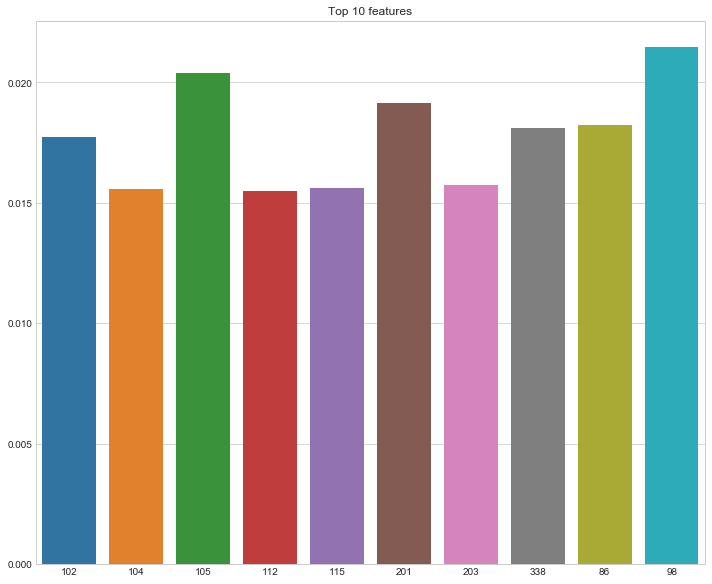

In [244]:
plt.pyplot.rcParams['figure.figsize'] =12, 10
feature_importances_rf = dict(zip(X_train.columns, best_rf.feature_importances_))
top10_rf = sorted(feature_importances_rf.items(), key=lambda x: -x[1])[:10]
fig = sns.barplot(x=[x[0] for x in top10_rf], y=[x[1] for x in top10_rf])
fig.set_title("Top 10 features")

In [245]:
top10_rf

[('98', 0.02148928427164256),
 ('105', 0.0203969362376233),
 ('201', 0.019131721833312677),
 ('86', 0.018251684636590871),
 ('338', 0.018095475970280134),
 ('102', 0.017726696927088219),
 ('203', 0.015757497965055888),
 ('115', 0.015637507508271385),
 ('104', 0.015585003013246621),
 ('112', 0.015505798547279247)]

# SVC

In [246]:
#lb = 0.69418842
best_svc = SVC(random_state=42, probability=True, C=10)

In [247]:
svc_predictions = get_submission(best_svc, X_train, X_test, y_train, 'svc_try.csv')

# **Ensemble it!**

In [248]:
lr_pred_cv = get_pred_cv(best_lr, X_train)
rf_pred_cv = get_pred_cv(best_rf, X_train)
bg_pred_cv = get_pred_cv(best_bgc, X_train)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


In [249]:
svc_pred_cv = get_pred_cv(best_svc, X_train)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


### Weighted mean

In [772]:
#lb 0.76683960

cv_score_weighted_mean = np.mean([roc_auc_score(xgb_p[0],
                                                xgb_p[1]*0.35 + lgb_p[1]*0.4 + ctb_p[1]* 0.25) for\
                                  xgb_p, lgb_p, ctb_p in zip(xgb_pred_cv, lgb_pred_cv, ctb_pred_cv)])

In [763]:
weighted_mean_predictions = 0.35 * xgb_predictions + 0.4 * lgb_predictions + 0.25 * ctb_predictions
make_file(weighted_mean_predictions, 'hw6_submissions/weighted_mean.csv')

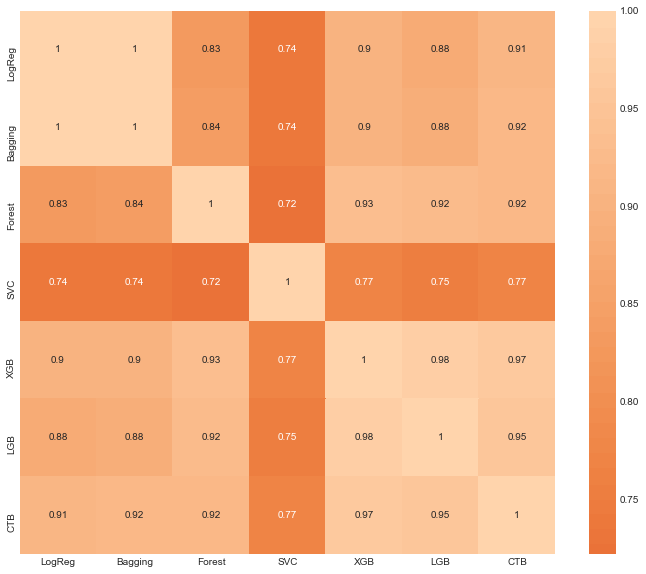

In [261]:
predictions = predictions = [lr_predictions, bcg_predictions, rf_predictions,
              svc_predictions, xgb_predictions, lgb_predictions, ctb_predictions]
lbls = ['LogReg', 'Bagging', 'Forest', 'SVC', 'XGB', 'LGB', 'CTB']
sns.heatmap(np.corrcoef(predictions), annot=True, xticklabels=lbls, yticklabels=lbls, center=0)

# Stacking

In [774]:
X_train_stacked = X_train.copy()
X_test_stacked = X_test.copy()

In [775]:
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=xgb_predictions,
                                              pred_cv=xgb_pred_cv, prefix='xgb')
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=rf_predictions,
                                              pred_cv=rf_pred_cv, prefix='rf')
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=lr_predictions,
                                              pred_cv=lr_pred_cv, prefix='lr')
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=svc_predictions,
                                              pred_cv=svc_pred_cv, prefix='svc')
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=bcg_predictions,
                                              pred_cv=bg_pred_cv, prefix='bg')
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=lgb_predictions,
                                              pred_cv=lgb_pred_cv, prefix='lgb')
X_train_stacked, X_test_stacked = get_stacked(X_train_stacked, X_test_stacked, predictions=ctb_predictions,
                                              pred_cv=ctb_pred_cv, prefix='ctb')